In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
trainA = []
trainB = []
for i in range(1,700):
  img = cv2.imread('rain/{}clean.jpg'.format(i))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256,256))
  trainA.append(img)
  img = cv2.imread('rain/{}bad.jpg'.format(i))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256,256))
  trainB.append(img)
trainA = np.array(trainA)
trainB = np.array(trainB)
trainA = (trainA - 127.5)/127.5
trainB = (trainB - 127.5)/127.5

In [4]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: C512-C512-C512-C512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

In [5]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, add, Concatenate
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss= BinaryCrossentropy(from_logits=True), optimizer=opt, loss_weights=[0.5])
	return model 
# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='/content/drive/My Drive/test/discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 64) 6208    

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    in_target = Input(shape = image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model([in_src,in_target], [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=[BinaryCrossentropy(from_logits=True), 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [7]:
def generate_real_samples(n_samples, patch_shape):
	# unpack dataset

	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [8]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [12]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, gan_model, n_samples=1):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	X_fakeB = 255 * X_fakeB	
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# save plot to file
	filename1 = 'TRAIN800/training/plot_%06d.png' % (step+1)
	cv2.imwrite(filename1,X_fakeB[0])
	# save the generator, discriminator and gan models
	filename2 = 'TRAIN800/training/g_model_%06d.h5' % (step+1)
	g_model.save(filename2)
	#filename3 = 'RainLtrain/trainingresult/d_model_%06d.h5' % (step+1)
	#d_model.save(filename3)
	#filename4 = 'RainLtrain/trainingresult/gan_model_%06d.h5' % (step+1)
	#gan_model.save(filename4)
	print('>Saved: %s,and %s' % (filename1, filename2))

In [15]:
def train(d_model, g_model, gan_model, n_epochs=200, n_batch=1, n_patch=32):
	# unpack dataset
  
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples( n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realB, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realB, X_realA], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realB, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch([X_realB,X_realA], [y_real, X_realA])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model,d_model, gan_model) 

/home/pytorch/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.264] d2[0.473] g[60.918]
>2, d1[0.259] d2[0.466] g[50.538]
>3, d1[0.260] d2[0.458] g[34.360]
>4, d1[0.260] d2[0.478] g[53.169]
>5, d1[0.265] d2[0.454] g[33.836]
>6, d1[0.271] d2[0.464] g[30.936]
>7, d1[0.279] d2[0.460] g[34.256]
>8, d1[0.275] d2[0.438] g[29.852]
>9, d1[0.281] d2[0.436] g[26.137]
>10, d1[0.282] d2[0.423] g[58.809]
>11, d1[0.287] d2[0.416] g[32.261]
>12, d1[0.292] d2[0.429] g[29.325]
>13, d1[0.294] d2[0.415] g[39.069]
>14, d1[0.288] d2[0.411] g[23.883]
>15, d1[0.284] d2[0.403] g[31.704]
>16, d1[0.290] d2[0.417] g[33.697]
>17, d1[0.286] d2[0.402] g[58.384]
>18, d1[0.280] d2[0.405] g[26.053]
>19, d1[0.274] d2[0.428] g[34.301]
>20, d1[0.307] d2[0.390] g[25.435]
>21, d1[0.315] d2[0.385] g[20.819]
>22, d1[0.309] d2[0.386] g[31.171]
>23, d1[0.303] d2[0.404] g[24.178]
>24, d1[0.301] d2[0.387] g[29.739]
>25, d1[0.299] d2[0.391] g[19.588]
>26, d1[0.317] d2[0.379] g[18.078]
>27, d1[0.268] d2[0.395] g[30.456]
>28, d1[0.306] d2[0.422] g[63.030]
>29, d1[0.317] d2[0.384] g[28

>232, d1[0.342] d2[0.351] g[13.309]
>233, d1[0.340] d2[0.353] g[20.741]
>234, d1[0.341] d2[0.354] g[19.832]
>235, d1[0.340] d2[0.354] g[15.203]
>236, d1[0.343] d2[0.350] g[11.986]
>237, d1[0.343] d2[0.350] g[12.703]
>238, d1[0.344] d2[0.349] g[17.764]
>239, d1[0.342] d2[0.352] g[18.264]
>240, d1[0.343] d2[0.353] g[15.201]
>241, d1[0.344] d2[0.349] g[15.770]
>242, d1[0.345] d2[0.348] g[11.219]
>243, d1[0.344] d2[0.349] g[12.315]
>244, d1[0.344] d2[0.349] g[13.935]
>245, d1[0.343] d2[0.350] g[17.482]
>246, d1[0.343] d2[0.350] g[21.016]
>247, d1[0.343] d2[0.351] g[14.006]
>248, d1[0.341] d2[0.351] g[16.325]
>249, d1[0.341] d2[0.354] g[13.217]
>250, d1[0.343] d2[0.350] g[15.636]
>251, d1[0.344] d2[0.349] g[24.821]
>252, d1[0.341] d2[0.352] g[11.158]
>253, d1[0.340] d2[0.353] g[12.601]
>254, d1[0.341] d2[0.352] g[21.903]
>255, d1[0.339] d2[0.356] g[27.086]
>256, d1[0.342] d2[0.351] g[14.963]
>257, d1[0.345] d2[0.349] g[10.920]
>258, d1[0.343] d2[0.350] g[12.612]
>259, d1[0.343] d2[0.350] g[

>460, d1[0.343] d2[0.350] g[12.713]
>461, d1[0.343] d2[0.349] g[12.051]
>462, d1[0.345] d2[0.349] g[9.453]
>463, d1[0.344] d2[0.350] g[13.808]
>464, d1[0.343] d2[0.350] g[13.176]
>465, d1[0.345] d2[0.348] g[15.571]
>466, d1[0.343] d2[0.350] g[17.381]
>467, d1[0.344] d2[0.348] g[24.014]
>468, d1[0.344] d2[0.349] g[19.904]
>469, d1[0.344] d2[0.350] g[14.295]
>470, d1[0.344] d2[0.349] g[12.575]
>471, d1[0.346] d2[0.348] g[14.910]
>472, d1[0.344] d2[0.349] g[16.379]
>473, d1[0.344] d2[0.349] g[19.691]
>474, d1[0.346] d2[0.348] g[11.100]
>475, d1[0.342] d2[0.351] g[17.732]
>476, d1[0.342] d2[0.350] g[14.578]
>477, d1[0.345] d2[0.348] g[10.831]
>478, d1[0.344] d2[0.349] g[14.627]
>479, d1[0.342] d2[0.351] g[23.596]
>480, d1[0.345] d2[0.348] g[13.486]
>481, d1[0.344] d2[0.350] g[21.235]
>482, d1[0.344] d2[0.350] g[20.069]
>483, d1[0.343] d2[0.350] g[20.134]
>484, d1[0.345] d2[0.349] g[14.042]
>485, d1[0.339] d2[0.356] g[10.377]
>486, d1[0.344] d2[0.349] g[13.074]
>487, d1[0.345] d2[0.348] g[9

>690, d1[0.345] d2[0.348] g[15.666]
>691, d1[0.336] d2[0.355] g[17.057]
>692, d1[0.342] d2[0.349] g[29.241]
>693, d1[0.345] d2[0.348] g[11.341]
>694, d1[0.344] d2[0.349] g[9.938]
>695, d1[0.340] d2[0.352] g[24.012]
>696, d1[0.342] d2[0.359] g[16.064]
>697, d1[0.338] d2[0.357] g[20.344]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>698, d1[0.341] d2[0.353] g[15.325]
>699, d1[0.343] d2[0.351] g[11.536]
>Saved: TRAIN800/training/plot_000699.png,and TRAIN800/training/g_model_000699.h5
>700, d1[0.342] d2[0.352] g[9.075]
>701, d1[0.340] d2[0.353] g[17.261]
>702, d1[0.345] d2[0.348] g[10.269]
>703, d1[0.340] d2[0.357] g[15.545]
>704, d1[0.346] d2[0.347] g[11.609]
>705, d1[0.345] d2[0.348] g[12.732]
>706, d1[0.344] d2[0.350] g[13.065]
>707, d1[0.341] d2[0.351] g[15.267]
>708, d1[0.341] d2[0.351] g[11.164]
>709, d1[0.345] d2[0.347] g[13.375]
>710, d1[0.336] d2[0.372] g[14.063]
>711, d1[0.345] d2[0.348] g[9.092]
>712, d1[0.344] d2[0.350] g[14.619]
>713, d1[0.345] d2[0.348] g[9.434]
>714, d1[0.343] d2[0.351] g[18.195]
>715, d1[0.344] d2[0.349] g[14.217]
>716, d1[0.344] d2[0.348] g[11.493]
>717, d1[0.344] d2[0.349] g[11.578]
>718, d1[0.342] d2[0.352] g[25.980]
>719, d1[0.335] d2[0.353] g[18.251]
>720, d1[0.345] d2[0.348] g[8.492]
>721, d1[0.346] d2[0.347] g[11.304]
>722, d1[0.340] d2[0.355] g[20.888]
>723, d1[0.342] d2[0.3

>926, d1[0.342] d2[0.350] g[17.266]
>927, d1[0.341] d2[0.356] g[10.045]
>928, d1[0.345] d2[0.348] g[25.393]
>929, d1[0.344] d2[0.351] g[18.454]
>930, d1[0.346] d2[0.347] g[10.712]
>931, d1[0.346] d2[0.347] g[9.574]
>932, d1[0.343] d2[0.349] g[14.474]
>933, d1[0.345] d2[0.349] g[10.696]
>934, d1[0.346] d2[0.347] g[8.881]
>935, d1[0.346] d2[0.347] g[10.103]
>936, d1[0.345] d2[0.351] g[13.604]
>937, d1[0.345] d2[0.348] g[14.653]
>938, d1[0.345] d2[0.348] g[10.174]
>939, d1[0.344] d2[0.349] g[13.905]
>940, d1[0.346] d2[0.347] g[11.859]
>941, d1[0.345] d2[0.349] g[11.205]
>942, d1[0.345] d2[0.350] g[12.521]
>943, d1[0.344] d2[0.349] g[10.246]
>944, d1[0.344] d2[0.348] g[14.016]
>945, d1[0.345] d2[0.348] g[18.265]
>946, d1[0.344] d2[0.349] g[9.865]
>947, d1[0.344] d2[0.350] g[6.759]
>948, d1[0.341] d2[0.349] g[9.899]
>949, d1[0.342] d2[0.349] g[14.450]
>950, d1[0.343] d2[0.349] g[10.017]
>951, d1[0.339] d2[0.349] g[32.171]
>952, d1[0.345] d2[0.348] g[15.619]
>953, d1[0.345] d2[0.348] g[10.00

>1151, d1[0.340] d2[0.349] g[11.384]
>1152, d1[0.344] d2[0.352] g[11.866]
>1153, d1[0.340] d2[0.348] g[11.428]
>1154, d1[0.346] d2[0.347] g[16.390]
>1155, d1[0.339] d2[0.351] g[13.195]
>1156, d1[0.332] d2[0.363] g[11.527]
>1157, d1[0.337] d2[0.352] g[16.132]
>1158, d1[0.313] d2[0.351] g[29.679]
>1159, d1[0.333] d2[0.359] g[10.290]
>1160, d1[0.328] d2[0.357] g[11.036]
>1161, d1[0.340] d2[0.366] g[13.543]
>1162, d1[0.342] d2[0.354] g[13.243]
>1163, d1[0.343] d2[0.348] g[9.904]
>1164, d1[0.337] d2[0.349] g[11.372]
>1165, d1[0.339] d2[0.354] g[12.646]
>1166, d1[0.337] d2[0.350] g[15.767]
>1167, d1[0.311] d2[0.381] g[20.483]
>1168, d1[0.342] d2[0.349] g[8.798]
>1169, d1[0.325] d2[0.367] g[13.047]
>1170, d1[0.343] d2[0.348] g[13.893]
>1171, d1[0.340] d2[0.348] g[12.316]
>1172, d1[0.342] d2[0.348] g[10.198]
>1173, d1[0.336] d2[0.352] g[18.621]
>1174, d1[0.335] d2[0.349] g[11.103]
>1175, d1[0.340] d2[0.356] g[13.561]
>1176, d1[0.314] d2[0.371] g[14.043]
>1177, d1[0.323] d2[0.356] g[11.872]
>11

>1374, d1[0.302] d2[0.377] g[16.281]
>1375, d1[0.338] d2[0.367] g[13.406]
>1376, d1[0.319] d2[0.356] g[15.946]
>1377, d1[0.325] d2[0.377] g[13.090]
>1378, d1[0.338] d2[0.358] g[12.407]
>1379, d1[0.330] d2[0.349] g[11.410]
>1380, d1[0.344] d2[0.348] g[11.079]
>1381, d1[0.341] d2[0.348] g[8.660]
>1382, d1[0.339] d2[0.352] g[8.803]
>1383, d1[0.316] d2[0.384] g[15.199]
>1384, d1[0.344] d2[0.348] g[18.288]
>1385, d1[0.340] d2[0.349] g[9.075]
>1386, d1[0.328] d2[0.363] g[11.047]
>1387, d1[0.341] d2[0.349] g[12.050]
>1388, d1[0.323] d2[0.355] g[10.761]
>1389, d1[0.315] d2[0.352] g[14.182]
>1390, d1[0.305] d2[0.351] g[19.707]
>1391, d1[0.332] d2[0.349] g[23.668]
>1392, d1[0.339] d2[0.351] g[11.579]
>1393, d1[0.324] d2[0.369] g[8.251]
>1394, d1[0.276] d2[0.354] g[31.512]
>1395, d1[0.326] d2[0.387] g[17.489]
>1396, d1[0.340] d2[0.348] g[11.498]
>1397, d1[0.340] d2[0.348] g[12.229]


/home/pytorch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1398, d1[0.323] d2[0.388] g[9.892]
>Saved: TRAIN800/training/plot_001398.png,and TRAIN800/training/g_model_001398.h5
>1399, d1[0.306] d2[0.373] g[18.280]
>1400, d1[0.346] d2[0.347] g[11.690]
>1401, d1[0.313] d2[0.349] g[19.198]
>1402, d1[0.320] d2[0.359] g[10.990]
>1403, d1[0.326] d2[0.369] g[16.101]
>1404, d1[0.334] d2[0.350] g[10.986]
>1405, d1[0.319] d2[0.358] g[14.764]
>1406, d1[0.336] d2[0.374] g[13.897]
>1407, d1[0.312] d2[0.353] g[20.153]
>1408, d1[0.338] d2[0.354] g[9.152]
>1409, d1[0.334] d2[0.370] g[11.555]
>1410, d1[0.324] d2[0.351] g[15.092]
>1411, d1[0.327] d2[0.353] g[19.882]
>1412, d1[0.300] d2[0.349] g[28.286]
>1413, d1[0.301] d2[0.360] g[14.627]
>1414, d1[0.343] d2[0.358] g[10.268]
>1415, d1[0.272] d2[0.411] g[16.123]
>1416, d1[0.337] d2[0.357] g[16.433]
>1417, d1[0.341] d2[0.348] g[12.046]
>1418, d1[0.323] d2[0.361] g[13.159]
>1419, d1[0.299] d2[0.391] g[14.515]
>1420, d1[0.319] d2[0.364] g[8.459]
>1421, d1[0.332] d2[0.366] g[12.957]
>1422, d1[0.343] d2[0.351] g[12.2

>1619, d1[0.326] d2[0.359] g[9.200]
>1620, d1[0.320] d2[0.363] g[7.027]
>1621, d1[0.328] d2[0.353] g[8.888]
>1622, d1[0.294] d2[0.368] g[13.400]
>1623, d1[0.310] d2[0.371] g[9.679]
>1624, d1[0.262] d2[0.357] g[21.225]
>1625, d1[0.322] d2[0.360] g[7.897]
>1626, d1[0.303] d2[0.365] g[14.245]
>1627, d1[0.311] d2[0.362] g[8.317]
>1628, d1[0.328] d2[0.367] g[14.150]
>1629, d1[0.321] d2[0.355] g[9.526]
>1630, d1[0.313] d2[0.362] g[8.289]
>1631, d1[0.335] d2[0.351] g[11.354]
>1632, d1[0.319] d2[0.366] g[11.753]
>1633, d1[0.320] d2[0.357] g[11.143]
>1634, d1[0.325] d2[0.361] g[10.287]
>1635, d1[0.314] d2[0.448] g[12.519]
>1636, d1[0.277] d2[0.467] g[10.568]
>1637, d1[0.287] d2[0.435] g[22.086]
>1638, d1[0.275] d2[0.461] g[14.167]
>1639, d1[0.273] d2[0.455] g[10.179]
>1640, d1[0.279] d2[0.450] g[14.337]
>1641, d1[0.266] d2[0.430] g[24.563]
>1642, d1[0.298] d2[0.422] g[10.614]
>1643, d1[0.254] d2[0.495] g[13.612]
>1644, d1[0.279] d2[0.442] g[9.849]
>1645, d1[0.291] d2[0.428] g[10.043]
>1646, d1[

>1845, d1[0.323] d2[0.351] g[14.135]
>1846, d1[0.290] d2[0.379] g[13.951]
>1847, d1[0.325] d2[0.352] g[10.179]
>1848, d1[0.317] d2[0.363] g[9.787]
>1849, d1[0.314] d2[0.358] g[11.480]
>1850, d1[0.309] d2[0.355] g[12.795]
>1851, d1[0.300] d2[0.358] g[23.633]
>1852, d1[0.295] d2[0.351] g[18.391]
>1853, d1[0.306] d2[0.352] g[18.694]
>1854, d1[0.300] d2[0.393] g[11.489]
>1855, d1[0.305] d2[0.360] g[16.427]
>1856, d1[0.292] d2[0.351] g[24.764]
>1857, d1[0.308] d2[0.351] g[16.696]
>1858, d1[0.293] d2[0.354] g[14.471]
>1859, d1[0.313] d2[0.388] g[7.863]
>1860, d1[0.276] d2[0.356] g[10.237]
>1861, d1[0.322] d2[0.401] g[9.615]
>1862, d1[0.297] d2[0.368] g[13.700]
>1863, d1[0.299] d2[0.378] g[9.475]
>1864, d1[0.278] d2[0.359] g[8.759]
>1865, d1[0.326] d2[0.352] g[11.904]
>1866, d1[0.314] d2[0.382] g[9.371]
>1867, d1[0.301] d2[0.384] g[15.685]
>1868, d1[0.317] d2[0.374] g[8.573]
>1869, d1[0.289] d2[0.355] g[27.967]
>1870, d1[0.313] d2[0.352] g[10.697]
>1871, d1[0.288] d2[0.361] g[19.095]
>1872, d

>2069, d1[0.284] d2[0.352] g[16.363]
>2070, d1[0.316] d2[0.369] g[10.213]
>2071, d1[0.291] d2[0.359] g[14.022]
>2072, d1[0.299] d2[0.409] g[7.969]
>2073, d1[0.333] d2[0.358] g[8.216]
>2074, d1[0.301] d2[0.375] g[9.665]
>2075, d1[0.321] d2[0.360] g[12.292]
>2076, d1[0.294] d2[0.365] g[15.504]
>2077, d1[0.289] d2[0.380] g[20.271]
>2078, d1[0.326] d2[0.353] g[9.388]
>2079, d1[0.285] d2[0.359] g[16.273]
>2080, d1[0.338] d2[0.363] g[12.044]
>2081, d1[0.306] d2[0.357] g[21.205]
>2082, d1[0.309] d2[0.351] g[10.008]
>2083, d1[0.329] d2[0.355] g[9.484]
>2084, d1[0.299] d2[0.368] g[7.913]
>2085, d1[0.314] d2[0.353] g[8.054]
>2086, d1[0.281] d2[0.370] g[14.422]
>2087, d1[0.274] d2[0.375] g[14.279]
>2088, d1[0.298] d2[0.356] g[9.497]
>2089, d1[0.334] d2[0.351] g[9.129]
>2090, d1[0.325] d2[0.365] g[14.477]
>2091, d1[0.318] d2[0.354] g[9.118]
>2092, d1[0.286] d2[0.358] g[11.357]
>2093, d1[0.322] d2[0.356] g[9.906]
>2094, d1[0.282] d2[0.377] g[20.608]
>2095, d1[0.305] d2[0.384] g[10.823]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2096, d1[0.297] d2[0.390] g[8.603]
>2097, d1[0.338] d2[0.352] g[10.886]
>Saved: TRAIN800/training/plot_002097.png,and TRAIN800/training/g_model_002097.h5
>2098, d1[0.302] d2[0.364] g[13.230]
>2099, d1[0.305] d2[0.351] g[15.456]
>2100, d1[0.330] d2[0.351] g[9.040]
>2101, d1[0.326] d2[0.351] g[11.562]
>2102, d1[0.316] d2[0.353] g[6.743]
>2103, d1[0.312] d2[0.365] g[11.666]
>2104, d1[0.308] d2[0.365] g[9.658]
>2105, d1[0.292] d2[0.360] g[11.819]
>2106, d1[0.302] d2[0.367] g[9.359]
>2107, d1[0.271] d2[0.386] g[26.992]
>2108, d1[0.294] d2[0.358] g[12.663]
>2109, d1[0.291] d2[0.355] g[16.209]
>2110, d1[0.271] d2[0.370] g[15.858]
>2111, d1[0.316] d2[0.362] g[11.409]
>2112, d1[0.272] d2[0.353] g[17.512]
>2113, d1[0.293] d2[0.359] g[8.922]
>2114, d1[0.290] d2[0.413] g[12.922]
>2115, d1[0.306] d2[0.356] g[11.115]
>2116, d1[0.291] d2[0.352] g[12.895]
>2117, d1[0.316] d2[0.353] g[11.801]
>2118, d1[0.281] d2[0.352] g[20.394]
>2119, d1[0.266] d2[0.417] g[14.837]
>2120, d1[0.294] d2[0.354] g[8.095]


>2318, d1[0.289] d2[0.361] g[11.407]
>2319, d1[0.285] d2[0.355] g[14.289]
>2320, d1[0.286] d2[0.351] g[12.101]
>2321, d1[0.289] d2[0.360] g[7.588]
>2322, d1[0.271] d2[0.359] g[12.008]
>2323, d1[0.279] d2[0.375] g[11.355]
>2324, d1[0.279] d2[0.364] g[14.876]
>2325, d1[0.284] d2[0.359] g[13.429]
>2326, d1[0.313] d2[0.370] g[13.019]
>2327, d1[0.264] d2[0.355] g[14.253]
>2328, d1[0.280] d2[0.353] g[9.234]
>2329, d1[0.294] d2[0.358] g[8.294]
>2330, d1[0.248] d2[0.471] g[31.380]
>2331, d1[0.260] d2[0.355] g[20.579]
>2332, d1[0.277] d2[0.369] g[11.854]
>2333, d1[0.259] d2[0.370] g[15.623]
>2334, d1[0.288] d2[0.355] g[9.699]
>2335, d1[0.323] d2[0.373] g[8.658]
>2336, d1[0.329] d2[0.360] g[13.890]
>2337, d1[0.307] d2[0.353] g[8.602]
>2338, d1[0.275] d2[0.356] g[11.775]
>2339, d1[0.279] d2[0.351] g[12.084]
>2340, d1[0.282] d2[0.387] g[13.851]
>2341, d1[0.268] d2[0.364] g[10.801]
>2342, d1[0.280] d2[0.388] g[9.732]
>2343, d1[0.288] d2[0.369] g[8.139]
>2344, d1[0.259] d2[0.353] g[18.843]
>2345, d1

>2542, d1[0.275] d2[0.349] g[8.923]
>2543, d1[0.288] d2[0.391] g[7.617]
>2544, d1[0.257] d2[0.355] g[10.488]
>2545, d1[0.285] d2[0.363] g[9.404]
>2546, d1[0.280] d2[0.355] g[7.990]
>2547, d1[0.268] d2[0.360] g[10.890]
>2548, d1[0.268] d2[0.369] g[9.134]
>2549, d1[0.300] d2[0.357] g[12.372]
>2550, d1[0.279] d2[0.360] g[9.390]
>2551, d1[0.249] d2[0.359] g[13.239]
>2552, d1[0.293] d2[0.375] g[7.941]
>2553, d1[0.272] d2[0.353] g[13.125]
>2554, d1[0.256] d2[0.360] g[11.938]
>2555, d1[0.260] d2[0.366] g[10.136]
>2556, d1[0.251] d2[0.355] g[12.798]
>2557, d1[0.263] d2[0.352] g[9.294]
>2558, d1[0.238] d2[0.356] g[19.235]
>2559, d1[0.275] d2[0.365] g[11.869]
>2560, d1[0.265] d2[0.353] g[14.724]
>2561, d1[0.248] d2[0.355] g[7.458]
>2562, d1[0.289] d2[0.356] g[8.361]
>2563, d1[0.254] d2[0.381] g[10.542]
>2564, d1[0.252] d2[0.363] g[10.053]
>2565, d1[0.252] d2[0.358] g[13.283]
>2566, d1[0.298] d2[0.354] g[8.976]
>2567, d1[0.250] d2[0.379] g[7.976]
>2568, d1[0.268] d2[0.366] g[9.605]
>2569, d1[0.27

>2766, d1[0.285] d2[0.371] g[9.649]
>2767, d1[0.293] d2[0.362] g[9.310]
>2768, d1[0.281] d2[0.362] g[12.661]
>2769, d1[0.291] d2[0.355] g[7.553]
>2770, d1[0.258] d2[0.357] g[8.456]
>2771, d1[0.256] d2[0.356] g[8.212]
>2772, d1[0.249] d2[0.354] g[12.544]
>2773, d1[0.251] d2[0.384] g[8.346]
>2774, d1[0.249] d2[0.353] g[14.078]
>2775, d1[0.309] d2[0.354] g[13.592]
>2776, d1[0.248] d2[0.353] g[13.709]
>2777, d1[0.244] d2[0.369] g[11.529]
>2778, d1[0.233] d2[0.352] g[34.261]
>2779, d1[0.296] d2[0.376] g[7.226]
>2780, d1[0.311] d2[0.352] g[11.965]
>2781, d1[0.250] d2[0.362] g[8.901]
>2782, d1[0.234] d2[0.359] g[11.640]
>2783, d1[0.243] d2[0.414] g[16.642]
>2784, d1[0.325] d2[0.351] g[7.188]
>2785, d1[0.274] d2[0.374] g[12.573]
>2786, d1[0.314] d2[0.351] g[16.874]
>2787, d1[0.260] d2[0.369] g[14.219]
>2788, d1[0.268] d2[0.357] g[21.007]
>2789, d1[0.239] d2[0.350] g[18.440]
>2790, d1[0.242] d2[0.351] g[13.212]
>2791, d1[0.231] d2[0.364] g[13.515]
>2792, d1[0.281] d2[0.351] g[8.727]
>2793, d1[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2795, d1[0.232] d2[0.375] g[15.419]
>2796, d1[0.249] d2[0.351] g[8.832]
>Saved: TRAIN800/training/plot_002796.png,and TRAIN800/training/g_model_002796.h5
>2797, d1[0.247] d2[0.349] g[12.193]
>2798, d1[0.278] d2[0.350] g[9.373]
>2799, d1[0.228] d2[0.391] g[10.936]
>2800, d1[0.264] d2[0.352] g[9.165]
>2801, d1[0.268] d2[0.358] g[17.660]
>2802, d1[0.287] d2[0.385] g[9.023]
>2803, d1[0.308] d2[0.360] g[14.903]
>2804, d1[0.323] d2[0.351] g[13.137]
>2805, d1[0.280] d2[0.350] g[12.676]
>2806, d1[0.298] d2[0.381] g[8.663]
>2807, d1[0.233] d2[0.351] g[25.726]
>2808, d1[0.253] d2[0.386] g[12.637]
>2809, d1[0.257] d2[0.352] g[14.894]
>2810, d1[0.268] d2[0.398] g[9.029]
>2811, d1[0.245] d2[0.349] g[9.693]
>2812, d1[0.240] d2[0.350] g[16.356]
>2813, d1[0.244] d2[0.382] g[8.251]
>2814, d1[0.235] d2[0.356] g[14.944]
>2815, d1[0.254] d2[0.366] g[9.372]
>2816, d1[0.252] d2[0.350] g[14.742]
>2817, d1[0.261] d2[0.349] g[10.361]
>2818, d1[0.237] d2[0.393] g[13.158]
>2819, d1[0.320] d2[0.372] g[7.494]
>28

>3017, d1[0.278] d2[0.378] g[8.948]
>3018, d1[0.255] d2[0.353] g[13.258]
>3019, d1[0.253] d2[0.347] g[12.245]
>3020, d1[0.231] d2[0.406] g[11.347]
>3021, d1[0.237] d2[0.350] g[11.267]
>3022, d1[0.267] d2[0.358] g[8.352]
>3023, d1[0.229] d2[0.364] g[11.548]
>3024, d1[0.230] d2[0.351] g[20.597]
>3025, d1[0.264] d2[0.349] g[11.032]
>3026, d1[0.222] d2[0.350] g[17.742]
>3027, d1[0.232] d2[0.350] g[8.327]
>3028, d1[0.239] d2[0.377] g[8.767]
>3029, d1[0.233] d2[0.350] g[12.345]
>3030, d1[0.250] d2[0.351] g[7.528]
>3031, d1[0.236] d2[0.357] g[8.708]
>3032, d1[0.223] d2[0.358] g[13.766]
>3033, d1[0.236] d2[0.354] g[13.640]
>3034, d1[0.282] d2[0.367] g[8.080]
>3035, d1[0.231] d2[0.351] g[9.607]
>3036, d1[0.256] d2[0.381] g[6.155]
>3037, d1[0.234] d2[0.357] g[13.425]
>3038, d1[0.238] d2[0.353] g[10.834]
>3039, d1[0.230] d2[0.361] g[8.816]
>3040, d1[0.263] d2[0.358] g[9.216]
>3041, d1[0.227] d2[0.360] g[9.130]
>3042, d1[0.229] d2[0.355] g[9.225]
>3043, d1[0.242] d2[0.349] g[8.784]
>3044, d1[0.288

>3244, d1[0.227] d2[0.429] g[13.864]
>3245, d1[0.269] d2[0.349] g[20.312]
>3246, d1[0.246] d2[0.350] g[9.633]
>3247, d1[0.236] d2[0.350] g[7.477]
>3248, d1[0.233] d2[0.358] g[8.719]
>3249, d1[0.224] d2[0.352] g[8.000]
>3250, d1[0.215] d2[0.350] g[15.916]
>3251, d1[0.246] d2[0.348] g[6.580]
>3252, d1[0.225] d2[0.357] g[14.071]
>3253, d1[0.225] d2[0.354] g[12.259]
>3254, d1[0.221] d2[0.350] g[8.723]
>3255, d1[0.225] d2[0.349] g[8.943]
>3256, d1[0.215] d2[0.389] g[14.651]
>3257, d1[0.227] d2[0.349] g[12.174]
>3258, d1[0.227] d2[0.349] g[10.411]
>3259, d1[0.216] d2[0.348] g[16.149]
>3260, d1[0.230] d2[0.355] g[9.832]
>3261, d1[0.220] d2[0.392] g[9.080]
>3262, d1[0.252] d2[0.359] g[11.815]
>3263, d1[0.225] d2[0.358] g[12.210]
>3264, d1[0.258] d2[0.350] g[10.573]
>3265, d1[0.242] d2[0.352] g[10.435]
>3266, d1[0.253] d2[0.467] g[11.074]
>3267, d1[0.244] d2[0.368] g[9.361]
>3268, d1[0.245] d2[0.364] g[11.096]
>3269, d1[0.244] d2[0.349] g[9.114]
>3270, d1[0.289] d2[0.348] g[11.410]
>3271, d1[0.

>3468, d1[0.228] d2[0.350] g[9.150]
>3469, d1[0.228] d2[0.350] g[11.025]
>3470, d1[0.218] d2[0.353] g[9.615]
>3471, d1[0.214] d2[0.349] g[6.923]
>3472, d1[0.222] d2[0.350] g[7.206]
>3473, d1[0.240] d2[0.352] g[10.807]
>3474, d1[0.223] d2[0.376] g[9.934]
>3475, d1[0.264] d2[0.348] g[7.753]
>3476, d1[0.227] d2[0.409] g[10.031]
>3477, d1[0.229] d2[0.350] g[12.767]
>3478, d1[0.266] d2[0.348] g[9.687]
>3479, d1[0.241] d2[0.368] g[9.210]
>3480, d1[0.217] d2[0.348] g[13.481]
>3481, d1[0.254] d2[0.381] g[7.837]
>3482, d1[0.212] d2[0.458] g[13.364]
>3483, d1[0.271] d2[0.354] g[7.916]
>3484, d1[0.257] d2[0.352] g[8.105]
>3485, d1[0.220] d2[0.350] g[10.579]
>3486, d1[0.224] d2[0.357] g[24.305]
>3487, d1[0.276] d2[0.348] g[8.596]
>3488, d1[0.226] d2[0.408] g[14.225]
>3489, d1[0.241] d2[0.351] g[12.234]
>3490, d1[0.225] d2[0.434] g[32.076]
>3491, d1[0.241] d2[0.350] g[16.213]
>3492, d1[0.288] d2[0.417] g[8.078]
>3493, d1[0.327] d2[0.361] g[15.590]
>3494, d1[0.319] d2[0.357] g[9.254]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3495, d1[0.295] d2[0.368] g[8.593]
>Saved: TRAIN800/training/plot_003495.png,and TRAIN800/training/g_model_003495.h5
>3496, d1[0.315] d2[0.364] g[10.270]
>3497, d1[0.318] d2[0.352] g[8.033]
>3498, d1[0.306] d2[0.353] g[13.424]
>3499, d1[0.301] d2[0.359] g[10.722]
>3500, d1[0.298] d2[0.361] g[8.972]
>3501, d1[0.295] d2[0.357] g[9.184]
>3502, d1[0.283] d2[0.348] g[18.492]
>3503, d1[0.299] d2[0.348] g[10.189]
>3504, d1[0.274] d2[0.353] g[7.784]
>3505, d1[0.282] d2[0.355] g[9.693]
>3506, d1[0.282] d2[0.348] g[10.049]
>3507, d1[0.266] d2[0.351] g[16.676]
>3508, d1[0.291] d2[0.362] g[9.558]
>3509, d1[0.287] d2[0.353] g[6.251]
>3510, d1[0.257] d2[0.350] g[7.783]
>3511, d1[0.234] d2[0.356] g[10.377]
>3512, d1[0.231] d2[0.349] g[16.520]
>3513, d1[0.242] d2[0.350] g[8.342]
>3514, d1[0.220] d2[0.359] g[9.942]
>3515, d1[0.223] d2[0.352] g[16.247]
>3516, d1[0.218] d2[0.351] g[11.703]
>3517, d1[0.237] d2[0.350] g[11.521]
>3518, d1[0.232] d2[0.365] g[19.792]
>3519, d1[0.222] d2[0.351] g[10.039]
>352

>3717, d1[0.214] d2[0.387] g[11.385]
>3718, d1[0.215] d2[0.349] g[10.906]
>3719, d1[0.244] d2[0.355] g[17.890]
>3720, d1[0.218] d2[0.348] g[8.784]
>3721, d1[0.222] d2[0.349] g[9.196]
>3722, d1[0.212] d2[0.348] g[9.509]
>3723, d1[0.223] d2[0.358] g[18.763]
>3724, d1[0.210] d2[0.347] g[7.208]
>3725, d1[0.214] d2[0.351] g[14.405]
>3726, d1[0.213] d2[0.350] g[15.092]
>3727, d1[0.219] d2[0.348] g[13.497]
>3728, d1[0.247] d2[0.358] g[9.910]
>3729, d1[0.218] d2[0.415] g[12.440]
>3730, d1[0.249] d2[0.355] g[10.545]
>3731, d1[0.237] d2[0.370] g[9.418]
>3732, d1[0.249] d2[0.353] g[11.082]
>3733, d1[0.281] d2[0.482] g[10.464]
>3734, d1[0.226] d2[0.350] g[13.020]
>3735, d1[0.260] d2[0.423] g[9.481]
>3736, d1[0.284] d2[0.355] g[9.491]
>3737, d1[0.283] d2[0.356] g[11.472]
>3738, d1[0.238] d2[0.350] g[11.062]
>3739, d1[0.231] d2[0.375] g[8.315]
>3740, d1[0.221] d2[0.356] g[6.627]
>3741, d1[0.230] d2[0.355] g[9.603]
>3742, d1[0.290] d2[0.358] g[14.043]
>3743, d1[0.216] d2[0.360] g[14.616]
>3744, d1[0.

>3942, d1[0.281] d2[0.349] g[9.220]
>3943, d1[0.279] d2[0.349] g[9.662]
>3944, d1[0.268] d2[0.366] g[9.464]
>3945, d1[0.236] d2[0.356] g[9.887]
>3946, d1[0.235] d2[0.348] g[15.668]
>3947, d1[0.222] d2[0.350] g[8.442]
>3948, d1[0.208] d2[0.350] g[10.199]
>3949, d1[0.218] d2[0.349] g[24.063]
>3950, d1[0.218] d2[0.352] g[11.610]
>3951, d1[0.202] d2[0.362] g[7.832]
>3952, d1[0.212] d2[0.353] g[16.016]
>3953, d1[0.220] d2[0.354] g[8.645]
>3954, d1[0.199] d2[0.349] g[10.627]
>3955, d1[0.218] d2[0.350] g[10.950]
>3956, d1[0.215] d2[0.348] g[11.060]
>3957, d1[0.217] d2[0.356] g[22.114]
>3958, d1[0.272] d2[0.365] g[21.539]
>3959, d1[0.210] d2[0.348] g[10.502]
>3960, d1[0.210] d2[0.353] g[9.703]
>3961, d1[0.207] d2[0.349] g[22.302]
>3962, d1[0.232] d2[0.363] g[7.986]
>3963, d1[0.213] d2[0.395] g[17.541]
>3964, d1[0.231] d2[0.351] g[11.051]
>3965, d1[0.209] d2[0.348] g[11.328]
>3966, d1[0.218] d2[0.348] g[14.883]
>3967, d1[0.213] d2[0.460] g[30.390]
>3968, d1[0.252] d2[0.351] g[13.587]
>3969, d1[

>4166, d1[0.226] d2[0.348] g[10.138]
>4167, d1[0.205] d2[0.348] g[12.900]
>4168, d1[0.235] d2[0.347] g[11.993]
>4169, d1[0.218] d2[0.425] g[8.528]
>4170, d1[0.211] d2[0.353] g[9.901]
>4171, d1[0.218] d2[0.347] g[11.996]
>4172, d1[0.249] d2[0.349] g[11.893]
>4173, d1[0.209] d2[0.347] g[11.646]
>4174, d1[0.205] d2[0.347] g[8.565]
>4175, d1[0.208] d2[0.348] g[9.751]
>4176, d1[0.222] d2[0.349] g[8.792]
>4177, d1[0.211] d2[0.351] g[8.992]
>4178, d1[0.220] d2[0.350] g[9.549]
>4179, d1[0.192] d2[0.360] g[8.642]
>4180, d1[0.214] d2[0.348] g[9.918]
>4181, d1[0.206] d2[0.348] g[14.219]
>4182, d1[0.262] d2[0.385] g[13.486]
>4183, d1[0.203] d2[0.361] g[7.591]
>4184, d1[0.214] d2[0.348] g[9.324]
>4185, d1[0.204] d2[0.349] g[10.752]
>4186, d1[0.211] d2[0.351] g[11.323]
>4187, d1[0.211] d2[0.366] g[15.657]
>4188, d1[0.213] d2[0.347] g[13.991]
>4189, d1[0.306] d2[0.349] g[8.371]
>4190, d1[0.211] d2[0.423] g[9.216]
>4191, d1[0.253] d2[0.358] g[8.930]
>4192, d1[0.244] d2[0.364] g[10.083]
>4193, d1[0.223

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4194, d1[0.221] d2[0.467] g[7.719]
>Saved: TRAIN800/training/plot_004194.png,and TRAIN800/training/g_model_004194.h5
>4195, d1[0.264] d2[0.351] g[8.272]
>4196, d1[0.210] d2[0.350] g[9.097]
>4197, d1[0.213] d2[0.351] g[15.272]
>4198, d1[0.220] d2[0.348] g[9.470]
>4199, d1[0.214] d2[0.348] g[7.409]
>4200, d1[0.216] d2[0.350] g[15.568]
>4201, d1[0.220] d2[0.352] g[13.561]
>4202, d1[0.208] d2[0.349] g[11.234]
>4203, d1[0.241] d2[0.424] g[9.986]
>4204, d1[0.228] d2[0.370] g[9.936]
>4205, d1[0.276] d2[0.494] g[7.257]
>4206, d1[0.237] d2[0.407] g[8.840]
>4207, d1[0.220] d2[0.348] g[12.019]
>4208, d1[0.211] d2[0.351] g[9.463]
>4209, d1[0.230] d2[0.349] g[8.862]
>4210, d1[0.239] d2[0.348] g[13.029]
>4211, d1[0.214] d2[0.366] g[13.459]
>4212, d1[0.207] d2[0.350] g[12.321]
>4213, d1[0.228] d2[0.381] g[13.743]
>4214, d1[0.219] d2[0.348] g[13.617]
>4215, d1[0.274] d2[0.349] g[7.697]
>4216, d1[0.213] d2[0.348] g[13.995]
>4217, d1[0.220] d2[0.363] g[8.288]
>4218, d1[0.227] d2[0.348] g[12.200]
>4219,

>4417, d1[0.228] d2[0.357] g[11.592]
>4418, d1[0.211] d2[0.348] g[12.665]
>4419, d1[0.208] d2[0.348] g[9.274]
>4420, d1[0.222] d2[0.348] g[7.744]
>4421, d1[0.203] d2[0.348] g[8.602]
>4422, d1[0.206] d2[0.374] g[11.764]
>4423, d1[0.203] d2[0.347] g[8.007]
>4424, d1[0.290] d2[0.353] g[10.824]
>4425, d1[0.229] d2[0.358] g[11.530]
>4426, d1[0.202] d2[0.349] g[17.880]
>4427, d1[0.211] d2[0.384] g[11.371]
>4428, d1[0.202] d2[0.347] g[9.739]
>4429, d1[0.208] d2[0.350] g[8.604]
>4430, d1[0.209] d2[0.349] g[13.042]
>4431, d1[0.212] d2[0.351] g[7.700]
>4432, d1[0.235] d2[0.347] g[12.134]
>4433, d1[0.202] d2[0.359] g[18.324]
>4434, d1[0.211] d2[0.347] g[11.929]
>4435, d1[0.209] d2[0.349] g[12.032]
>4436, d1[0.213] d2[0.419] g[8.576]
>4437, d1[0.223] d2[0.348] g[7.141]
>4438, d1[0.226] d2[0.349] g[8.677]
>4439, d1[0.207] d2[0.358] g[10.300]
>4440, d1[0.212] d2[0.349] g[6.769]
>4441, d1[0.227] d2[0.347] g[8.470]
>4442, d1[0.205] d2[0.349] g[16.630]
>4443, d1[0.207] d2[0.349] g[7.351]
>4444, d1[0.20

>4642, d1[0.201] d2[0.351] g[12.055]
>4643, d1[0.199] d2[0.348] g[8.398]
>4644, d1[0.209] d2[0.348] g[15.928]
>4645, d1[0.206] d2[0.347] g[11.802]
>4646, d1[0.201] d2[0.347] g[8.467]
>4647, d1[0.209] d2[0.358] g[10.072]
>4648, d1[0.203] d2[0.348] g[13.303]
>4649, d1[0.212] d2[0.348] g[10.396]
>4650, d1[0.205] d2[0.367] g[10.697]
>4651, d1[0.207] d2[0.356] g[9.390]
>4652, d1[0.210] d2[0.350] g[10.209]
>4653, d1[0.226] d2[0.358] g[8.125]
>4654, d1[0.194] d2[0.353] g[9.362]
>4655, d1[0.198] d2[0.350] g[11.054]
>4656, d1[0.206] d2[0.351] g[11.879]
>4657, d1[0.206] d2[0.347] g[10.058]
>4658, d1[0.212] d2[0.349] g[9.116]
>4659, d1[0.199] d2[0.348] g[11.172]
>4660, d1[0.211] d2[0.360] g[18.204]
>4661, d1[0.202] d2[0.349] g[13.897]
>4662, d1[0.271] d2[0.360] g[9.266]
>4663, d1[0.208] d2[0.359] g[9.522]
>4664, d1[0.214] d2[0.349] g[10.546]
>4665, d1[0.211] d2[0.407] g[17.326]
>4666, d1[0.313] d2[0.350] g[10.030]
>4667, d1[0.300] d2[0.355] g[9.795]
>4668, d1[0.252] d2[0.389] g[9.266]
>4669, d1[0

>4868, d1[0.216] d2[0.348] g[9.069]
>4869, d1[0.202] d2[0.348] g[8.592]
>4870, d1[0.210] d2[0.348] g[11.782]
>4871, d1[0.210] d2[0.358] g[12.673]
>4872, d1[0.276] d2[0.350] g[8.700]
>4873, d1[0.207] d2[0.485] g[9.467]
>4874, d1[0.204] d2[0.348] g[9.749]
>4875, d1[0.213] d2[0.349] g[10.368]
>4876, d1[0.203] d2[0.348] g[9.878]
>4877, d1[0.218] d2[0.348] g[10.640]
>4878, d1[0.206] d2[0.347] g[11.394]
>4879, d1[0.197] d2[0.347] g[10.073]
>4880, d1[0.207] d2[0.405] g[8.628]
>4881, d1[0.207] d2[0.349] g[9.691]
>4882, d1[0.330] d2[0.352] g[22.043]
>4883, d1[0.326] d2[0.365] g[8.701]
>4884, d1[0.286] d2[0.351] g[9.583]
>4885, d1[0.284] d2[0.349] g[7.563]
>4886, d1[0.249] d2[0.357] g[11.813]
>4887, d1[0.261] d2[0.358] g[14.288]
>4888, d1[0.229] d2[0.349] g[10.442]
>4889, d1[0.216] d2[0.347] g[13.132]
>4890, d1[0.210] d2[0.347] g[15.276]
>4891, d1[0.213] d2[0.362] g[12.559]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4892, d1[0.255] d2[0.485] g[10.022]
>4893, d1[0.298] d2[0.374] g[7.903]
>Saved: TRAIN800/training/plot_004893.png,and TRAIN800/training/g_model_004893.h5
>4894, d1[0.262] d2[0.459] g[6.775]
>4895, d1[0.301] d2[0.404] g[7.792]
>4896, d1[0.308] d2[0.365] g[8.845]
>4897, d1[0.261] d2[0.372] g[11.892]
>4898, d1[0.257] d2[0.395] g[11.632]
>4899, d1[0.307] d2[0.366] g[9.868]
>4900, d1[0.275] d2[0.352] g[11.975]
>4901, d1[0.267] d2[0.355] g[9.627]
>4902, d1[0.290] d2[0.452] g[10.442]
>4903, d1[0.242] d2[0.354] g[9.831]
>4904, d1[0.210] d2[0.347] g[10.490]
>4905, d1[0.246] d2[0.359] g[6.074]
>4906, d1[0.215] d2[0.352] g[7.165]
>4907, d1[0.204] d2[0.351] g[25.575]
>4908, d1[0.239] d2[0.357] g[9.993]
>4909, d1[0.239] d2[0.347] g[9.731]
>4910, d1[0.206] d2[0.348] g[9.482]
>4911, d1[0.206] d2[0.387] g[11.662]
>4912, d1[0.214] d2[0.348] g[15.638]
>4913, d1[0.206] d2[0.351] g[8.058]
>4914, d1[0.212] d2[0.352] g[10.032]
>4915, d1[0.299] d2[0.349] g[8.053]
>4916, d1[0.205] d2[0.396] g[13.307]
>4917, 

>5115, d1[0.198] d2[0.348] g[15.163]
>5116, d1[0.197] d2[0.351] g[7.945]
>5117, d1[0.201] d2[0.348] g[11.235]
>5118, d1[0.205] d2[0.359] g[20.402]
>5119, d1[0.249] d2[0.352] g[6.746]
>5120, d1[0.204] d2[0.355] g[7.914]
>5121, d1[0.206] d2[0.389] g[6.512]
>5122, d1[0.222] d2[0.349] g[8.772]
>5123, d1[0.201] d2[0.356] g[8.925]
>5124, d1[0.198] d2[0.367] g[7.897]
>5125, d1[0.199] d2[0.347] g[11.186]
>5126, d1[0.252] d2[0.348] g[13.282]
>5127, d1[0.199] d2[0.386] g[13.049]
>5128, d1[0.207] d2[0.349] g[9.716]
>5129, d1[0.272] d2[0.350] g[7.594]
>5130, d1[0.209] d2[0.348] g[14.643]
>5131, d1[0.289] d2[0.348] g[7.771]
>5132, d1[0.199] d2[0.348] g[9.024]
>5133, d1[0.209] d2[0.378] g[7.538]
>5134, d1[0.207] d2[0.348] g[9.193]
>5135, d1[0.202] d2[0.349] g[11.002]
>5136, d1[0.207] d2[0.350] g[7.777]
>5137, d1[0.199] d2[0.350] g[9.763]
>5138, d1[0.202] d2[0.353] g[18.924]
>5139, d1[0.313] d2[0.398] g[7.802]
>5140, d1[0.198] d2[0.354] g[10.061]
>5141, d1[0.257] d2[0.347] g[10.229]
>5142, d1[0.198] 

>5340, d1[0.214] d2[0.348] g[12.568]
>5341, d1[0.191] d2[0.348] g[7.125]
>5342, d1[0.190] d2[0.347] g[15.420]
>5343, d1[0.189] d2[0.347] g[13.734]
>5344, d1[0.202] d2[0.347] g[11.170]
>5345, d1[0.197] d2[0.347] g[10.878]
>5346, d1[0.194] d2[0.347] g[8.599]
>5347, d1[0.196] d2[0.350] g[9.685]
>5348, d1[0.206] d2[0.349] g[13.570]
>5349, d1[0.207] d2[0.354] g[15.660]
>5350, d1[0.201] d2[0.349] g[8.274]
>5351, d1[0.200] d2[0.362] g[12.297]
>5352, d1[0.202] d2[0.350] g[13.583]
>5353, d1[0.211] d2[0.354] g[10.306]
>5354, d1[0.200] d2[0.347] g[14.569]
>5355, d1[0.196] d2[0.347] g[10.534]
>5356, d1[0.199] d2[0.351] g[12.890]
>5357, d1[0.200] d2[0.347] g[12.417]
>5358, d1[0.202] d2[0.350] g[11.462]
>5359, d1[0.198] d2[0.348] g[16.074]
>5360, d1[0.193] d2[0.347] g[7.682]
>5361, d1[0.191] d2[0.348] g[11.260]
>5362, d1[0.198] d2[0.347] g[6.783]
>5363, d1[0.205] d2[0.347] g[8.654]
>5364, d1[0.199] d2[0.352] g[7.419]
>5365, d1[0.185] d2[0.348] g[11.919]
>5366, d1[0.192] d2[0.347] g[13.356]
>5367, d1

>5566, d1[0.190] d2[0.351] g[14.993]
>5567, d1[0.189] d2[0.347] g[8.397]
>5568, d1[0.219] d2[0.545] g[8.441]
>5569, d1[0.278] d2[0.395] g[8.154]
>5570, d1[0.269] d2[0.380] g[10.215]
>5571, d1[0.283] d2[0.413] g[7.295]
>5572, d1[0.294] d2[0.358] g[9.603]
>5573, d1[0.297] d2[0.368] g[12.702]
>5574, d1[0.253] d2[0.348] g[11.307]
>5575, d1[0.303] d2[0.372] g[7.936]
>5576, d1[0.321] d2[0.348] g[9.208]
>5577, d1[0.278] d2[0.361] g[8.675]
>5578, d1[0.255] d2[0.347] g[7.929]
>5579, d1[0.261] d2[0.351] g[8.162]
>5580, d1[0.249] d2[0.385] g[8.682]
>5581, d1[0.233] d2[0.356] g[8.054]
>5582, d1[0.252] d2[0.379] g[19.226]
>5583, d1[0.212] d2[0.351] g[11.160]
>5584, d1[0.288] d2[0.351] g[9.934]
>5585, d1[0.209] d2[0.352] g[8.405]
>5586, d1[0.212] d2[0.354] g[10.560]
>5587, d1[0.226] d2[0.350] g[12.209]
>5588, d1[0.304] d2[0.389] g[9.059]
>5589, d1[0.208] d2[0.355] g[13.273]
>5590, d1[0.195] d2[0.370] g[10.522]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5591, d1[0.283] d2[0.395] g[6.540]
>5592, d1[0.210] d2[0.354] g[7.747]
>Saved: TRAIN800/training/plot_005592.png,and TRAIN800/training/g_model_005592.h5
>5593, d1[0.197] d2[0.349] g[9.185]
>5594, d1[0.221] d2[0.349] g[10.109]
>5595, d1[0.210] d2[0.393] g[8.084]
>5596, d1[0.204] d2[0.350] g[8.286]
>5597, d1[0.198] d2[0.381] g[13.248]
>5598, d1[0.233] d2[0.347] g[10.231]
>5599, d1[0.285] d2[0.349] g[6.230]
>5600, d1[0.196] d2[0.415] g[10.485]
>5601, d1[0.199] d2[0.347] g[9.147]
>5602, d1[0.215] d2[0.353] g[10.363]
>5603, d1[0.203] d2[0.352] g[11.476]
>5604, d1[0.217] d2[0.354] g[8.833]
>5605, d1[0.227] d2[0.349] g[8.757]
>5606, d1[0.204] d2[0.355] g[10.214]
>5607, d1[0.213] d2[0.359] g[10.588]
>5608, d1[0.210] d2[0.350] g[8.482]
>5609, d1[0.207] d2[0.349] g[8.046]
>5610, d1[0.199] d2[0.352] g[7.416]
>5611, d1[0.203] d2[0.348] g[12.895]
>5612, d1[0.198] d2[0.351] g[7.362]
>5613, d1[0.201] d2[0.347] g[6.649]
>5614, d1[0.203] d2[0.348] g[13.659]
>5615, d1[0.193] d2[0.357] g[6.851]
>5616, d

>5814, d1[0.205] d2[0.348] g[9.180]
>5815, d1[0.191] d2[0.348] g[16.094]
>5816, d1[0.215] d2[0.348] g[7.349]
>5817, d1[0.200] d2[0.348] g[11.112]
>5818, d1[0.202] d2[0.347] g[11.961]
>5819, d1[0.197] d2[0.350] g[11.472]
>5820, d1[0.198] d2[0.348] g[10.342]
>5821, d1[0.215] d2[0.347] g[9.539]
>5822, d1[0.206] d2[0.347] g[13.138]
>5823, d1[0.194] d2[0.355] g[15.036]
>5824, d1[0.196] d2[0.349] g[9.994]
>5825, d1[0.201] d2[0.347] g[9.858]
>5826, d1[0.223] d2[0.347] g[9.699]
>5827, d1[0.194] d2[0.600] g[12.442]
>5828, d1[0.197] d2[0.386] g[12.186]
>5829, d1[0.193] d2[0.350] g[9.674]
>5830, d1[0.202] d2[0.349] g[7.209]
>5831, d1[0.203] d2[0.370] g[13.568]
>5832, d1[0.215] d2[0.350] g[8.141]
>5833, d1[0.198] d2[0.347] g[10.558]
>5834, d1[0.197] d2[0.347] g[11.825]
>5835, d1[0.203] d2[0.347] g[13.302]
>5836, d1[0.207] d2[0.350] g[7.516]
>5837, d1[0.193] d2[0.347] g[9.133]
>5838, d1[0.201] d2[0.358] g[12.215]
>5839, d1[0.202] d2[0.353] g[8.345]
>5840, d1[0.188] d2[0.347] g[16.326]
>5841, d1[0.2

>6039, d1[0.197] d2[0.350] g[8.413]
>6040, d1[0.237] d2[0.351] g[9.555]
>6041, d1[0.198] d2[0.350] g[8.404]
>6042, d1[0.189] d2[0.348] g[8.910]
>6043, d1[0.187] d2[0.347] g[9.439]
>6044, d1[0.190] d2[0.347] g[20.109]
>6045, d1[0.193] d2[0.350] g[7.819]
>6046, d1[0.190] d2[0.347] g[13.653]
>6047, d1[0.184] d2[0.357] g[12.577]
>6048, d1[0.198] d2[0.347] g[8.665]
>6049, d1[0.202] d2[0.347] g[7.650]
>6050, d1[0.196] d2[0.347] g[10.516]
>6051, d1[0.191] d2[0.348] g[12.914]
>6052, d1[0.200] d2[0.358] g[8.804]
>6053, d1[0.183] d2[0.347] g[8.738]
>6054, d1[0.192] d2[0.347] g[11.815]
>6055, d1[0.203] d2[0.347] g[11.339]
>6056, d1[0.191] d2[0.347] g[10.827]
>6057, d1[0.183] d2[0.351] g[7.755]
>6058, d1[0.193] d2[0.348] g[8.621]
>6059, d1[0.200] d2[0.350] g[13.027]
>6060, d1[0.208] d2[0.356] g[10.140]
>6061, d1[0.204] d2[0.347] g[12.104]
>6062, d1[0.190] d2[0.348] g[11.353]
>6063, d1[0.193] d2[0.349] g[12.244]
>6064, d1[0.189] d2[0.352] g[12.845]
>6065, d1[0.195] d2[0.348] g[10.700]
>6066, d1[0.1

>6264, d1[0.193] d2[0.347] g[11.147]
>6265, d1[0.307] d2[0.400] g[8.874]
>6266, d1[0.196] d2[0.347] g[10.103]
>6267, d1[0.187] d2[0.347] g[9.496]
>6268, d1[0.193] d2[0.348] g[7.123]
>6269, d1[0.195] d2[0.348] g[7.368]
>6270, d1[0.190] d2[0.368] g[9.225]
>6271, d1[0.188] d2[0.348] g[7.630]
>6272, d1[0.191] d2[0.349] g[6.416]
>6273, d1[0.191] d2[0.353] g[15.456]
>6274, d1[0.191] d2[0.347] g[8.874]
>6275, d1[0.198] d2[0.348] g[9.546]
>6276, d1[0.200] d2[0.357] g[10.885]
>6277, d1[0.196] d2[0.348] g[10.233]
>6278, d1[0.191] d2[0.347] g[8.479]
>6279, d1[0.206] d2[0.347] g[9.385]
>6280, d1[0.195] d2[0.347] g[13.107]
>6281, d1[0.199] d2[0.348] g[11.863]
>6282, d1[0.200] d2[0.348] g[11.090]
>6283, d1[0.206] d2[0.347] g[12.278]
>6284, d1[0.181] d2[0.351] g[10.630]
>6285, d1[0.196] d2[0.355] g[7.453]
>6286, d1[0.252] d2[0.353] g[15.371]
>6287, d1[0.197] d2[0.365] g[11.485]
>6288, d1[0.200] d2[0.369] g[7.033]
>6289, d1[0.198] d2[0.347] g[7.553]
>6290, d1[0.194] d2[0.350] g[15.858]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6291, d1[0.208] d2[0.348] g[13.099]
>Saved: TRAIN800/training/plot_006291.png,and TRAIN800/training/g_model_006291.h5
>6292, d1[0.211] d2[0.347] g[13.553]
>6293, d1[0.193] d2[0.347] g[10.578]
>6294, d1[0.191] d2[0.350] g[9.026]
>6295, d1[0.200] d2[0.347] g[9.475]
>6296, d1[0.192] d2[0.366] g[8.583]
>6297, d1[0.195] d2[0.347] g[13.653]
>6298, d1[0.190] d2[0.347] g[8.034]
>6299, d1[0.201] d2[0.348] g[13.287]
>6300, d1[0.189] d2[0.347] g[7.261]
>6301, d1[0.190] d2[0.361] g[10.502]
>6302, d1[0.194] d2[0.399] g[10.216]
>6303, d1[0.282] d2[0.347] g[12.610]
>6304, d1[0.250] d2[0.347] g[11.161]
>6305, d1[0.244] d2[0.371] g[10.349]
>6306, d1[0.192] d2[0.352] g[9.981]
>6307, d1[0.195] d2[0.349] g[12.125]
>6308, d1[0.197] d2[0.347] g[9.627]
>6309, d1[0.193] d2[0.347] g[13.493]
>6310, d1[0.198] d2[0.348] g[9.430]
>6311, d1[0.191] d2[0.355] g[12.917]
>6312, d1[0.231] d2[0.588] g[7.006]
>6313, d1[0.187] d2[0.533] g[10.267]
>6314, d1[0.208] d2[0.437] g[9.168]
>6315, d1[0.195] d2[0.358] g[11.093]
>63

>6514, d1[0.195] d2[0.347] g[11.702]
>6515, d1[0.197] d2[0.347] g[7.689]
>6516, d1[0.184] d2[0.538] g[7.672]
>6517, d1[0.203] d2[0.348] g[11.978]
>6518, d1[0.196] d2[0.347] g[12.432]
>6519, d1[0.217] d2[0.378] g[6.413]
>6520, d1[0.190] d2[0.351] g[6.166]
>6521, d1[0.218] d2[0.347] g[6.060]
>6522, d1[0.191] d2[0.351] g[7.392]
>6523, d1[0.186] d2[0.350] g[7.398]
>6524, d1[0.190] d2[0.348] g[9.124]
>6525, d1[0.187] d2[0.555] g[6.956]
>6526, d1[0.213] d2[0.347] g[7.288]
>6527, d1[0.220] d2[0.348] g[12.098]
>6528, d1[0.198] d2[0.347] g[12.561]
>6529, d1[0.194] d2[0.352] g[7.025]
>6530, d1[0.187] d2[0.365] g[11.074]
>6531, d1[0.190] d2[0.347] g[8.777]
>6532, d1[0.196] d2[0.347] g[10.883]
>6533, d1[0.229] d2[0.350] g[8.319]
>6534, d1[0.191] d2[0.354] g[13.272]
>6535, d1[0.194] d2[0.370] g[9.741]
>6536, d1[0.190] d2[0.349] g[6.636]
>6537, d1[0.188] d2[0.347] g[11.750]
>6538, d1[0.194] d2[0.347] g[9.217]
>6539, d1[0.191] d2[0.348] g[10.629]
>6540, d1[0.196] d2[0.348] g[11.429]
>6541, d1[0.229] 

>6741, d1[0.194] d2[0.348] g[11.082]
>6742, d1[0.191] d2[0.349] g[7.811]
>6743, d1[0.183] d2[0.347] g[11.951]
>6744, d1[0.236] d2[0.399] g[8.518]
>6745, d1[0.187] d2[0.349] g[10.817]
>6746, d1[0.192] d2[0.348] g[11.881]
>6747, d1[0.217] d2[0.350] g[6.469]
>6748, d1[0.195] d2[0.379] g[6.889]
>6749, d1[0.198] d2[0.354] g[8.240]
>6750, d1[0.202] d2[0.347] g[16.965]
>6751, d1[0.197] d2[0.349] g[11.834]
>6752, d1[0.196] d2[0.347] g[8.740]
>6753, d1[0.196] d2[0.354] g[7.791]
>6754, d1[0.189] d2[0.347] g[6.639]
>6755, d1[0.184] d2[0.350] g[10.619]
>6756, d1[0.197] d2[0.348] g[8.874]
>6757, d1[0.186] d2[0.347] g[11.641]
>6758, d1[0.189] d2[0.347] g[9.879]
>6759, d1[0.189] d2[0.347] g[12.666]
>6760, d1[0.208] d2[0.347] g[8.078]
>6761, d1[0.192] d2[0.347] g[12.850]
>6762, d1[0.190] d2[0.347] g[10.153]
>6763, d1[0.188] d2[0.347] g[16.494]
>6764, d1[0.188] d2[0.348] g[8.886]
>6765, d1[0.186] d2[0.348] g[10.805]
>6766, d1[0.186] d2[0.352] g[7.704]
>6767, d1[0.192] d2[0.359] g[8.406]
>6768, d1[0.190

>6968, d1[0.190] d2[0.389] g[8.608]
>6969, d1[0.187] d2[0.374] g[10.282]
>6970, d1[0.212] d2[0.348] g[12.468]
>6971, d1[0.209] d2[0.376] g[11.393]
>6972, d1[0.279] d2[0.387] g[7.705]
>6973, d1[0.203] d2[0.354] g[12.237]
>6974, d1[0.210] d2[0.347] g[12.338]
>6975, d1[0.206] d2[0.347] g[6.908]
>6976, d1[0.214] d2[0.351] g[8.750]
>6977, d1[0.283] d2[0.448] g[4.791]
>6978, d1[0.198] d2[0.353] g[10.558]
>6979, d1[0.188] d2[0.347] g[8.635]
>6980, d1[0.188] d2[0.347] g[8.490]
>6981, d1[0.192] d2[0.430] g[7.769]
>6982, d1[0.212] d2[0.347] g[7.618]
>6983, d1[0.275] d2[0.348] g[8.869]
>6984, d1[0.198] d2[0.347] g[10.497]
>6985, d1[0.206] d2[0.347] g[8.286]
>6986, d1[0.201] d2[0.350] g[6.961]
>6987, d1[0.195] d2[0.350] g[9.037]
>6988, d1[0.197] d2[0.366] g[11.225]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6989, d1[0.188] d2[0.348] g[9.399]
>6990, d1[0.275] d2[0.475] g[12.634]
>Saved: TRAIN800/training/plot_006990.png,and TRAIN800/training/g_model_006990.h5
>6991, d1[0.211] d2[0.370] g[12.429]
>6992, d1[0.269] d2[0.350] g[7.868]
>6993, d1[0.200] d2[0.351] g[6.888]
>6994, d1[0.198] d2[0.358] g[8.301]
>6995, d1[0.197] d2[0.364] g[11.369]
>6996, d1[0.192] d2[0.347] g[9.825]
>6997, d1[0.189] d2[0.349] g[9.348]
>6998, d1[0.199] d2[0.347] g[11.214]
>6999, d1[0.193] d2[0.347] g[9.404]
>7000, d1[0.185] d2[0.347] g[8.532]
>7001, d1[0.187] d2[0.354] g[8.986]
>7002, d1[0.202] d2[0.353] g[6.983]
>7003, d1[0.189] d2[0.347] g[15.539]
>7004, d1[0.186] d2[0.349] g[7.364]
>7005, d1[0.200] d2[0.361] g[7.623]
>7006, d1[0.192] d2[0.348] g[9.905]
>7007, d1[0.180] d2[0.347] g[10.600]
>7008, d1[0.181] d2[0.347] g[8.768]
>7009, d1[0.197] d2[0.348] g[8.385]
>7010, d1[0.183] d2[0.347] g[6.953]
>7011, d1[0.187] d2[0.354] g[12.279]
>7012, d1[0.194] d2[0.347] g[8.456]
>7013, d1[0.191] d2[0.347] g[9.324]
>7014, d1[0

>7213, d1[0.192] d2[0.347] g[8.724]
>7214, d1[0.189] d2[0.348] g[12.089]
>7215, d1[0.190] d2[0.347] g[13.093]
>7216, d1[0.183] d2[0.348] g[11.158]
>7217, d1[0.175] d2[0.347] g[7.659]
>7218, d1[0.190] d2[0.347] g[9.222]
>7219, d1[0.183] d2[0.347] g[26.921]
>7220, d1[0.194] d2[0.349] g[9.514]
>7221, d1[0.187] d2[0.348] g[12.754]
>7222, d1[0.186] d2[0.347] g[8.454]
>7223, d1[0.183] d2[0.350] g[7.732]
>7224, d1[0.194] d2[0.372] g[13.291]
>7225, d1[0.191] d2[0.357] g[8.727]
>7226, d1[0.197] d2[0.348] g[13.456]
>7227, d1[0.177] d2[0.350] g[4.988]
>7228, d1[0.195] d2[0.563] g[7.437]
>7229, d1[0.264] d2[0.351] g[8.530]
>7230, d1[0.263] d2[0.361] g[10.770]
>7231, d1[0.252] d2[0.348] g[11.406]
>7232, d1[0.274] d2[0.348] g[7.958]
>7233, d1[0.219] d2[0.351] g[13.952]
>7234, d1[0.231] d2[0.352] g[9.581]
>7235, d1[0.188] d2[0.350] g[13.325]
>7236, d1[0.244] d2[0.347] g[9.526]
>7237, d1[0.216] d2[0.349] g[7.798]
>7238, d1[0.188] d2[0.351] g[9.481]
>7239, d1[0.202] d2[0.347] g[9.856]
>7240, d1[0.192] 

>7439, d1[0.184] d2[0.352] g[7.053]
>7440, d1[0.182] d2[0.349] g[7.166]
>7441, d1[0.192] d2[0.348] g[8.341]
>7442, d1[0.193] d2[0.347] g[12.203]
>7443, d1[0.177] d2[0.351] g[5.191]
>7444, d1[0.186] d2[0.347] g[10.200]
>7445, d1[0.179] d2[0.348] g[6.776]
>7446, d1[0.183] d2[0.353] g[14.517]
>7447, d1[0.178] d2[0.358] g[6.366]
>7448, d1[0.186] d2[0.347] g[10.379]
>7449, d1[0.186] d2[0.347] g[8.418]
>7450, d1[0.199] d2[0.348] g[6.601]
>7451, d1[0.180] d2[0.376] g[6.812]
>7452, d1[0.190] d2[0.349] g[7.332]
>7453, d1[0.186] d2[0.347] g[14.669]
>7454, d1[0.206] d2[0.347] g[9.395]
>7455, d1[0.189] d2[0.347] g[7.660]
>7456, d1[0.185] d2[0.347] g[6.658]
>7457, d1[0.181] d2[0.347] g[6.300]
>7458, d1[0.186] d2[0.347] g[8.438]
>7459, d1[0.179] d2[0.367] g[5.785]
>7460, d1[0.182] d2[0.348] g[7.499]
>7461, d1[0.209] d2[0.439] g[7.484]
>7462, d1[0.216] d2[0.347] g[9.513]
>7463, d1[0.193] d2[0.347] g[11.586]
>7464, d1[0.280] d2[0.348] g[6.976]
>7465, d1[0.271] d2[0.350] g[9.991]
>7466, d1[0.203] d2[0.

>7664, d1[0.185] d2[0.358] g[10.478]
>7665, d1[0.188] d2[0.359] g[8.060]
>7666, d1[0.186] d2[0.348] g[9.795]
>7667, d1[0.185] d2[0.349] g[5.618]
>7668, d1[0.181] d2[0.374] g[7.826]
>7669, d1[0.213] d2[0.348] g[9.297]
>7670, d1[0.196] d2[0.351] g[9.820]
>7671, d1[0.194] d2[0.347] g[8.782]
>7672, d1[0.193] d2[0.360] g[11.876]
>7673, d1[0.189] d2[0.347] g[6.989]
>7674, d1[0.190] d2[0.347] g[9.272]
>7675, d1[0.185] d2[0.388] g[10.221]
>7676, d1[0.191] d2[0.347] g[9.135]
>7677, d1[0.202] d2[0.348] g[7.292]
>7678, d1[0.262] d2[0.368] g[7.803]
>7679, d1[0.188] d2[0.347] g[11.321]
>7680, d1[0.201] d2[0.347] g[8.765]
>7681, d1[0.210] d2[0.400] g[7.872]
>7682, d1[0.203] d2[0.347] g[8.741]
>7683, d1[0.194] d2[0.347] g[11.402]
>7684, d1[0.211] d2[0.349] g[8.081]
>7685, d1[0.191] d2[0.347] g[8.851]
>7686, d1[0.191] d2[0.347] g[8.744]
>7687, d1[0.188] d2[0.347] g[8.683]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>7688, d1[0.187] d2[0.348] g[8.794]
>7689, d1[0.188] d2[0.347] g[8.736]
>Saved: TRAIN800/training/plot_007689.png,and TRAIN800/training/g_model_007689.h5
>7690, d1[0.190] d2[0.348] g[8.702]
>7691, d1[0.192] d2[0.348] g[15.439]
>7692, d1[0.183] d2[0.353] g[10.492]
>7693, d1[0.186] d2[0.347] g[10.946]
>7694, d1[0.187] d2[0.347] g[7.141]
>7695, d1[0.186] d2[0.347] g[10.735]
>7696, d1[0.185] d2[0.347] g[8.455]
>7697, d1[0.181] d2[0.347] g[7.454]
>7698, d1[0.229] d2[0.348] g[13.982]
>7699, d1[0.195] d2[0.447] g[7.523]
>7700, d1[0.233] d2[0.347] g[9.091]
>7701, d1[0.185] d2[0.347] g[7.082]
>7702, d1[0.183] d2[0.347] g[9.736]
>7703, d1[0.198] d2[0.349] g[7.220]
>7704, d1[0.184] d2[0.348] g[9.872]
>7705, d1[0.182] d2[0.347] g[8.500]
>7706, d1[0.191] d2[0.348] g[9.182]
>7707, d1[0.193] d2[0.351] g[8.334]
>7708, d1[0.258] d2[0.415] g[10.534]
>7709, d1[0.191] d2[0.347] g[8.891]
>7710, d1[0.191] d2[0.354] g[12.289]
>7711, d1[0.213] d2[0.350] g[7.899]
>7712, d1[0.216] d2[0.366] g[8.722]
>7713, d1[0

>7913, d1[0.193] d2[0.349] g[11.190]
>7914, d1[0.180] d2[0.347] g[9.235]
>7915, d1[0.183] d2[0.354] g[15.212]
>7916, d1[0.181] d2[0.348] g[8.916]
>7917, d1[0.187] d2[0.350] g[10.276]
>7918, d1[0.182] d2[0.347] g[8.835]
>7919, d1[0.187] d2[0.348] g[11.835]
>7920, d1[0.186] d2[0.347] g[7.338]
>7921, d1[0.192] d2[0.347] g[10.221]
>7922, d1[0.177] d2[0.347] g[9.358]
>7923, d1[0.188] d2[0.347] g[10.550]
>7924, d1[0.180] d2[0.347] g[9.469]
>7925, d1[0.175] d2[0.347] g[7.649]
>7926, d1[0.178] d2[0.590] g[7.956]
>7927, d1[0.186] d2[0.368] g[12.292]
>7928, d1[0.191] d2[0.347] g[8.408]
>7929, d1[0.190] d2[0.348] g[8.359]
>7930, d1[0.283] d2[0.347] g[6.122]
>7931, d1[0.204] d2[0.350] g[8.087]
>7932, d1[0.179] d2[0.347] g[9.208]
>7933, d1[0.190] d2[0.349] g[9.235]
>7934, d1[0.189] d2[0.348] g[7.020]
>7935, d1[0.185] d2[0.348] g[9.367]
>7936, d1[0.187] d2[0.353] g[13.777]
>7937, d1[0.192] d2[0.348] g[8.172]
>7938, d1[0.185] d2[0.348] g[8.124]
>7939, d1[0.182] d2[0.347] g[7.850]
>7940, d1[0.182] d2[

>8140, d1[0.187] d2[0.347] g[11.772]
>8141, d1[0.185] d2[0.348] g[11.859]
>8142, d1[0.185] d2[0.348] g[9.456]
>8143, d1[0.203] d2[0.347] g[11.010]
>8144, d1[0.181] d2[0.349] g[9.070]
>8145, d1[0.185] d2[0.347] g[9.993]
>8146, d1[0.189] d2[0.347] g[7.085]
>8147, d1[0.185] d2[0.349] g[8.456]
>8148, d1[0.185] d2[0.350] g[10.928]
>8149, d1[0.173] d2[0.347] g[6.438]
>8150, d1[0.172] d2[0.347] g[6.823]
>8151, d1[0.178] d2[0.347] g[11.521]
>8152, d1[0.182] d2[0.355] g[11.418]
>8153, d1[0.183] d2[0.348] g[11.498]
>8154, d1[0.174] d2[0.351] g[6.353]
>8155, d1[0.174] d2[0.347] g[10.039]
>8156, d1[0.184] d2[0.348] g[7.007]
>8157, d1[0.185] d2[0.348] g[8.232]
>8158, d1[0.186] d2[0.356] g[7.482]
>8159, d1[0.182] d2[0.348] g[12.125]
>8160, d1[0.173] d2[0.347] g[8.618]
>8161, d1[0.188] d2[0.350] g[7.708]
>8162, d1[0.183] d2[0.365] g[6.572]
>8163, d1[0.177] d2[0.347] g[10.220]
>8164, d1[0.203] d2[0.347] g[6.852]
>8165, d1[0.180] d2[0.347] g[5.139]
>8166, d1[0.186] d2[0.347] g[7.777]
>8167, d1[0.188] d

>8366, d1[0.175] d2[0.348] g[5.749]
>8367, d1[0.184] d2[0.347] g[8.987]
>8368, d1[0.176] d2[0.349] g[7.881]
>8369, d1[0.176] d2[0.348] g[7.120]
>8370, d1[0.179] d2[0.347] g[8.775]
>8371, d1[0.169] d2[0.347] g[9.459]
>8372, d1[0.183] d2[0.347] g[10.790]
>8373, d1[0.178] d2[0.348] g[10.336]
>8374, d1[0.170] d2[0.347] g[9.505]
>8375, d1[0.187] d2[0.347] g[8.601]
>8376, d1[0.201] d2[0.349] g[7.996]
>8377, d1[0.185] d2[0.347] g[9.150]
>8378, d1[0.190] d2[0.354] g[9.025]
>8379, d1[0.186] d2[0.383] g[14.202]
>8380, d1[0.187] d2[0.347] g[6.936]
>8381, d1[0.259] d2[0.350] g[7.838]
>8382, d1[0.201] d2[0.364] g[8.139]
>8383, d1[0.188] d2[0.348] g[8.985]
>8384, d1[0.183] d2[0.347] g[10.389]
>8385, d1[0.187] d2[0.347] g[7.938]
>8386, d1[0.179] d2[0.371] g[16.448]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8387, d1[0.182] d2[0.347] g[7.459]
>8388, d1[0.216] d2[0.352] g[7.594]
>Saved: TRAIN800/training/plot_008388.png,and TRAIN800/training/g_model_008388.h5
>8389, d1[0.177] d2[0.349] g[7.258]
>8390, d1[0.186] d2[0.347] g[11.871]
>8391, d1[0.176] d2[0.348] g[11.782]
>8392, d1[0.182] d2[0.357] g[11.776]
>8393, d1[0.188] d2[0.351] g[8.577]
>8394, d1[0.180] d2[0.351] g[7.561]
>8395, d1[0.177] d2[0.349] g[9.413]
>8396, d1[0.187] d2[0.349] g[15.253]
>8397, d1[0.177] d2[0.348] g[7.247]
>8398, d1[0.183] d2[0.347] g[12.149]
>8399, d1[0.185] d2[0.355] g[6.009]
>8400, d1[0.179] d2[0.364] g[16.607]
>8401, d1[0.208] d2[0.354] g[11.669]
>8402, d1[0.181] d2[0.348] g[8.110]
>8403, d1[0.175] d2[0.353] g[8.703]
>8404, d1[0.182] d2[0.350] g[6.779]
>8405, d1[0.176] d2[0.347] g[9.053]
>8406, d1[0.173] d2[0.350] g[8.514]
>8407, d1[0.177] d2[0.347] g[8.891]
>8408, d1[0.180] d2[0.347] g[6.800]
>8409, d1[0.232] d2[0.348] g[14.202]
>8410, d1[0.183] d2[0.429] g[7.764]
>8411, d1[0.179] d2[0.347] g[7.685]
>8412, d1[

>8613, d1[0.177] d2[0.349] g[9.763]
>8614, d1[0.179] d2[0.347] g[7.769]
>8615, d1[0.174] d2[0.347] g[12.142]
>8616, d1[0.174] d2[0.347] g[10.610]
>8617, d1[0.178] d2[0.347] g[9.764]
>8618, d1[0.174] d2[0.350] g[9.059]
>8619, d1[0.171] d2[0.352] g[8.299]
>8620, d1[0.176] d2[0.347] g[8.434]
>8621, d1[0.185] d2[0.347] g[6.243]
>8622, d1[0.176] d2[0.348] g[7.984]
>8623, d1[0.173] d2[0.370] g[7.844]
>8624, d1[0.174] d2[0.349] g[8.902]
>8625, d1[0.232] d2[0.348] g[11.547]
>8626, d1[0.174] d2[0.384] g[8.213]
>8627, d1[0.167] d2[0.352] g[9.994]
>8628, d1[0.172] d2[0.367] g[7.530]
>8629, d1[0.185] d2[0.347] g[8.530]
>8630, d1[0.260] d2[0.349] g[6.770]
>8631, d1[0.186] d2[0.381] g[11.449]
>8632, d1[0.183] d2[0.366] g[11.302]
>8633, d1[0.181] d2[0.348] g[8.010]
>8634, d1[0.181] d2[0.362] g[9.898]
>8635, d1[0.176] d2[0.349] g[7.967]
>8636, d1[0.172] d2[0.360] g[9.173]
>8637, d1[0.193] d2[0.347] g[8.369]
>8638, d1[0.186] d2[0.347] g[8.682]
>8639, d1[0.180] d2[0.347] g[9.913]
>8640, d1[0.174] d2[0.3

>8839, d1[0.179] d2[0.357] g[9.719]
>8840, d1[0.180] d2[0.347] g[12.876]
>8841, d1[0.176] d2[0.396] g[8.950]
>8842, d1[0.191] d2[0.347] g[8.586]
>8843, d1[0.192] d2[0.347] g[13.297]
>8844, d1[0.177] d2[0.349] g[9.029]
>8845, d1[0.196] d2[0.509] g[8.582]
>8846, d1[0.183] d2[0.386] g[9.639]
>8847, d1[0.216] d2[0.368] g[5.608]
>8848, d1[0.197] d2[0.349] g[7.645]
>8849, d1[0.227] d2[0.348] g[9.174]
>8850, d1[0.182] d2[0.349] g[11.130]
>8851, d1[0.177] d2[0.353] g[8.062]
>8852, d1[0.191] d2[0.349] g[8.152]
>8853, d1[0.178] d2[0.360] g[7.201]
>8854, d1[0.275] d2[0.347] g[8.799]
>8855, d1[0.180] d2[0.350] g[7.925]
>8856, d1[0.183] d2[0.347] g[10.751]
>8857, d1[0.240] d2[0.348] g[8.647]
>8858, d1[0.182] d2[0.347] g[7.546]
>8859, d1[0.177] d2[0.396] g[10.194]
>8860, d1[0.184] d2[0.347] g[8.059]
>8861, d1[0.207] d2[0.347] g[6.144]
>8862, d1[0.181] d2[0.351] g[8.009]
>8863, d1[0.177] d2[0.347] g[7.769]
>8864, d1[0.320] d2[0.354] g[7.830]
>8865, d1[0.170] d2[0.347] g[7.678]
>8866, d1[0.174] d2[0.3

>9065, d1[0.166] d2[0.352] g[9.869]
>9066, d1[0.168] d2[0.348] g[13.747]
>9067, d1[0.165] d2[0.347] g[12.208]
>9068, d1[0.160] d2[0.351] g[7.728]
>9069, d1[0.160] d2[0.347] g[6.917]
>9070, d1[0.163] d2[0.348] g[11.309]
>9071, d1[0.161] d2[0.348] g[11.359]
>9072, d1[0.159] d2[0.347] g[7.367]
>9073, d1[0.160] d2[0.347] g[7.702]
>9074, d1[0.163] d2[0.348] g[15.196]
>9075, d1[0.161] d2[0.347] g[15.202]
>9076, d1[0.160] d2[0.347] g[10.842]
>9077, d1[0.159] d2[0.347] g[9.684]
>9078, d1[0.160] d2[0.347] g[7.304]
>9079, d1[0.158] d2[0.347] g[7.652]
>9080, d1[0.163] d2[0.354] g[7.782]
>9081, d1[0.176] d2[0.407] g[7.474]
>9082, d1[0.171] d2[0.347] g[8.028]
>9083, d1[0.174] d2[0.347] g[10.929]
>9084, d1[0.175] d2[0.347] g[10.934]
>9085, d1[0.164] d2[0.347] g[6.949]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9086, d1[0.170] d2[0.350] g[11.859]
>9087, d1[0.188] d2[0.349] g[8.006]
>Saved: TRAIN800/training/plot_009087.png,and TRAIN800/training/g_model_009087.h5
>9088, d1[0.166] d2[0.353] g[12.320]
>9089, d1[0.171] d2[0.352] g[6.897]
>9090, d1[0.161] d2[0.349] g[8.432]
>9091, d1[0.162] d2[0.358] g[11.869]
>9092, d1[0.165] d2[0.347] g[7.007]
>9093, d1[0.172] d2[0.347] g[7.934]
>9094, d1[0.162] d2[0.354] g[7.291]
>9095, d1[0.161] d2[0.348] g[9.195]
>9096, d1[0.165] d2[0.347] g[11.412]
>9097, d1[0.162] d2[0.347] g[9.493]
>9098, d1[0.162] d2[0.349] g[8.825]
>9099, d1[0.332] d2[0.349] g[7.207]
>9100, d1[0.196] d2[0.370] g[15.263]
>9101, d1[0.166] d2[0.347] g[14.302]
>9102, d1[0.164] d2[0.350] g[9.067]
>9103, d1[0.160] d2[0.347] g[9.238]
>9104, d1[0.161] d2[0.347] g[7.331]
>9105, d1[0.160] d2[0.351] g[9.095]
>9106, d1[0.161] d2[0.347] g[12.685]
>9107, d1[0.160] d2[0.347] g[8.274]
>9108, d1[0.160] d2[0.352] g[11.244]
>9109, d1[0.160] d2[0.347] g[7.619]
>9110, d1[0.158] d2[0.347] g[9.370]
>9111, d1[

>9310, d1[0.178] d2[0.363] g[8.372]
>9311, d1[0.162] d2[0.347] g[8.608]
>9312, d1[0.163] d2[0.356] g[5.681]
>9313, d1[0.163] d2[0.348] g[11.232]
>9314, d1[0.159] d2[0.349] g[6.143]
>9315, d1[0.159] d2[0.347] g[13.801]
>9316, d1[0.160] d2[0.347] g[11.732]
>9317, d1[0.159] d2[0.347] g[8.457]
>9318, d1[0.172] d2[0.347] g[10.752]
>9319, d1[0.160] d2[0.348] g[9.411]
>9320, d1[0.159] d2[0.353] g[7.568]
>9321, d1[0.157] d2[0.347] g[9.768]
>9322, d1[0.158] d2[0.347] g[9.080]
>9323, d1[0.160] d2[0.347] g[9.694]
>9324, d1[0.159] d2[0.347] g[10.431]
>9325, d1[0.170] d2[0.347] g[9.594]
>9326, d1[0.159] d2[0.347] g[7.203]
>9327, d1[0.162] d2[0.347] g[8.055]
>9328, d1[0.159] d2[0.347] g[10.495]
>9329, d1[0.157] d2[0.356] g[9.160]
>9330, d1[0.158] d2[0.347] g[8.617]
>9331, d1[0.158] d2[0.347] g[14.974]
>9332, d1[0.157] d2[0.347] g[8.630]
>9333, d1[0.157] d2[0.347] g[8.162]
>9334, d1[0.157] d2[0.347] g[9.241]
>9335, d1[0.271] d2[0.581] g[7.447]
>9336, d1[0.232] d2[0.489] g[10.051]
>9337, d1[0.219] d2[

>9537, d1[0.158] d2[0.347] g[10.636]
>9538, d1[0.157] d2[0.347] g[11.512]
>9539, d1[0.206] d2[0.655] g[8.285]
>9540, d1[0.158] d2[0.554] g[7.688]
>9541, d1[0.195] d2[0.360] g[11.118]
>9542, d1[0.259] d2[0.378] g[6.870]
>9543, d1[0.253] d2[0.382] g[6.034]
>9544, d1[0.299] d2[0.367] g[11.137]
>9545, d1[0.286] d2[0.354] g[9.473]
>9546, d1[0.178] d2[0.348] g[11.255]
>9547, d1[0.189] d2[0.383] g[14.592]
>9548, d1[0.284] d2[0.347] g[7.865]
>9549, d1[0.180] d2[0.350] g[12.304]
>9550, d1[0.165] d2[0.352] g[9.778]
>9551, d1[0.202] d2[0.352] g[7.919]
>9552, d1[0.163] d2[0.389] g[6.552]
>9553, d1[0.158] d2[0.347] g[9.188]
>9554, d1[0.161] d2[0.347] g[10.511]
>9555, d1[0.215] d2[0.347] g[14.770]
>9556, d1[0.190] d2[0.445] g[7.372]
>9557, d1[0.287] d2[0.370] g[6.012]
>9558, d1[0.206] d2[0.351] g[7.804]
>9559, d1[0.185] d2[0.350] g[8.397]
>9560, d1[0.164] d2[0.347] g[9.342]
>9561, d1[0.192] d2[0.347] g[8.914]
>9562, d1[0.166] d2[0.361] g[5.373]
>9563, d1[0.159] d2[0.351] g[8.631]
>9564, d1[0.158] d2

>9764, d1[0.157] d2[0.347] g[11.584]
>9765, d1[0.157] d2[0.347] g[9.602]
>9766, d1[0.157] d2[0.347] g[20.482]
>9767, d1[0.161] d2[0.347] g[9.726]
>9768, d1[0.158] d2[0.347] g[12.966]
>9769, d1[0.157] d2[0.347] g[6.640]
>9770, d1[0.157] d2[0.347] g[11.173]
>9771, d1[0.157] d2[0.347] g[9.930]
>9772, d1[0.157] d2[0.348] g[11.931]
>9773, d1[0.157] d2[0.347] g[10.921]
>9774, d1[0.157] d2[0.347] g[7.332]
>9775, d1[0.157] d2[0.347] g[9.883]
>9776, d1[0.160] d2[0.347] g[8.220]
>9777, d1[0.157] d2[0.354] g[8.313]
>9778, d1[0.157] d2[0.347] g[6.853]
>9779, d1[0.158] d2[0.347] g[9.044]
>9780, d1[0.157] d2[0.347] g[9.411]
>9781, d1[0.157] d2[0.347] g[8.440]
>9782, d1[0.157] d2[0.347] g[13.684]
>9783, d1[0.157] d2[0.348] g[10.562]
>9784, d1[0.157] d2[0.347] g[7.671]
>9785, d1[0.157] d2[0.347] g[5.734]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9786, d1[0.157] d2[0.347] g[8.559]
>Saved: TRAIN800/training/plot_009786.png,and TRAIN800/training/g_model_009786.h5
>9787, d1[0.157] d2[0.347] g[8.704]
>9788, d1[0.157] d2[0.349] g[9.320]
>9789, d1[0.157] d2[0.347] g[7.285]
>9790, d1[0.158] d2[0.347] g[6.646]
>9791, d1[0.287] d2[0.409] g[6.545]
>9792, d1[0.157] d2[0.348] g[5.723]
>9793, d1[0.157] d2[0.347] g[9.084]
>9794, d1[0.158] d2[0.347] g[6.911]
>9795, d1[0.157] d2[0.347] g[8.594]
>9796, d1[0.157] d2[0.347] g[7.123]
>9797, d1[0.157] d2[0.349] g[8.340]
>9798, d1[0.174] d2[0.348] g[12.807]
>9799, d1[0.158] d2[0.354] g[12.379]
>9800, d1[0.164] d2[0.350] g[12.167]
>9801, d1[0.157] d2[0.347] g[7.206]
>9802, d1[0.157] d2[0.347] g[7.209]
>9803, d1[0.158] d2[0.347] g[7.141]
>9804, d1[0.157] d2[0.347] g[6.719]
>9805, d1[0.157] d2[0.347] g[10.391]
>9806, d1[0.157] d2[0.347] g[8.148]
>9807, d1[0.157] d2[0.360] g[8.004]
>9808, d1[0.157] d2[0.347] g[11.010]
>9809, d1[0.158] d2[0.347] g[11.289]
>9810, d1[0.210] d2[0.349] g[7.346]
>9811, d1[0.

>10011, d1[0.157] d2[0.347] g[6.198]
>10012, d1[0.157] d2[0.347] g[8.681]
>10013, d1[0.157] d2[0.347] g[11.192]
>10014, d1[0.157] d2[0.347] g[10.794]
>10015, d1[0.157] d2[0.347] g[11.036]
>10016, d1[0.157] d2[0.350] g[8.378]
>10017, d1[0.157] d2[0.349] g[8.718]
>10018, d1[0.157] d2[0.347] g[9.511]
>10019, d1[0.158] d2[0.347] g[7.543]
>10020, d1[0.172] d2[0.348] g[7.621]
>10021, d1[0.159] d2[0.352] g[7.326]
>10022, d1[0.160] d2[0.460] g[9.258]
>10023, d1[0.161] d2[0.347] g[9.964]
>10024, d1[0.335] d2[0.347] g[12.409]
>10025, d1[0.306] d2[0.353] g[9.490]
>10026, d1[0.225] d2[0.386] g[7.613]
>10027, d1[0.301] d2[0.348] g[7.358]
>10028, d1[0.161] d2[0.349] g[14.756]
>10029, d1[0.242] d2[0.348] g[7.893]
>10030, d1[0.294] d2[0.347] g[10.180]
>10031, d1[0.257] d2[0.395] g[7.020]
>10032, d1[0.190] d2[0.354] g[9.076]
>10033, d1[0.162] d2[0.347] g[7.302]
>10034, d1[0.165] d2[0.347] g[5.975]
>10035, d1[0.159] d2[0.347] g[8.110]
>10036, d1[0.171] d2[0.348] g[11.967]
>10037, d1[0.159] d2[0.347] g[1

>10232, d1[0.157] d2[0.347] g[9.756]
>10233, d1[0.192] d2[0.653] g[6.886]
>10234, d1[0.211] d2[0.446] g[8.600]
>10235, d1[0.181] d2[0.511] g[7.209]
>10236, d1[0.160] d2[0.404] g[11.441]
>10237, d1[0.181] d2[0.347] g[8.547]
>10238, d1[0.218] d2[0.347] g[8.363]
>10239, d1[0.157] d2[0.352] g[6.674]
>10240, d1[0.158] d2[0.352] g[8.489]
>10241, d1[0.158] d2[0.351] g[6.361]
>10242, d1[0.157] d2[0.347] g[10.387]
>10243, d1[0.157] d2[0.348] g[8.195]
>10244, d1[0.158] d2[0.347] g[9.462]
>10245, d1[0.161] d2[0.347] g[6.523]
>10246, d1[0.157] d2[0.347] g[6.695]
>10247, d1[0.161] d2[0.347] g[6.962]
>10248, d1[0.157] d2[0.347] g[7.811]
>10249, d1[0.158] d2[0.347] g[8.128]
>10250, d1[0.157] d2[0.347] g[6.802]
>10251, d1[0.157] d2[0.348] g[10.263]
>10252, d1[0.158] d2[0.348] g[8.755]
>10253, d1[0.157] d2[0.347] g[8.921]
>10254, d1[0.157] d2[0.528] g[8.937]
>10255, d1[0.173] d2[0.347] g[9.551]
>10256, d1[0.187] d2[0.347] g[7.043]
>10257, d1[0.159] d2[0.347] g[9.696]
>10258, d1[0.168] d2[0.347] g[8.081

>10452, d1[0.184] d2[0.502] g[6.658]
>10453, d1[0.157] d2[0.347] g[9.784]
>10454, d1[0.161] d2[0.348] g[8.981]
>10455, d1[0.215] d2[0.371] g[6.558]
>10456, d1[0.172] d2[0.404] g[8.195]
>10457, d1[0.158] d2[0.347] g[6.819]
>10458, d1[0.207] d2[0.347] g[7.648]
>10459, d1[0.193] d2[0.347] g[8.361]
>10460, d1[0.158] d2[0.347] g[9.604]
>10461, d1[0.157] d2[0.349] g[10.910]
>10462, d1[0.157] d2[0.365] g[6.985]
>10463, d1[0.203] d2[0.348] g[6.042]
>10464, d1[0.158] d2[0.349] g[7.767]
>10465, d1[0.158] d2[0.350] g[10.257]
>10466, d1[0.157] d2[0.347] g[12.153]
>10467, d1[0.157] d2[0.347] g[6.671]
>10468, d1[0.157] d2[0.347] g[5.861]
>10469, d1[0.157] d2[0.351] g[7.516]
>10470, d1[0.157] d2[0.347] g[7.379]
>10471, d1[0.157] d2[0.347] g[13.930]
>10472, d1[0.157] d2[0.347] g[11.834]
>10473, d1[0.157] d2[0.347] g[7.615]
>10474, d1[0.157] d2[0.347] g[6.827]
>10475, d1[0.158] d2[0.347] g[13.806]
>10476, d1[0.157] d2[0.347] g[7.857]
>10477, d1[0.157] d2[0.347] g[10.649]
>10478, d1[0.157] d2[0.347] g[6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>10485, d1[0.157] d2[0.347] g[10.708]
>Saved: TRAIN800/training/plot_010485.png,and TRAIN800/training/g_model_010485.h5
>10486, d1[0.157] d2[0.347] g[9.380]
>10487, d1[0.157] d2[0.347] g[15.822]
>10488, d1[0.157] d2[0.347] g[7.213]
>10489, d1[0.157] d2[0.347] g[7.530]
>10490, d1[0.165] d2[0.347] g[9.752]
>10491, d1[0.157] d2[0.347] g[6.866]
>10492, d1[0.157] d2[0.347] g[6.227]
>10493, d1[0.157] d2[0.352] g[5.766]
>10494, d1[0.157] d2[0.347] g[10.654]
>10495, d1[0.157] d2[0.347] g[9.062]
>10496, d1[0.157] d2[0.347] g[11.206]
>10497, d1[0.157] d2[0.347] g[5.909]
>10498, d1[0.157] d2[0.347] g[6.839]
>10499, d1[0.157] d2[0.349] g[6.291]
>10500, d1[0.157] d2[0.348] g[6.471]
>10501, d1[0.157] d2[0.347] g[7.214]
>10502, d1[0.157] d2[0.347] g[6.938]
>10503, d1[0.157] d2[0.347] g[13.125]
>10504, d1[0.157] d2[0.347] g[9.276]
>10505, d1[0.157] d2[0.347] g[9.149]
>10506, d1[0.157] d2[0.347] g[13.515]
>10507, d1[0.215] d2[0.381] g[8.603]
>10508, d1[0.165] d2[0.379] g[9.438]
>10509, d1[0.218] d2[0.3

>10705, d1[0.157] d2[0.349] g[6.691]
>10706, d1[0.159] d2[0.347] g[6.412]
>10707, d1[0.159] d2[0.347] g[8.383]
>10708, d1[0.158] d2[0.347] g[8.165]
>10709, d1[0.175] d2[0.347] g[10.825]
>10710, d1[0.157] d2[0.348] g[7.418]
>10711, d1[0.159] d2[0.347] g[8.392]
>10712, d1[0.157] d2[0.347] g[8.294]
>10713, d1[0.157] d2[0.347] g[7.185]
>10714, d1[0.157] d2[0.347] g[7.492]
>10715, d1[0.157] d2[0.347] g[9.143]
>10716, d1[0.157] d2[0.347] g[8.709]
>10717, d1[0.157] d2[0.347] g[7.516]
>10718, d1[0.157] d2[0.347] g[10.552]
>10719, d1[0.157] d2[0.347] g[8.374]
>10720, d1[0.157] d2[0.347] g[11.126]
>10721, d1[0.157] d2[0.347] g[5.157]
>10722, d1[0.157] d2[0.347] g[11.758]
>10723, d1[0.157] d2[0.347] g[8.100]
>10724, d1[0.159] d2[0.347] g[6.635]
>10725, d1[0.157] d2[0.347] g[8.368]
>10726, d1[0.157] d2[0.347] g[10.421]
>10727, d1[0.157] d2[0.350] g[10.255]
>10728, d1[0.157] d2[0.347] g[8.676]
>10729, d1[0.157] d2[0.347] g[6.451]
>10730, d1[0.157] d2[0.347] g[6.371]
>10731, d1[0.157] d2[0.348] g[6.

>10926, d1[0.305] d2[0.352] g[11.311]
>10927, d1[0.203] d2[0.350] g[8.612]
>10928, d1[0.158] d2[0.348] g[13.131]
>10929, d1[0.171] d2[0.419] g[11.060]
>10930, d1[0.157] d2[0.347] g[8.535]
>10931, d1[0.238] d2[0.347] g[7.461]
>10932, d1[0.161] d2[0.421] g[6.901]
>10933, d1[0.157] d2[0.347] g[8.728]
>10934, d1[0.182] d2[0.347] g[7.848]
>10935, d1[0.343] d2[0.347] g[7.104]
>10936, d1[0.157] d2[0.347] g[13.698]
>10937, d1[0.157] d2[0.347] g[9.004]
>10938, d1[0.157] d2[0.347] g[8.640]
>10939, d1[0.157] d2[0.347] g[7.904]
>10940, d1[0.158] d2[0.411] g[7.464]
>10941, d1[0.159] d2[0.347] g[11.605]
>10942, d1[0.157] d2[0.347] g[18.683]
>10943, d1[0.330] d2[0.347] g[6.868]
>10944, d1[0.217] d2[0.347] g[9.374]
>10945, d1[0.157] d2[0.347] g[8.417]
>10946, d1[0.157] d2[0.347] g[8.009]
>10947, d1[0.161] d2[0.348] g[7.350]
>10948, d1[0.157] d2[0.347] g[9.477]
>10949, d1[0.157] d2[0.347] g[10.205]
>10950, d1[0.157] d2[0.378] g[13.257]
>10951, d1[0.186] d2[0.347] g[7.309]
>10952, d1[0.181] d2[0.347] g[

>11147, d1[0.157] d2[0.347] g[10.773]
>11148, d1[0.157] d2[0.355] g[9.793]
>11149, d1[0.157] d2[0.347] g[9.478]
>11150, d1[0.159] d2[0.347] g[7.526]
>11151, d1[0.157] d2[0.348] g[8.934]
>11152, d1[0.159] d2[0.382] g[10.490]
>11153, d1[0.157] d2[0.347] g[12.727]
>11154, d1[0.250] d2[0.347] g[8.432]
>11155, d1[0.157] d2[0.348] g[7.645]
>11156, d1[0.158] d2[0.377] g[7.718]
>11157, d1[0.158] d2[0.350] g[10.036]
>11158, d1[0.157] d2[0.347] g[8.850]
>11159, d1[0.157] d2[0.347] g[8.858]
>11160, d1[0.157] d2[0.347] g[7.736]
>11161, d1[0.158] d2[0.347] g[7.544]
>11162, d1[0.157] d2[0.352] g[9.629]
>11163, d1[0.157] d2[0.348] g[6.506]
>11164, d1[0.159] d2[0.347] g[9.285]
>11165, d1[0.157] d2[0.347] g[6.894]
>11166, d1[0.160] d2[0.347] g[6.984]
>11167, d1[0.160] d2[0.347] g[7.789]
>11168, d1[0.157] d2[0.347] g[8.486]
>11169, d1[0.157] d2[0.347] g[5.880]
>11170, d1[0.157] d2[0.347] g[6.306]
>11171, d1[0.157] d2[0.364] g[5.514]
>11172, d1[0.157] d2[0.347] g[5.764]
>11173, d1[0.157] d2[0.347] g[9.86

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11184, d1[0.158] d2[0.567] g[8.411]
>Saved: TRAIN800/training/plot_011184.png,and TRAIN800/training/g_model_011184.h5
>11185, d1[0.250] d2[0.387] g[6.601]
>11186, d1[0.260] d2[0.350] g[7.385]
>11187, d1[0.167] d2[0.347] g[8.510]
>11188, d1[0.183] d2[0.347] g[9.602]
>11189, d1[0.158] d2[0.349] g[6.841]
>11190, d1[0.158] d2[0.347] g[11.899]
>11191, d1[0.157] d2[0.348] g[8.126]
>11192, d1[0.160] d2[0.348] g[6.945]
>11193, d1[0.186] d2[0.347] g[8.359]
>11194, d1[0.157] d2[0.347] g[11.048]
>11195, d1[0.157] d2[0.357] g[8.614]
>11196, d1[0.158] d2[0.347] g[7.864]
>11197, d1[0.157] d2[0.347] g[9.202]
>11198, d1[0.183] d2[0.395] g[4.873]
>11199, d1[0.157] d2[0.350] g[6.877]
>11200, d1[0.158] d2[0.351] g[22.932]
>11201, d1[0.157] d2[0.347] g[11.347]
>11202, d1[0.219] d2[0.350] g[5.607]
>11203, d1[0.157] d2[0.352] g[9.920]
>11204, d1[0.157] d2[0.349] g[9.507]
>11205, d1[0.157] d2[0.347] g[7.256]
>11206, d1[0.157] d2[0.349] g[9.093]
>11207, d1[0.157] d2[0.347] g[7.063]
>11208, d1[0.157] d2[0.369

>11403, d1[0.157] d2[0.347] g[9.554]
>11404, d1[0.157] d2[0.362] g[8.049]
>11405, d1[0.157] d2[0.347] g[11.055]
>11406, d1[0.307] d2[0.347] g[9.936]
>11407, d1[0.157] d2[0.350] g[8.461]
>11408, d1[0.244] d2[0.422] g[8.424]
>11409, d1[0.157] d2[0.347] g[9.290]
>11410, d1[0.157] d2[0.347] g[9.081]
>11411, d1[0.158] d2[0.348] g[7.230]
>11412, d1[0.157] d2[0.347] g[10.608]
>11413, d1[0.157] d2[0.347] g[7.976]
>11414, d1[0.157] d2[0.347] g[8.506]
>11415, d1[0.160] d2[0.347] g[7.705]
>11416, d1[0.157] d2[0.352] g[7.601]
>11417, d1[0.157] d2[0.405] g[7.994]
>11418, d1[0.184] d2[0.347] g[8.069]
>11419, d1[0.167] d2[0.371] g[7.486]
>11420, d1[0.190] d2[0.347] g[8.713]
>11421, d1[0.157] d2[0.347] g[10.317]
>11422, d1[0.157] d2[0.347] g[10.896]
>11423, d1[0.162] d2[0.347] g[6.613]
>11424, d1[0.157] d2[0.347] g[6.286]
>11425, d1[0.157] d2[0.347] g[8.643]
>11426, d1[0.157] d2[0.347] g[7.222]
>11427, d1[0.157] d2[0.347] g[8.296]
>11428, d1[0.157] d2[0.347] g[14.749]
>11429, d1[0.157] d2[0.347] g[7.0

>11624, d1[0.157] d2[0.347] g[6.578]
>11625, d1[0.157] d2[0.347] g[13.166]
>11626, d1[0.157] d2[0.347] g[7.478]
>11627, d1[0.159] d2[0.347] g[11.348]
>11628, d1[0.157] d2[0.347] g[8.220]
>11629, d1[0.157] d2[0.347] g[8.507]
>11630, d1[0.157] d2[0.347] g[5.829]
>11631, d1[0.157] d2[0.347] g[7.979]
>11632, d1[0.157] d2[0.347] g[12.144]
>11633, d1[0.157] d2[0.347] g[10.193]
>11634, d1[0.157] d2[0.347] g[10.205]
>11635, d1[0.157] d2[0.347] g[8.235]
>11636, d1[0.157] d2[0.347] g[5.849]
>11637, d1[0.157] d2[0.348] g[9.396]
>11638, d1[0.157] d2[0.347] g[10.287]
>11639, d1[0.157] d2[0.347] g[7.384]
>11640, d1[0.163] d2[0.347] g[6.666]
>11641, d1[0.157] d2[0.347] g[7.350]
>11642, d1[0.157] d2[0.347] g[8.455]
>11643, d1[0.157] d2[0.347] g[5.558]
>11644, d1[0.157] d2[0.347] g[8.378]
>11645, d1[0.157] d2[0.347] g[9.947]
>11646, d1[0.157] d2[0.347] g[11.721]
>11647, d1[0.157] d2[0.347] g[6.059]
>11648, d1[0.157] d2[0.347] g[9.920]
>11649, d1[0.157] d2[0.347] g[10.779]
>11650, d1[0.159] d2[0.347] g[

>11845, d1[0.157] d2[0.347] g[7.499]
>11846, d1[0.163] d2[0.354] g[6.941]
>11847, d1[0.157] d2[0.347] g[9.072]
>11848, d1[0.157] d2[0.347] g[7.847]
>11849, d1[0.157] d2[0.347] g[11.052]
>11850, d1[0.157] d2[0.347] g[6.981]
>11851, d1[0.157] d2[0.347] g[11.593]
>11852, d1[0.157] d2[0.347] g[6.464]
>11853, d1[0.157] d2[0.349] g[10.125]
>11854, d1[0.158] d2[0.347] g[10.988]
>11855, d1[0.157] d2[0.347] g[8.096]
>11856, d1[0.186] d2[0.347] g[5.988]
>11857, d1[0.157] d2[0.396] g[8.004]
>11858, d1[0.159] d2[0.347] g[9.322]
>11859, d1[0.202] d2[0.347] g[8.024]
>11860, d1[0.157] d2[0.347] g[11.959]
>11861, d1[0.157] d2[0.347] g[8.397]
>11862, d1[0.157] d2[0.347] g[8.381]
>11863, d1[0.157] d2[0.367] g[9.891]
>11864, d1[0.157] d2[0.347] g[10.478]
>11865, d1[0.158] d2[0.347] g[9.674]
>11866, d1[0.157] d2[0.347] g[7.908]
>11867, d1[0.157] d2[0.347] g[9.013]
>11868, d1[0.171] d2[0.347] g[7.595]
>11869, d1[0.157] d2[0.350] g[7.063]
>11870, d1[0.157] d2[0.348] g[8.182]
>11871, d1[0.157] d2[0.347] g[12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11882, d1[0.157] d2[0.347] g[12.105]
>11883, d1[0.162] d2[0.348] g[6.973]
>Saved: TRAIN800/training/plot_011883.png,and TRAIN800/training/g_model_011883.h5
>11884, d1[0.160] d2[0.347] g[7.201]
>11885, d1[0.157] d2[0.347] g[8.741]
>11886, d1[0.157] d2[0.356] g[16.246]
>11887, d1[0.157] d2[0.347] g[7.914]
>11888, d1[0.157] d2[0.347] g[10.988]
>11889, d1[0.157] d2[0.347] g[5.859]
>11890, d1[0.157] d2[0.347] g[6.543]
>11891, d1[0.157] d2[0.444] g[15.881]
>11892, d1[0.158] d2[0.347] g[7.691]
>11893, d1[0.209] d2[0.347] g[7.314]
>11894, d1[0.175] d2[0.347] g[7.859]
>11895, d1[0.186] d2[0.347] g[11.260]
>11896, d1[0.157] d2[0.347] g[9.291]
>11897, d1[0.188] d2[0.347] g[11.506]
>11898, d1[0.158] d2[0.366] g[7.121]
>11899, d1[0.158] d2[0.347] g[9.789]
>11900, d1[0.159] d2[0.348] g[9.080]
>11901, d1[0.158] d2[0.347] g[9.869]
>11902, d1[0.157] d2[0.347] g[7.416]
>11903, d1[0.157] d2[0.347] g[9.861]
>11904, d1[0.157] d2[0.348] g[7.322]
>11905, d1[0.157] d2[0.347] g[11.313]
>11906, d1[0.157] d2[0.

>12102, d1[0.157] d2[0.347] g[7.984]
>12103, d1[0.157] d2[0.347] g[13.041]
>12104, d1[0.157] d2[0.347] g[10.373]
>12105, d1[0.158] d2[0.347] g[12.073]
>12106, d1[0.157] d2[0.347] g[11.003]
>12107, d1[0.157] d2[0.347] g[7.893]
>12108, d1[0.157] d2[0.347] g[6.959]
>12109, d1[0.157] d2[0.347] g[8.641]
>12110, d1[0.157] d2[0.347] g[14.192]
>12111, d1[0.157] d2[0.347] g[6.712]
>12112, d1[0.157] d2[0.347] g[10.608]
>12113, d1[0.157] d2[0.347] g[6.006]
>12114, d1[0.157] d2[0.347] g[8.561]
>12115, d1[0.157] d2[0.347] g[6.506]
>12116, d1[0.157] d2[0.347] g[7.813]
>12117, d1[0.165] d2[0.349] g[12.222]
>12118, d1[0.157] d2[0.347] g[6.610]
>12119, d1[0.157] d2[0.347] g[8.082]
>12120, d1[0.158] d2[0.347] g[7.078]
>12121, d1[0.157] d2[0.347] g[8.212]
>12122, d1[0.157] d2[0.347] g[9.612]
>12123, d1[0.157] d2[0.355] g[9.572]
>12124, d1[0.157] d2[0.347] g[9.256]
>12125, d1[0.168] d2[0.347] g[5.811]
>12126, d1[0.157] d2[0.347] g[8.460]
>12127, d1[0.157] d2[0.347] g[7.475]
>12128, d1[0.158] d2[0.347] g[6

>12323, d1[0.157] d2[0.347] g[6.385]
>12324, d1[0.159] d2[0.347] g[10.613]
>12325, d1[0.157] d2[0.347] g[7.606]
>12326, d1[0.157] d2[0.347] g[7.039]
>12327, d1[0.157] d2[0.347] g[14.375]
>12328, d1[0.157] d2[0.347] g[11.756]
>12329, d1[0.157] d2[0.347] g[6.976]
>12330, d1[0.157] d2[0.347] g[6.542]
>12331, d1[0.157] d2[0.347] g[9.699]
>12332, d1[0.157] d2[0.347] g[9.434]
>12333, d1[0.157] d2[0.347] g[12.559]
>12334, d1[0.157] d2[0.348] g[9.810]
>12335, d1[0.157] d2[0.347] g[12.898]
>12336, d1[0.157] d2[0.347] g[10.738]
>12337, d1[0.157] d2[0.347] g[8.224]
>12338, d1[0.157] d2[0.347] g[7.420]
>12339, d1[0.157] d2[0.347] g[8.754]
>12340, d1[0.160] d2[0.347] g[6.727]
>12341, d1[0.157] d2[0.347] g[8.789]
>12342, d1[0.157] d2[0.347] g[6.803]
>12343, d1[0.157] d2[0.347] g[10.123]
>12344, d1[0.157] d2[0.348] g[6.869]
>12345, d1[0.157] d2[0.347] g[11.724]
>12346, d1[0.159] d2[0.347] g[8.931]
>12347, d1[0.157] d2[0.347] g[9.347]
>12348, d1[0.157] d2[0.347] g[8.816]
>12349, d1[0.157] d2[0.347] g[

>12544, d1[0.157] d2[0.347] g[8.983]
>12545, d1[0.157] d2[0.347] g[6.042]
>12546, d1[0.157] d2[0.347] g[8.905]
>12547, d1[0.157] d2[0.347] g[7.690]
>12548, d1[0.157] d2[0.349] g[7.857]
>12549, d1[0.157] d2[0.347] g[8.969]
>12550, d1[0.157] d2[0.347] g[11.935]
>12551, d1[0.175] d2[0.347] g[7.834]
>12552, d1[0.157] d2[0.347] g[9.270]
>12553, d1[0.157] d2[0.347] g[8.325]
>12554, d1[0.157] d2[0.347] g[10.447]
>12555, d1[0.157] d2[0.347] g[6.032]
>12556, d1[0.157] d2[0.347] g[8.890]
>12557, d1[0.157] d2[0.347] g[6.951]
>12558, d1[0.157] d2[0.354] g[9.839]
>12559, d1[0.157] d2[0.347] g[9.192]
>12560, d1[0.157] d2[0.347] g[6.623]
>12561, d1[0.157] d2[0.347] g[8.634]
>12562, d1[0.157] d2[0.347] g[11.392]
>12563, d1[0.157] d2[0.347] g[6.180]
>12564, d1[0.158] d2[0.347] g[8.866]
>12565, d1[0.157] d2[0.347] g[7.734]
>12566, d1[0.157] d2[0.347] g[8.778]
>12567, d1[0.211] d2[0.524] g[6.694]
>12568, d1[0.157] d2[0.347] g[11.296]
>12569, d1[0.191] d2[0.349] g[11.054]
>12570, d1[0.157] d2[0.367] g[8.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12581, d1[0.157] d2[0.351] g[9.769]
>12582, d1[0.157] d2[0.347] g[11.320]
>Saved: TRAIN800/training/plot_012582.png,and TRAIN800/training/g_model_012582.h5
>12583, d1[0.157] d2[0.347] g[7.958]
>12584, d1[0.157] d2[0.347] g[10.757]
>12585, d1[0.157] d2[0.373] g[6.105]
>12586, d1[0.158] d2[0.347] g[6.161]
>12587, d1[0.160] d2[0.347] g[6.623]
>12588, d1[0.163] d2[0.347] g[9.980]
>12589, d1[0.162] d2[0.347] g[6.642]
>12590, d1[0.258] d2[0.441] g[5.709]
>12591, d1[0.188] d2[0.347] g[7.306]
>12592, d1[0.157] d2[0.347] g[7.366]
>12593, d1[0.157] d2[0.347] g[10.223]
>12594, d1[0.157] d2[0.347] g[7.668]
>12595, d1[0.157] d2[0.347] g[8.405]
>12596, d1[0.157] d2[0.347] g[10.306]
>12597, d1[0.157] d2[0.348] g[5.752]
>12598, d1[0.157] d2[0.347] g[9.182]
>12599, d1[0.157] d2[0.347] g[11.405]
>12600, d1[0.157] d2[0.347] g[11.544]
>12601, d1[0.157] d2[0.347] g[9.457]
>12602, d1[0.157] d2[0.347] g[8.798]
>12603, d1[0.157] d2[0.347] g[6.512]
>12604, d1[0.157] d2[0.347] g[8.724]
>12605, d1[0.157] d2[0.3

>12799, d1[0.158] d2[0.347] g[7.651]
>12800, d1[0.157] d2[0.385] g[6.997]
>12801, d1[0.157] d2[0.347] g[9.497]
>12802, d1[0.223] d2[0.347] g[7.537]
>12803, d1[0.161] d2[0.347] g[9.793]
>12804, d1[0.157] d2[0.347] g[9.411]
>12805, d1[0.157] d2[0.347] g[9.779]
>12806, d1[0.157] d2[0.347] g[8.817]
>12807, d1[0.158] d2[0.347] g[8.503]
>12808, d1[0.157] d2[0.347] g[12.109]
>12809, d1[0.157] d2[0.353] g[6.891]
>12810, d1[0.157] d2[0.347] g[5.631]
>12811, d1[0.157] d2[0.347] g[9.597]
>12812, d1[0.157] d2[0.347] g[9.315]
>12813, d1[0.158] d2[0.348] g[6.807]
>12814, d1[0.157] d2[0.347] g[10.488]
>12815, d1[0.157] d2[0.347] g[7.166]
>12816, d1[0.157] d2[0.347] g[6.636]
>12817, d1[0.158] d2[0.347] g[7.054]
>12818, d1[0.157] d2[0.347] g[7.802]
>12819, d1[0.157] d2[0.347] g[9.080]
>12820, d1[0.157] d2[0.347] g[7.615]
>12821, d1[0.157] d2[0.347] g[6.555]
>12822, d1[0.157] d2[0.347] g[8.429]
>12823, d1[0.157] d2[0.347] g[10.732]
>12824, d1[0.157] d2[0.347] g[7.021]
>12825, d1[0.157] d2[0.348] g[7.918

>13020, d1[0.157] d2[0.347] g[9.421]
>13021, d1[0.157] d2[0.347] g[5.937]
>13022, d1[0.157] d2[0.354] g[6.855]
>13023, d1[0.157] d2[0.347] g[7.870]
>13024, d1[0.157] d2[0.347] g[10.353]
>13025, d1[0.206] d2[0.348] g[11.372]
>13026, d1[0.157] d2[0.424] g[9.542]
>13027, d1[0.157] d2[0.418] g[9.074]
>13028, d1[0.171] d2[0.347] g[7.015]
>13029, d1[0.200] d2[0.354] g[7.776]
>13030, d1[0.157] d2[0.347] g[9.330]
>13031, d1[0.157] d2[0.347] g[8.303]
>13032, d1[0.157] d2[0.347] g[8.719]
>13033, d1[0.157] d2[0.347] g[7.179]
>13034, d1[0.157] d2[0.347] g[9.097]
>13035, d1[0.159] d2[0.347] g[7.654]
>13036, d1[0.157] d2[0.347] g[6.521]
>13037, d1[0.157] d2[0.347] g[8.700]
>13038, d1[0.157] d2[0.347] g[6.472]
>13039, d1[0.157] d2[0.347] g[6.553]
>13040, d1[0.158] d2[0.347] g[7.915]
>13041, d1[0.157] d2[0.347] g[9.134]
>13042, d1[0.157] d2[0.347] g[8.570]
>13043, d1[0.157] d2[0.347] g[10.242]
>13044, d1[0.157] d2[0.347] g[10.622]
>13045, d1[0.157] d2[0.347] g[9.360]
>13046, d1[0.157] d2[0.347] g[8.47

>13243, d1[0.157] d2[0.347] g[6.779]
>13244, d1[0.157] d2[0.347] g[9.989]
>13245, d1[0.157] d2[0.349] g[9.532]
>13246, d1[0.157] d2[0.347] g[9.270]
>13247, d1[0.157] d2[0.347] g[7.492]
>13248, d1[0.158] d2[0.347] g[6.634]
>13249, d1[0.157] d2[0.349] g[7.014]
>13250, d1[0.157] d2[0.347] g[8.448]
>13251, d1[0.157] d2[0.347] g[11.893]
>13252, d1[0.157] d2[0.347] g[7.643]
>13253, d1[0.157] d2[0.347] g[8.176]
>13254, d1[0.157] d2[0.347] g[9.011]
>13255, d1[0.157] d2[0.347] g[6.654]
>13256, d1[0.157] d2[0.347] g[9.479]
>13257, d1[0.157] d2[0.347] g[22.429]
>13258, d1[0.157] d2[0.347] g[8.334]
>13259, d1[0.157] d2[0.347] g[7.783]
>13260, d1[0.157] d2[0.347] g[9.745]
>13261, d1[0.157] d2[0.347] g[4.733]
>13262, d1[0.157] d2[0.347] g[9.602]
>13263, d1[0.157] d2[0.347] g[7.016]
>13264, d1[0.157] d2[0.347] g[6.529]
>13265, d1[0.157] d2[0.347] g[5.776]
>13266, d1[0.157] d2[0.347] g[7.570]
>13267, d1[0.157] d2[0.347] g[10.015]
>13268, d1[0.157] d2[0.347] g[14.327]
>13269, d1[0.159] d2[0.347] g[5.88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13280, d1[0.157] d2[0.347] g[9.682]
>13281, d1[0.157] d2[0.347] g[8.123]
>Saved: TRAIN800/training/plot_013281.png,and TRAIN800/training/g_model_013281.h5
>13282, d1[0.157] d2[0.347] g[7.679]
>13283, d1[0.157] d2[0.347] g[9.872]
>13284, d1[0.157] d2[0.347] g[6.838]
>13285, d1[0.157] d2[0.348] g[10.330]
>13286, d1[0.159] d2[0.347] g[6.731]
>13287, d1[0.157] d2[0.347] g[7.124]
>13288, d1[0.157] d2[0.347] g[7.128]
>13289, d1[0.157] d2[0.347] g[8.147]
>13290, d1[0.157] d2[0.347] g[13.882]
>13291, d1[0.157] d2[0.347] g[14.010]
>13292, d1[0.157] d2[0.347] g[6.903]
>13293, d1[0.157] d2[0.347] g[10.815]
>13294, d1[0.157] d2[0.347] g[6.833]
>13295, d1[0.157] d2[0.347] g[6.387]
>13296, d1[0.157] d2[0.347] g[8.296]
>13297, d1[0.157] d2[0.347] g[10.233]
>13298, d1[0.157] d2[0.347] g[7.229]
>13299, d1[0.157] d2[0.347] g[8.479]
>13300, d1[0.157] d2[0.347] g[8.292]
>13301, d1[0.157] d2[0.347] g[9.267]
>13302, d1[0.157] d2[0.347] g[8.286]
>13303, d1[0.157] d2[0.348] g[7.447]
>13304, d1[0.157] d2[0.34

>13499, d1[0.157] d2[0.347] g[10.636]
>13500, d1[0.157] d2[0.347] g[10.215]
>13501, d1[0.157] d2[0.347] g[6.830]
>13502, d1[0.157] d2[0.347] g[9.250]
>13503, d1[0.157] d2[0.347] g[5.772]
>13504, d1[0.157] d2[0.347] g[6.137]
>13505, d1[0.158] d2[0.347] g[7.729]
>13506, d1[0.157] d2[0.347] g[7.113]
>13507, d1[0.157] d2[0.347] g[8.943]
>13508, d1[0.157] d2[0.347] g[7.555]
>13509, d1[0.157] d2[0.347] g[6.897]
>13510, d1[0.157] d2[0.348] g[8.581]
>13511, d1[0.157] d2[0.347] g[15.371]
>13512, d1[0.157] d2[0.347] g[12.782]
>13513, d1[0.157] d2[0.347] g[6.898]
>13514, d1[0.158] d2[0.347] g[6.047]
>13515, d1[0.157] d2[0.347] g[11.202]
>13516, d1[0.157] d2[0.352] g[5.468]
>13517, d1[0.157] d2[0.347] g[9.173]
>13518, d1[0.157] d2[0.347] g[9.035]
>13519, d1[0.157] d2[0.347] g[7.237]
>13520, d1[0.157] d2[0.347] g[6.779]
>13521, d1[0.157] d2[0.347] g[8.557]
>13522, d1[0.165] d2[0.348] g[6.712]
>13523, d1[0.157] d2[0.347] g[7.504]
>13524, d1[0.157] d2[0.347] g[7.706]
>13525, d1[0.157] d2[0.347] g[5.5

>13720, d1[0.157] d2[0.347] g[7.711]
>13721, d1[0.157] d2[0.347] g[7.394]
>13722, d1[0.157] d2[0.347] g[6.736]
>13723, d1[0.157] d2[0.347] g[7.252]
>13724, d1[0.157] d2[0.347] g[7.442]
>13725, d1[0.157] d2[0.347] g[7.538]
>13726, d1[0.157] d2[0.348] g[8.235]
>13727, d1[0.157] d2[0.348] g[6.443]
>13728, d1[0.157] d2[0.347] g[8.540]
>13729, d1[0.159] d2[0.347] g[7.433]
>13730, d1[0.157] d2[0.347] g[7.466]
>13731, d1[0.157] d2[0.347] g[7.515]
>13732, d1[0.157] d2[0.347] g[8.465]
>13733, d1[0.157] d2[0.347] g[8.390]
>13734, d1[0.157] d2[0.347] g[5.666]
>13735, d1[0.157] d2[0.347] g[8.767]
>13736, d1[0.157] d2[0.347] g[6.548]
>13737, d1[0.157] d2[0.347] g[5.156]
>13738, d1[0.157] d2[0.347] g[10.818]
>13739, d1[0.157] d2[0.347] g[6.543]
>13740, d1[0.157] d2[0.347] g[6.037]
>13741, d1[0.157] d2[0.347] g[9.377]
>13742, d1[0.157] d2[0.347] g[6.347]
>13743, d1[0.157] d2[0.347] g[7.858]
>13744, d1[0.157] d2[0.359] g[6.459]
>13745, d1[0.157] d2[0.347] g[8.789]
>13746, d1[0.173] d2[0.350] g[8.822]


>13941, d1[0.157] d2[0.347] g[6.935]
>13942, d1[0.157] d2[0.347] g[9.311]
>13943, d1[0.157] d2[0.347] g[8.779]
>13944, d1[0.194] d2[0.396] g[5.800]
>13945, d1[0.157] d2[0.349] g[10.169]
>13946, d1[0.157] d2[0.347] g[7.895]
>13947, d1[0.264] d2[0.357] g[7.585]
>13948, d1[0.157] d2[0.347] g[10.761]
>13949, d1[0.157] d2[0.347] g[8.204]
>13950, d1[0.157] d2[0.348] g[7.950]
>13951, d1[0.158] d2[0.347] g[8.887]
>13952, d1[0.157] d2[0.347] g[7.028]
>13953, d1[0.157] d2[0.347] g[10.741]
>13954, d1[0.157] d2[0.347] g[6.696]
>13955, d1[0.157] d2[0.347] g[8.099]
>13956, d1[0.157] d2[0.347] g[6.512]
>13957, d1[0.157] d2[0.347] g[8.056]
>13958, d1[0.157] d2[0.347] g[7.798]
>13959, d1[0.157] d2[0.348] g[6.472]
>13960, d1[0.157] d2[0.347] g[7.894]
>13961, d1[0.157] d2[0.347] g[11.764]
>13962, d1[0.157] d2[0.347] g[7.405]
>13963, d1[0.157] d2[0.347] g[6.968]
>13964, d1[0.157] d2[0.347] g[7.792]
>13965, d1[0.157] d2[0.347] g[7.883]
>13966, d1[0.157] d2[0.347] g[9.400]
>13967, d1[0.158] d2[0.347] g[5.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13979, d1[0.157] d2[0.347] g[6.473]
>13980, d1[0.157] d2[0.347] g[6.565]
>Saved: TRAIN800/training/plot_013980.png,and TRAIN800/training/g_model_013980.h5
>13981, d1[0.157] d2[0.347] g[9.541]
>13982, d1[0.157] d2[0.347] g[9.722]
>13983, d1[0.157] d2[0.347] g[11.320]
>13984, d1[0.157] d2[0.347] g[9.914]
>13985, d1[0.157] d2[0.347] g[7.951]
>13986, d1[0.157] d2[0.434] g[9.864]
>13987, d1[0.169] d2[0.347] g[8.893]
>13988, d1[0.214] d2[0.347] g[6.380]
>13989, d1[0.158] d2[0.347] g[6.668]
>13990, d1[0.165] d2[0.356] g[12.048]
>13991, d1[0.158] d2[0.347] g[11.611]
>13992, d1[0.161] d2[0.347] g[7.118]
>13993, d1[0.157] d2[0.347] g[7.718]
>13994, d1[0.157] d2[0.347] g[9.004]
>13995, d1[0.157] d2[0.347] g[5.844]
>13996, d1[0.157] d2[0.347] g[8.543]
>13997, d1[0.157] d2[0.347] g[5.886]
>13998, d1[0.157] d2[0.347] g[6.324]
>13999, d1[0.157] d2[0.347] g[6.010]
>14000, d1[0.157] d2[0.347] g[8.213]
>14001, d1[0.166] d2[0.347] g[6.349]
>14002, d1[0.157] d2[0.354] g[9.755]
>14003, d1[0.157] d2[0.347]

>14199, d1[0.159] d2[0.347] g[7.531]
>14200, d1[0.157] d2[0.347] g[9.803]
>14201, d1[0.157] d2[0.347] g[8.693]
>14202, d1[0.157] d2[0.351] g[10.121]
>14203, d1[0.157] d2[0.347] g[9.544]
>14204, d1[0.157] d2[0.510] g[14.640]
>14205, d1[0.157] d2[0.347] g[15.458]
>14206, d1[0.233] d2[0.347] g[7.317]
>14207, d1[0.179] d2[0.347] g[7.008]
>14208, d1[0.157] d2[0.348] g[5.373]
>14209, d1[0.157] d2[0.355] g[6.302]
>14210, d1[0.157] d2[0.353] g[13.355]
>14211, d1[0.158] d2[0.347] g[9.499]
>14212, d1[0.193] d2[0.406] g[5.392]
>14213, d1[0.157] d2[0.347] g[9.264]
>14214, d1[0.159] d2[0.347] g[7.900]
>14215, d1[0.232] d2[0.350] g[10.277]
>14216, d1[0.164] d2[0.449] g[6.643]
>14217, d1[0.312] d2[0.347] g[5.743]
>14218, d1[0.283] d2[0.360] g[9.157]
>14219, d1[0.162] d2[0.347] g[9.596]
>14220, d1[0.158] d2[0.347] g[8.086]
>14221, d1[0.199] d2[0.347] g[7.947]
>14222, d1[0.162] d2[0.350] g[6.255]
>14223, d1[0.158] d2[0.349] g[6.949]
>14224, d1[0.158] d2[0.348] g[5.736]
>14225, d1[0.158] d2[0.347] g[6.7

>14420, d1[0.157] d2[0.347] g[10.627]
>14421, d1[0.164] d2[0.393] g[6.104]
>14422, d1[0.218] d2[0.347] g[8.797]
>14423, d1[0.163] d2[0.347] g[6.162]
>14424, d1[0.157] d2[0.347] g[8.536]
>14425, d1[0.263] d2[0.349] g[10.509]
>14426, d1[0.157] d2[0.347] g[9.857]
>14427, d1[0.157] d2[0.347] g[8.442]
>14428, d1[0.157] d2[0.348] g[9.262]
>14429, d1[0.157] d2[0.634] g[9.599]
>14430, d1[0.160] d2[0.347] g[8.003]
>14431, d1[0.158] d2[0.347] g[8.405]
>14432, d1[0.157] d2[0.347] g[9.486]
>14433, d1[0.157] d2[0.572] g[8.213]
>14434, d1[0.158] d2[0.347] g[7.497]
>14435, d1[0.187] d2[0.347] g[9.487]
>14436, d1[0.161] d2[0.347] g[7.634]
>14437, d1[0.159] d2[0.347] g[5.537]
>14438, d1[0.191] d2[0.367] g[14.582]
>14439, d1[0.157] d2[0.347] g[6.856]
>14440, d1[0.183] d2[0.347] g[10.934]
>14441, d1[0.157] d2[0.347] g[7.165]
>14442, d1[0.157] d2[0.347] g[8.770]
>14443, d1[0.157] d2[0.347] g[7.414]
>14444, d1[0.157] d2[0.347] g[10.313]
>14445, d1[0.157] d2[0.347] g[6.982]
>14446, d1[0.157] d2[0.347] g[13.

>14642, d1[0.157] d2[0.500] g[6.809]
>14643, d1[0.171] d2[0.347] g[7.230]
>14644, d1[0.270] d2[0.356] g[10.530]
>14645, d1[0.233] d2[0.349] g[8.091]
>14646, d1[0.186] d2[0.347] g[19.263]
>14647, d1[0.157] d2[0.352] g[11.554]
>14648, d1[0.157] d2[0.347] g[6.986]
>14649, d1[0.157] d2[0.353] g[9.654]
>14650, d1[0.157] d2[0.347] g[13.093]
>14651, d1[0.157] d2[0.347] g[9.264]
>14652, d1[0.157] d2[0.347] g[11.743]
>14653, d1[0.157] d2[0.361] g[5.884]
>14654, d1[0.157] d2[0.347] g[8.681]
>14655, d1[0.186] d2[0.357] g[6.504]
>14656, d1[0.173] d2[0.347] g[8.084]
>14657, d1[0.161] d2[0.347] g[11.053]
>14658, d1[0.157] d2[0.347] g[8.159]
>14659, d1[0.157] d2[0.348] g[8.856]
>14660, d1[0.157] d2[0.347] g[6.668]
>14661, d1[0.157] d2[0.347] g[5.512]
>14662, d1[0.157] d2[0.347] g[6.476]
>14663, d1[0.157] d2[0.347] g[7.812]
>14664, d1[0.157] d2[0.347] g[8.766]
>14665, d1[0.157] d2[0.349] g[7.891]
>14666, d1[0.157] d2[0.347] g[7.023]
>14667, d1[0.157] d2[0.347] g[7.455]
>14668, d1[0.157] d2[0.347] g[8.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14679, d1[0.164] d2[0.445] g[6.624]
>Saved: TRAIN800/training/plot_014679.png,and TRAIN800/training/g_model_014679.h5
>14680, d1[0.171] d2[0.349] g[9.386]
>14681, d1[0.289] d2[0.350] g[6.764]
>14682, d1[0.312] d2[0.386] g[5.054]
>14683, d1[0.207] d2[0.394] g[6.870]
>14684, d1[0.242] d2[0.347] g[9.925]
>14685, d1[0.160] d2[0.348] g[6.833]
>14686, d1[0.157] d2[0.360] g[10.495]
>14687, d1[0.157] d2[0.348] g[11.330]
>14688, d1[0.157] d2[0.347] g[11.794]
>14689, d1[0.256] d2[0.369] g[8.204]
>14690, d1[0.157] d2[0.347] g[12.389]
>14691, d1[0.157] d2[0.349] g[9.823]
>14692, d1[0.157] d2[0.348] g[8.122]
>14693, d1[0.158] d2[0.355] g[6.508]
>14694, d1[0.157] d2[0.348] g[6.643]
>14695, d1[0.187] d2[0.423] g[3.483]
>14696, d1[0.157] d2[0.352] g[8.722]
>14697, d1[0.157] d2[0.347] g[10.982]
>14698, d1[0.157] d2[0.347] g[9.859]
>14699, d1[0.237] d2[0.347] g[8.199]
>14700, d1[0.192] d2[0.349] g[6.821]
>14701, d1[0.165] d2[0.387] g[6.851]
>14702, d1[0.161] d2[0.347] g[7.598]
>14703, d1[0.157] d2[0.34

>14899, d1[0.265] d2[0.361] g[6.534]
>14900, d1[0.157] d2[0.347] g[10.489]
>14901, d1[0.157] d2[0.347] g[7.548]
>14902, d1[0.346] d2[0.347] g[5.584]
>14903, d1[0.157] d2[0.347] g[10.980]
>14904, d1[0.157] d2[0.347] g[10.732]
>14905, d1[0.157] d2[0.347] g[13.020]
>14906, d1[0.157] d2[0.347] g[8.471]
>14907, d1[0.157] d2[0.347] g[10.385]
>14908, d1[0.157] d2[0.347] g[8.905]
>14909, d1[0.157] d2[0.347] g[6.779]
>14910, d1[0.157] d2[0.347] g[7.692]
>14911, d1[0.198] d2[0.375] g[5.447]
>14912, d1[0.157] d2[0.347] g[9.693]
>14913, d1[0.157] d2[0.347] g[7.967]
>14914, d1[0.157] d2[0.385] g[14.489]
>14915, d1[0.161] d2[0.347] g[6.576]
>14916, d1[0.161] d2[0.347] g[6.345]
>14917, d1[0.158] d2[0.347] g[6.646]
>14918, d1[0.169] d2[0.347] g[5.548]
>14919, d1[0.157] d2[0.347] g[9.459]
>14920, d1[0.157] d2[0.347] g[8.376]
>14921, d1[0.157] d2[0.347] g[10.646]
>14922, d1[0.157] d2[0.347] g[6.323]
>14923, d1[0.157] d2[0.347] g[8.626]
>14924, d1[0.157] d2[0.347] g[10.790]
>14925, d1[0.267] d2[0.645] g[

>15120, d1[0.163] d2[0.354] g[5.830]
>15121, d1[0.157] d2[0.347] g[7.400]
>15122, d1[0.157] d2[0.347] g[7.686]
>15123, d1[0.157] d2[0.351] g[9.130]
>15124, d1[0.158] d2[0.347] g[14.902]
>15125, d1[0.180] d2[0.373] g[6.574]
>15126, d1[0.157] d2[0.347] g[5.405]
>15127, d1[0.239] d2[0.355] g[12.531]
>15128, d1[0.164] d2[0.347] g[12.029]
>15129, d1[0.170] d2[0.347] g[7.174]
>15130, d1[0.157] d2[0.347] g[10.171]
>15131, d1[0.157] d2[0.347] g[11.160]
>15132, d1[0.157] d2[0.347] g[7.725]
>15133, d1[0.157] d2[0.347] g[7.150]
>15134, d1[0.160] d2[0.349] g[9.150]
>15135, d1[0.157] d2[0.347] g[10.540]
>15136, d1[0.157] d2[0.347] g[7.758]
>15137, d1[0.157] d2[0.347] g[10.123]
>15138, d1[0.157] d2[0.350] g[5.856]
>15139, d1[0.157] d2[0.347] g[10.333]
>15140, d1[0.157] d2[0.347] g[8.194]
>15141, d1[0.157] d2[0.347] g[7.873]
>15142, d1[0.157] d2[0.349] g[8.019]
>15143, d1[0.157] d2[0.347] g[11.921]
>15144, d1[0.157] d2[0.347] g[10.206]
>15145, d1[0.157] d2[0.347] g[7.231]
>15146, d1[0.157] d2[0.347] 

>15341, d1[0.337] d2[0.347] g[5.021]
>15342, d1[0.157] d2[0.365] g[5.528]
>15343, d1[0.157] d2[0.347] g[9.978]
>15344, d1[0.157] d2[0.347] g[13.723]
>15345, d1[0.174] d2[0.347] g[8.754]
>15346, d1[0.157] d2[0.347] g[8.422]
>15347, d1[0.157] d2[0.347] g[8.603]
>15348, d1[0.170] d2[0.347] g[8.319]
>15349, d1[0.157] d2[0.347] g[9.562]
>15350, d1[0.157] d2[0.347] g[7.794]
>15351, d1[0.157] d2[0.361] g[9.326]
>15352, d1[0.157] d2[0.347] g[7.824]
>15353, d1[0.157] d2[0.347] g[9.277]
>15354, d1[0.159] d2[0.347] g[8.594]
>15355, d1[0.157] d2[0.347] g[7.118]
>15356, d1[0.157] d2[0.347] g[8.210]
>15357, d1[0.157] d2[0.347] g[15.112]
>15358, d1[0.157] d2[0.347] g[7.557]
>15359, d1[0.159] d2[0.347] g[7.057]
>15360, d1[0.157] d2[0.347] g[8.055]
>15361, d1[0.157] d2[0.347] g[9.541]
>15362, d1[0.170] d2[0.348] g[5.101]
>15363, d1[0.158] d2[0.347] g[7.572]
>15364, d1[0.157] d2[0.349] g[6.072]
>15365, d1[0.157] d2[0.368] g[7.806]
>15366, d1[0.157] d2[0.347] g[11.196]
>15367, d1[0.158] d2[0.347] g[12.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15378, d1[0.157] d2[0.347] g[9.948]
>Saved: TRAIN800/training/plot_015378.png,and TRAIN800/training/g_model_015378.h5
>15379, d1[0.157] d2[0.347] g[7.000]
>15380, d1[0.157] d2[0.347] g[10.242]
>15381, d1[0.347] d2[0.347] g[6.012]
>15382, d1[0.157] d2[0.348] g[6.433]
>15383, d1[0.157] d2[0.347] g[8.679]
>15384, d1[0.157] d2[0.347] g[10.586]
>15385, d1[0.157] d2[0.347] g[7.920]
>15386, d1[0.164] d2[0.347] g[7.415]
>15387, d1[0.157] d2[0.347] g[5.495]
>15388, d1[0.157] d2[0.347] g[6.949]
>15389, d1[0.157] d2[0.347] g[10.566]
>15390, d1[0.157] d2[0.347] g[8.675]
>15391, d1[0.157] d2[0.347] g[8.200]
>15392, d1[0.157] d2[0.347] g[7.657]
>15393, d1[0.157] d2[0.347] g[11.734]
>15394, d1[0.157] d2[0.347] g[5.894]
>15395, d1[0.157] d2[0.347] g[9.041]
>15396, d1[0.157] d2[0.347] g[6.359]
>15397, d1[0.157] d2[0.347] g[9.469]
>15398, d1[0.157] d2[0.348] g[7.572]
>15399, d1[0.157] d2[0.347] g[6.971]
>15400, d1[0.157] d2[0.347] g[6.390]
>15401, d1[0.232] d2[0.595] g[6.295]
>15402, d1[0.157] d2[0.347

>15597, d1[0.158] d2[0.347] g[12.714]
>15598, d1[0.157] d2[0.347] g[14.808]
>15599, d1[0.157] d2[0.347] g[6.829]
>15600, d1[0.157] d2[0.347] g[9.317]
>15601, d1[0.157] d2[0.347] g[8.120]
>15602, d1[0.157] d2[0.347] g[6.013]
>15603, d1[0.157] d2[0.347] g[7.425]
>15604, d1[0.157] d2[0.347] g[7.200]
>15605, d1[0.157] d2[0.347] g[6.303]
>15606, d1[0.157] d2[0.347] g[10.627]
>15607, d1[0.157] d2[0.347] g[6.123]
>15608, d1[0.157] d2[0.347] g[7.467]
>15609, d1[0.157] d2[0.347] g[5.820]
>15610, d1[0.157] d2[0.347] g[6.517]
>15611, d1[0.157] d2[0.347] g[7.732]
>15612, d1[0.157] d2[0.347] g[6.673]
>15613, d1[0.157] d2[0.347] g[5.967]
>15614, d1[0.157] d2[0.347] g[7.873]
>15615, d1[0.157] d2[0.347] g[6.521]
>15616, d1[0.157] d2[0.347] g[6.950]
>15617, d1[0.157] d2[0.347] g[11.122]
>15618, d1[0.158] d2[0.347] g[5.529]
>15619, d1[0.157] d2[0.347] g[6.228]
>15620, d1[0.157] d2[0.347] g[7.233]
>15621, d1[0.157] d2[0.347] g[7.354]
>15622, d1[0.157] d2[0.347] g[6.709]
>15623, d1[0.157] d2[0.347] g[9.13

>15818, d1[0.157] d2[0.347] g[5.983]
>15819, d1[0.157] d2[0.347] g[8.377]
>15820, d1[0.157] d2[0.347] g[9.125]
>15821, d1[0.157] d2[0.347] g[10.465]
>15822, d1[0.157] d2[0.347] g[6.534]
>15823, d1[0.157] d2[0.347] g[9.953]
>15824, d1[0.157] d2[0.347] g[10.539]
>15825, d1[0.157] d2[0.347] g[8.090]
>15826, d1[0.157] d2[0.347] g[8.308]
>15827, d1[0.157] d2[0.347] g[6.778]
>15828, d1[0.157] d2[0.347] g[6.515]
>15829, d1[0.157] d2[0.347] g[7.823]
>15830, d1[0.157] d2[0.347] g[8.382]
>15831, d1[0.157] d2[0.347] g[7.868]
>15832, d1[0.280] d2[0.601] g[5.487]
>15833, d1[0.193] d2[0.436] g[5.873]
>15834, d1[0.159] d2[0.418] g[6.358]
>15835, d1[0.157] d2[0.353] g[6.472]
>15836, d1[0.186] d2[0.347] g[5.977]
>15837, d1[0.171] d2[0.358] g[7.225]
>15838, d1[0.157] d2[0.347] g[9.568]
>15839, d1[0.157] d2[0.347] g[7.249]
>15840, d1[0.160] d2[0.350] g[6.019]
>15841, d1[0.157] d2[0.347] g[8.090]
>15842, d1[0.157] d2[0.347] g[10.586]
>15843, d1[0.157] d2[0.348] g[8.400]
>15844, d1[0.157] d2[0.347] g[12.09

>16040, d1[0.157] d2[0.347] g[7.593]
>16041, d1[0.157] d2[0.347] g[8.016]
>16042, d1[0.157] d2[0.347] g[6.458]
>16043, d1[0.157] d2[0.347] g[6.672]
>16044, d1[0.157] d2[0.347] g[7.499]
>16045, d1[0.159] d2[0.648] g[7.603]
>16046, d1[0.157] d2[0.347] g[8.216]
>16047, d1[0.157] d2[0.347] g[12.358]
>16048, d1[0.159] d2[0.385] g[8.319]
>16049, d1[0.157] d2[0.347] g[8.688]
>16050, d1[0.173] d2[0.347] g[8.647]
>16051, d1[0.163] d2[0.347] g[7.187]
>16052, d1[0.179] d2[0.347] g[5.881]
>16053, d1[0.157] d2[0.348] g[7.111]
>16054, d1[0.157] d2[0.347] g[9.589]
>16055, d1[0.157] d2[0.351] g[5.812]
>16056, d1[0.157] d2[0.347] g[7.655]
>16057, d1[0.179] d2[0.389] g[11.923]
>16058, d1[0.158] d2[0.351] g[6.748]
>16059, d1[0.157] d2[0.347] g[10.906]
>16060, d1[0.160] d2[0.347] g[9.638]
>16061, d1[0.218] d2[0.349] g[6.246]
>16062, d1[0.178] d2[0.369] g[8.000]
>16063, d1[0.157] d2[0.347] g[12.527]
>16064, d1[0.182] d2[0.401] g[4.693]
>16065, d1[0.157] d2[0.347] g[7.678]
>16066, d1[0.157] d2[0.347] g[10.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_016077.png,and TRAIN800/training/g_model_016077.h5
>16078, d1[0.157] d2[0.353] g[8.925]
>16079, d1[0.157] d2[0.347] g[9.108]
>16080, d1[0.157] d2[0.354] g[5.564]
>16081, d1[0.157] d2[0.347] g[7.113]
>16082, d1[0.157] d2[0.347] g[13.970]
>16083, d1[0.157] d2[0.347] g[10.784]
>16084, d1[0.157] d2[0.347] g[8.932]
>16085, d1[0.157] d2[0.347] g[7.091]
>16086, d1[0.165] d2[0.347] g[6.318]
>16087, d1[0.157] d2[0.347] g[9.892]
>16088, d1[0.157] d2[0.347] g[8.342]
>16089, d1[0.157] d2[0.347] g[8.365]
>16090, d1[0.192] d2[0.347] g[6.395]
>16091, d1[0.157] d2[0.347] g[7.934]
>16092, d1[0.157] d2[0.347] g[8.556]
>16093, d1[0.157] d2[0.347] g[6.005]
>16094, d1[0.157] d2[0.347] g[11.498]
>16095, d1[0.157] d2[0.347] g[5.311]
>16096, d1[0.157] d2[0.347] g[8.342]
>16097, d1[0.157] d2[0.364] g[7.908]
>16098, d1[0.157] d2[0.347] g[7.068]
>16099, d1[0.157] d2[0.347] g[6.743]
>16100, d1[0.169] d2[0.347] g[8.270]
>16101, d1[0.157] d2[0.369] g[6.152]
>16102, d1[0.157] d2[0.347]

>16297, d1[0.157] d2[0.347] g[7.456]
>16298, d1[0.157] d2[0.347] g[9.552]
>16299, d1[0.157] d2[0.347] g[10.433]
>16300, d1[0.157] d2[0.347] g[7.529]
>16301, d1[0.157] d2[0.347] g[9.271]
>16302, d1[0.157] d2[0.347] g[11.983]
>16303, d1[0.157] d2[0.347] g[12.289]
>16304, d1[0.157] d2[0.347] g[7.619]
>16305, d1[0.157] d2[0.347] g[12.885]
>16306, d1[0.157] d2[0.347] g[8.365]
>16307, d1[0.157] d2[0.347] g[7.341]
>16308, d1[0.329] d2[0.648] g[6.088]
>16309, d1[0.157] d2[0.362] g[10.006]
>16310, d1[0.178] d2[0.350] g[7.213]
>16311, d1[0.157] d2[0.349] g[7.103]
>16312, d1[0.157] d2[0.348] g[7.757]
>16313, d1[0.217] d2[0.654] g[5.080]
>16314, d1[0.157] d2[0.534] g[5.118]
>16315, d1[0.158] d2[0.348] g[7.408]
>16316, d1[0.157] d2[0.347] g[7.761]
>16317, d1[0.163] d2[0.347] g[6.976]
>16318, d1[0.158] d2[0.375] g[7.423]
>16319, d1[0.185] d2[0.347] g[6.707]
>16320, d1[0.157] d2[0.396] g[7.725]
>16321, d1[0.157] d2[0.347] g[8.509]
>16322, d1[0.157] d2[0.347] g[8.653]
>16323, d1[0.194] d2[0.347] g[5.2

>16518, d1[0.157] d2[0.347] g[9.209]
>16519, d1[0.187] d2[0.485] g[6.676]
>16520, d1[0.157] d2[0.347] g[6.341]
>16521, d1[0.317] d2[0.348] g[6.223]
>16522, d1[0.157] d2[0.347] g[7.382]
>16523, d1[0.183] d2[0.347] g[5.184]
>16524, d1[0.157] d2[0.347] g[12.822]
>16525, d1[0.165] d2[0.351] g[13.534]
>16526, d1[0.157] d2[0.347] g[7.275]
>16527, d1[0.157] d2[0.347] g[8.095]
>16528, d1[0.157] d2[0.347] g[9.403]
>16529, d1[0.165] d2[0.347] g[6.782]
>16530, d1[0.157] d2[0.347] g[8.361]
>16531, d1[0.157] d2[0.347] g[11.187]
>16532, d1[0.158] d2[0.347] g[5.020]
>16533, d1[0.157] d2[0.347] g[8.461]
>16534, d1[0.157] d2[0.347] g[9.173]
>16535, d1[0.157] d2[0.347] g[8.020]
>16536, d1[0.157] d2[0.347] g[5.719]
>16537, d1[0.157] d2[0.347] g[8.978]
>16538, d1[0.157] d2[0.347] g[7.442]
>16539, d1[0.157] d2[0.347] g[8.737]
>16540, d1[0.157] d2[0.347] g[9.666]
>16541, d1[0.157] d2[0.347] g[7.961]
>16542, d1[0.157] d2[0.347] g[10.915]
>16543, d1[0.157] d2[0.347] g[9.471]
>16544, d1[0.157] d2[0.347] g[8.91

>16739, d1[0.157] d2[0.349] g[8.144]
>16740, d1[0.157] d2[0.347] g[7.444]
>16741, d1[0.157] d2[0.347] g[8.961]
>16742, d1[0.157] d2[0.347] g[7.738]
>16743, d1[0.157] d2[0.347] g[8.846]
>16744, d1[0.157] d2[0.348] g[7.557]
>16745, d1[0.267] d2[0.519] g[6.179]
>16746, d1[0.158] d2[0.347] g[6.925]
>16747, d1[0.160] d2[0.361] g[7.145]
>16748, d1[0.158] d2[0.368] g[10.951]
>16749, d1[0.157] d2[0.355] g[7.847]
>16750, d1[0.157] d2[0.347] g[9.061]
>16751, d1[0.169] d2[0.360] g[6.368]
>16752, d1[0.157] d2[0.347] g[6.175]
>16753, d1[0.157] d2[0.347] g[9.409]
>16754, d1[0.181] d2[0.349] g[5.251]
>16755, d1[0.157] d2[0.347] g[7.936]
>16756, d1[0.159] d2[0.347] g[6.134]
>16757, d1[0.157] d2[0.347] g[6.799]
>16758, d1[0.157] d2[0.347] g[6.664]
>16759, d1[0.157] d2[0.347] g[7.526]
>16760, d1[0.157] d2[0.352] g[6.299]
>16761, d1[0.157] d2[0.347] g[5.305]
>16762, d1[0.157] d2[0.347] g[7.703]
>16763, d1[0.157] d2[0.347] g[6.194]
>16764, d1[0.157] d2[0.347] g[6.588]
>16765, d1[0.157] d2[0.347] g[8.374]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>16776, d1[0.270] d2[0.361] g[7.278]
>Saved: TRAIN800/training/plot_016776.png,and TRAIN800/training/g_model_016776.h5
>16777, d1[0.157] d2[0.347] g[6.274]
>16778, d1[0.157] d2[0.349] g[6.069]
>16779, d1[0.157] d2[0.351] g[7.137]
>16780, d1[0.157] d2[0.347] g[6.447]
>16781, d1[0.157] d2[0.347] g[5.314]
>16782, d1[0.157] d2[0.347] g[5.939]
>16783, d1[0.157] d2[0.347] g[7.252]
>16784, d1[0.157] d2[0.347] g[8.735]
>16785, d1[0.157] d2[0.347] g[7.511]
>16786, d1[0.157] d2[0.357] g[7.476]
>16787, d1[0.157] d2[0.347] g[6.792]
>16788, d1[0.157] d2[0.347] g[7.105]
>16789, d1[0.157] d2[0.347] g[6.841]
>16790, d1[0.204] d2[0.514] g[6.774]
>16791, d1[0.157] d2[0.353] g[8.029]
>16792, d1[0.226] d2[0.350] g[5.891]
>16793, d1[0.157] d2[0.348] g[8.502]
>16794, d1[0.166] d2[0.347] g[7.790]
>16795, d1[0.157] d2[0.356] g[8.286]
>16796, d1[0.158] d2[0.347] g[14.438]
>16797, d1[0.157] d2[0.347] g[11.140]
>16798, d1[0.157] d2[0.347] g[11.103]
>16799, d1[0.171] d2[0.347] g[5.385]
>16800, d1[0.161] d2[0.347]

>16995, d1[0.157] d2[0.347] g[11.466]
>16996, d1[0.157] d2[0.347] g[7.760]
>16997, d1[0.161] d2[0.347] g[6.596]
>16998, d1[0.157] d2[0.347] g[7.365]
>16999, d1[0.157] d2[0.347] g[10.212]
>17000, d1[0.187] d2[0.347] g[7.458]
>17001, d1[0.157] d2[0.347] g[6.163]
>17002, d1[0.157] d2[0.347] g[8.697]
>17003, d1[0.157] d2[0.353] g[11.374]
>17004, d1[0.157] d2[0.380] g[7.671]
>17005, d1[0.157] d2[0.350] g[14.040]
>17006, d1[0.158] d2[0.347] g[7.067]
>17007, d1[0.231] d2[0.347] g[9.537]
>17008, d1[0.157] d2[0.347] g[6.475]
>17009, d1[0.157] d2[0.349] g[7.526]
>17010, d1[0.157] d2[0.348] g[7.323]
>17011, d1[0.157] d2[0.348] g[11.165]
>17012, d1[0.157] d2[0.365] g[7.047]
>17013, d1[0.157] d2[0.349] g[8.024]
>17014, d1[0.157] d2[0.347] g[8.584]
>17015, d1[0.157] d2[0.347] g[9.862]
>17016, d1[0.157] d2[0.347] g[7.542]
>17017, d1[0.157] d2[0.347] g[8.510]
>17018, d1[0.165] d2[0.347] g[7.974]
>17019, d1[0.157] d2[0.347] g[10.014]
>17020, d1[0.160] d2[0.347] g[7.212]
>17021, d1[0.157] d2[0.347] g[8.

>17216, d1[0.157] d2[0.347] g[6.579]
>17217, d1[0.157] d2[0.347] g[10.452]
>17218, d1[0.157] d2[0.347] g[8.365]
>17219, d1[0.157] d2[0.347] g[10.815]
>17220, d1[0.157] d2[0.347] g[7.397]
>17221, d1[0.159] d2[0.347] g[9.044]
>17222, d1[0.157] d2[0.347] g[10.495]
>17223, d1[0.157] d2[0.347] g[9.076]
>17224, d1[0.157] d2[0.352] g[13.334]
>17225, d1[0.157] d2[0.347] g[6.333]
>17226, d1[0.157] d2[0.347] g[8.047]
>17227, d1[0.157] d2[0.347] g[8.541]
>17228, d1[0.157] d2[0.347] g[7.421]
>17229, d1[0.323] d2[0.378] g[8.005]
>17230, d1[0.169] d2[0.347] g[7.647]
>17231, d1[0.157] d2[0.347] g[6.599]
>17232, d1[0.157] d2[0.347] g[8.613]
>17233, d1[0.157] d2[0.347] g[7.889]
>17234, d1[0.157] d2[0.347] g[8.452]
>17235, d1[0.157] d2[0.347] g[7.602]
>17236, d1[0.157] d2[0.347] g[8.073]
>17237, d1[0.157] d2[0.347] g[9.732]
>17238, d1[0.157] d2[0.347] g[10.053]
>17239, d1[0.157] d2[0.347] g[6.672]
>17240, d1[0.157] d2[0.347] g[6.394]
>17241, d1[0.157] d2[0.347] g[9.480]
>17242, d1[0.157] d2[0.347] g[6.1

>17437, d1[0.157] d2[0.347] g[7.994]
>17438, d1[0.157] d2[0.347] g[6.712]
>17439, d1[0.157] d2[0.347] g[9.172]
>17440, d1[0.157] d2[0.347] g[10.972]
>17441, d1[0.157] d2[0.347] g[5.950]
>17442, d1[0.157] d2[0.347] g[8.182]
>17443, d1[0.157] d2[0.347] g[9.033]
>17444, d1[0.157] d2[0.347] g[6.815]
>17445, d1[0.157] d2[0.347] g[7.330]
>17446, d1[0.157] d2[0.347] g[9.428]
>17447, d1[0.157] d2[0.367] g[14.247]
>17448, d1[0.157] d2[0.347] g[6.362]
>17449, d1[0.157] d2[0.347] g[7.521]
>17450, d1[0.157] d2[0.347] g[6.552]
>17451, d1[0.157] d2[0.347] g[10.801]
>17452, d1[0.157] d2[0.347] g[9.160]
>17453, d1[0.157] d2[0.347] g[11.561]
>17454, d1[0.157] d2[0.347] g[7.720]
>17455, d1[0.157] d2[0.347] g[9.570]
>17456, d1[0.159] d2[0.347] g[4.834]
>17457, d1[0.164] d2[0.347] g[6.740]
>17458, d1[0.157] d2[0.347] g[7.836]
>17459, d1[0.157] d2[0.347] g[7.322]
>17460, d1[0.157] d2[0.347] g[6.189]
>17461, d1[0.157] d2[0.347] g[7.229]
>17462, d1[0.157] d2[0.347] g[5.591]
>17463, d1[0.157] d2[0.347] g[7.06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_017475.png,and TRAIN800/training/g_model_017475.h5
>17476, d1[0.157] d2[0.347] g[6.851]
>17477, d1[0.157] d2[0.347] g[6.889]
>17478, d1[0.157] d2[0.347] g[7.729]
>17479, d1[0.172] d2[0.656] g[5.403]
>17480, d1[0.157] d2[0.347] g[7.561]
>17481, d1[0.157] d2[0.347] g[8.242]
>17482, d1[0.157] d2[0.347] g[4.827]
>17483, d1[0.157] d2[0.347] g[5.765]
>17484, d1[0.157] d2[0.347] g[5.329]
>17485, d1[0.157] d2[0.347] g[10.785]
>17486, d1[0.157] d2[0.347] g[7.002]
>17487, d1[0.157] d2[0.461] g[6.817]
>17488, d1[0.168] d2[0.347] g[7.717]
>17489, d1[0.259] d2[0.347] g[9.744]
>17490, d1[0.160] d2[0.347] g[6.404]
>17491, d1[0.158] d2[0.347] g[5.816]
>17492, d1[0.163] d2[0.347] g[16.366]
>17493, d1[0.157] d2[0.347] g[6.779]
>17494, d1[0.157] d2[0.347] g[8.092]
>17495, d1[0.157] d2[0.347] g[11.011]
>17496, d1[0.157] d2[0.347] g[8.288]
>17497, d1[0.157] d2[0.347] g[8.264]
>17498, d1[0.157] d2[0.347] g[6.362]
>17499, d1[0.157] d2[0.347] g[11.378]
>17500, d1[0.157] d2[0.351

>17696, d1[0.157] d2[0.347] g[6.886]
>17697, d1[0.157] d2[0.347] g[10.047]
>17698, d1[0.157] d2[0.347] g[6.750]
>17699, d1[0.157] d2[0.347] g[8.609]
>17700, d1[0.157] d2[0.347] g[6.858]
>17701, d1[0.157] d2[0.347] g[6.873]
>17702, d1[0.157] d2[0.347] g[6.722]
>17703, d1[0.157] d2[0.347] g[8.441]
>17704, d1[0.157] d2[0.347] g[6.301]
>17705, d1[0.157] d2[0.347] g[8.533]
>17706, d1[0.157] d2[0.347] g[10.714]
>17707, d1[0.157] d2[0.347] g[6.970]
>17708, d1[0.157] d2[0.347] g[7.895]
>17709, d1[0.157] d2[0.347] g[6.063]
>17710, d1[0.157] d2[0.347] g[5.990]
>17711, d1[0.157] d2[0.347] g[11.326]
>17712, d1[0.157] d2[0.347] g[5.443]
>17713, d1[0.157] d2[0.347] g[7.574]
>17714, d1[0.157] d2[0.347] g[7.460]
>17715, d1[0.157] d2[0.347] g[7.682]
>17716, d1[0.157] d2[0.347] g[9.521]
>17717, d1[0.157] d2[0.347] g[7.127]
>17718, d1[0.157] d2[0.347] g[11.008]
>17719, d1[0.157] d2[0.347] g[5.812]
>17720, d1[0.157] d2[0.347] g[9.061]
>17721, d1[0.157] d2[0.347] g[8.773]
>17722, d1[0.157] d2[0.347] g[6.61

>17917, d1[0.157] d2[0.347] g[9.069]
>17918, d1[0.157] d2[0.347] g[6.675]
>17919, d1[0.157] d2[0.347] g[7.211]
>17920, d1[0.160] d2[0.347] g[6.017]
>17921, d1[0.157] d2[0.347] g[9.457]
>17922, d1[0.157] d2[0.347] g[8.648]
>17923, d1[0.157] d2[0.347] g[6.040]
>17924, d1[0.157] d2[0.347] g[8.281]
>17925, d1[0.157] d2[0.347] g[7.551]
>17926, d1[0.157] d2[0.347] g[7.567]
>17927, d1[0.157] d2[0.347] g[6.950]
>17928, d1[0.157] d2[0.347] g[5.803]
>17929, d1[0.189] d2[0.348] g[12.884]
>17930, d1[0.157] d2[0.347] g[7.013]
>17931, d1[0.157] d2[0.347] g[6.910]
>17932, d1[0.157] d2[0.347] g[6.751]
>17933, d1[0.157] d2[0.347] g[7.888]
>17934, d1[0.157] d2[0.350] g[5.879]
>17935, d1[0.157] d2[0.347] g[7.959]
>17936, d1[0.158] d2[0.347] g[6.800]
>17937, d1[0.157] d2[0.347] g[9.529]
>17938, d1[0.157] d2[0.347] g[9.227]
>17939, d1[0.157] d2[0.347] g[7.205]
>17940, d1[0.157] d2[0.347] g[6.948]
>17941, d1[0.157] d2[0.348] g[8.670]
>17942, d1[0.157] d2[0.347] g[6.587]
>17943, d1[0.157] d2[0.347] g[7.390]


>18139, d1[0.157] d2[0.347] g[7.098]
>18140, d1[0.157] d2[0.347] g[8.033]
>18141, d1[0.157] d2[0.347] g[7.173]
>18142, d1[0.157] d2[0.347] g[8.955]
>18143, d1[0.157] d2[0.347] g[7.025]
>18144, d1[0.157] d2[0.347] g[10.046]
>18145, d1[0.157] d2[0.347] g[8.482]
>18146, d1[0.157] d2[0.347] g[8.986]
>18147, d1[0.157] d2[0.347] g[6.826]
>18148, d1[0.157] d2[0.347] g[5.259]
>18149, d1[0.157] d2[0.347] g[8.629]
>18150, d1[0.157] d2[0.347] g[7.868]
>18151, d1[0.157] d2[0.347] g[7.755]
>18152, d1[0.157] d2[0.347] g[10.138]
>18153, d1[0.157] d2[0.351] g[12.464]
>18154, d1[0.157] d2[0.347] g[6.511]
>18155, d1[0.157] d2[0.347] g[7.470]
>18156, d1[0.268] d2[0.530] g[7.150]
>18157, d1[0.158] d2[0.423] g[9.837]
>18158, d1[0.157] d2[0.347] g[10.796]
>18159, d1[0.157] d2[0.354] g[10.113]
>18160, d1[0.157] d2[0.347] g[7.144]
>18161, d1[0.157] d2[0.347] g[5.699]
>18162, d1[0.163] d2[0.347] g[7.545]
>18163, d1[0.157] d2[0.347] g[6.788]
>18164, d1[0.157] d2[0.347] g[6.856]
>18165, d1[0.157] d2[0.347] g[7.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_018174.png,and TRAIN800/training/g_model_018174.h5
>18175, d1[0.157] d2[0.347] g[11.217]
>18176, d1[0.159] d2[0.347] g[7.066]
>18177, d1[0.183] d2[0.348] g[8.063]
>18178, d1[0.157] d2[0.349] g[10.336]
>18179, d1[0.157] d2[0.347] g[9.320]
>18180, d1[0.157] d2[0.347] g[9.271]
>18181, d1[0.239] d2[0.406] g[6.372]
>18182, d1[0.157] d2[0.400] g[8.604]
>18183, d1[0.157] d2[0.347] g[8.131]
>18184, d1[0.157] d2[0.347] g[7.370]
>18185, d1[0.165] d2[0.347] g[5.723]
>18186, d1[0.157] d2[0.347] g[5.800]
>18187, d1[0.159] d2[0.347] g[6.799]
>18188, d1[0.157] d2[0.347] g[9.076]
>18189, d1[0.157] d2[0.347] g[8.580]
>18190, d1[0.157] d2[0.347] g[6.364]
>18191, d1[0.157] d2[0.347] g[11.282]
>18192, d1[0.157] d2[0.347] g[11.160]
>18193, d1[0.157] d2[0.347] g[5.736]
>18194, d1[0.157] d2[0.348] g[13.800]
>18195, d1[0.157] d2[0.347] g[7.702]
>18196, d1[0.157] d2[0.347] g[6.849]
>18197, d1[0.157] d2[0.347] g[6.159]
>18198, d1[0.157] d2[0.347] g[6.575]
>18199, d1[0.157] d2[0.34

>18394, d1[0.157] d2[0.347] g[8.320]
>18395, d1[0.157] d2[0.347] g[8.481]
>18396, d1[0.168] d2[0.347] g[8.315]
>18397, d1[0.169] d2[0.347] g[5.121]
>18398, d1[0.157] d2[0.347] g[7.541]
>18399, d1[0.157] d2[0.347] g[8.772]
>18400, d1[0.157] d2[0.368] g[6.342]
>18401, d1[0.157] d2[0.347] g[9.406]
>18402, d1[0.157] d2[0.347] g[7.205]
>18403, d1[0.157] d2[0.347] g[7.943]
>18404, d1[0.157] d2[0.347] g[12.021]
>18405, d1[0.157] d2[0.347] g[6.465]
>18406, d1[0.157] d2[0.349] g[7.222]
>18407, d1[0.157] d2[0.347] g[8.669]
>18408, d1[0.157] d2[0.347] g[6.201]
>18409, d1[0.157] d2[0.348] g[6.737]
>18410, d1[0.157] d2[0.347] g[6.288]
>18411, d1[0.157] d2[0.347] g[6.875]
>18412, d1[0.157] d2[0.347] g[9.830]
>18413, d1[0.181] d2[0.347] g[5.349]
>18414, d1[0.157] d2[0.347] g[8.267]
>18415, d1[0.157] d2[0.347] g[7.766]
>18416, d1[0.157] d2[0.347] g[7.152]
>18417, d1[0.157] d2[0.421] g[5.859]
>18418, d1[0.157] d2[0.347] g[13.976]
>18419, d1[0.173] d2[0.347] g[7.444]
>18420, d1[0.157] d2[0.347] g[11.947

>18616, d1[0.157] d2[0.347] g[7.330]
>18617, d1[0.157] d2[0.347] g[7.605]
>18618, d1[0.157] d2[0.347] g[8.197]
>18619, d1[0.347] d2[0.347] g[6.301]
>18620, d1[0.170] d2[0.347] g[6.836]
>18621, d1[0.157] d2[0.347] g[7.203]
>18622, d1[0.157] d2[0.347] g[9.626]
>18623, d1[0.159] d2[0.347] g[5.819]
>18624, d1[0.157] d2[0.347] g[7.670]
>18625, d1[0.157] d2[0.347] g[9.433]
>18626, d1[0.157] d2[0.352] g[6.233]
>18627, d1[0.157] d2[0.347] g[7.560]
>18628, d1[0.157] d2[0.347] g[6.596]
>18629, d1[0.157] d2[0.347] g[7.218]
>18630, d1[0.157] d2[0.347] g[7.391]
>18631, d1[0.157] d2[0.347] g[8.254]
>18632, d1[0.157] d2[0.347] g[8.888]
>18633, d1[0.157] d2[0.347] g[7.347]
>18634, d1[0.157] d2[0.347] g[9.431]
>18635, d1[0.157] d2[0.347] g[6.464]
>18636, d1[0.157] d2[0.347] g[7.724]
>18637, d1[0.157] d2[0.347] g[7.119]
>18638, d1[0.157] d2[0.347] g[7.132]
>18639, d1[0.157] d2[0.348] g[7.003]
>18640, d1[0.157] d2[0.347] g[8.144]
>18641, d1[0.162] d2[0.347] g[7.789]
>18642, d1[0.157] d2[0.347] g[5.041]
>

>18838, d1[0.157] d2[0.347] g[7.495]
>18839, d1[0.157] d2[0.351] g[9.928]
>18840, d1[0.157] d2[0.347] g[4.521]
>18841, d1[0.157] d2[0.347] g[7.856]
>18842, d1[0.157] d2[0.348] g[6.277]
>18843, d1[0.157] d2[0.347] g[10.180]
>18844, d1[0.157] d2[0.352] g[6.229]
>18845, d1[0.157] d2[0.347] g[7.537]
>18846, d1[0.157] d2[0.347] g[10.536]
>18847, d1[0.157] d2[0.347] g[5.352]
>18848, d1[0.163] d2[0.347] g[6.798]
>18849, d1[0.157] d2[0.347] g[6.740]
>18850, d1[0.157] d2[0.347] g[4.894]
>18851, d1[0.157] d2[0.347] g[7.461]
>18852, d1[0.157] d2[0.347] g[5.694]
>18853, d1[0.157] d2[0.347] g[10.201]
>18854, d1[0.160] d2[0.347] g[6.450]
>18855, d1[0.157] d2[0.347] g[7.652]
>18856, d1[0.157] d2[0.347] g[8.357]
>18857, d1[0.157] d2[0.347] g[9.946]
>18858, d1[0.157] d2[0.347] g[10.777]
>18859, d1[0.157] d2[0.347] g[6.874]
>18860, d1[0.157] d2[0.347] g[9.791]
>18861, d1[0.157] d2[0.347] g[7.301]
>18862, d1[0.157] d2[0.347] g[8.304]
>18863, d1[0.157] d2[0.347] g[6.277]
>18864, d1[0.157] d2[0.347] g[6.17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18873, d1[0.158] d2[0.347] g[5.293]
>Saved: TRAIN800/training/plot_018873.png,and TRAIN800/training/g_model_018873.h5
>18874, d1[0.157] d2[0.347] g[7.255]
>18875, d1[0.157] d2[0.347] g[6.705]
>18876, d1[0.157] d2[0.347] g[6.940]
>18877, d1[0.157] d2[0.347] g[6.352]
>18878, d1[0.157] d2[0.347] g[8.280]
>18879, d1[0.157] d2[0.347] g[6.569]
>18880, d1[0.157] d2[0.347] g[15.980]
>18881, d1[0.157] d2[0.347] g[9.601]
>18882, d1[0.157] d2[0.347] g[10.616]
>18883, d1[0.157] d2[0.347] g[8.875]
>18884, d1[0.157] d2[0.347] g[5.949]
>18885, d1[0.157] d2[0.347] g[8.389]
>18886, d1[0.157] d2[0.347] g[7.972]
>18887, d1[0.157] d2[0.347] g[5.432]
>18888, d1[0.157] d2[0.347] g[9.597]
>18889, d1[0.157] d2[0.347] g[6.670]
>18890, d1[0.157] d2[0.347] g[7.172]
>18891, d1[0.157] d2[0.348] g[8.208]
>18892, d1[0.157] d2[0.347] g[9.412]
>18893, d1[0.157] d2[0.347] g[7.638]
>18894, d1[0.157] d2[0.347] g[5.161]
>18895, d1[0.245] d2[0.657] g[5.857]
>18896, d1[0.157] d2[0.363] g[10.800]
>18897, d1[0.157] d2[0.349]

>19093, d1[0.157] d2[0.347] g[6.509]
>19094, d1[0.175] d2[0.347] g[5.737]
>19095, d1[0.157] d2[0.347] g[6.973]
>19096, d1[0.157] d2[0.347] g[7.628]
>19097, d1[0.157] d2[0.347] g[8.298]
>19098, d1[0.157] d2[0.357] g[6.242]
>19099, d1[0.157] d2[0.347] g[8.097]
>19100, d1[0.157] d2[0.349] g[6.822]
>19101, d1[0.157] d2[0.347] g[11.290]
>19102, d1[0.158] d2[0.347] g[7.678]
>19103, d1[0.157] d2[0.347] g[6.015]
>19104, d1[0.160] d2[0.347] g[8.987]
>19105, d1[0.174] d2[0.347] g[4.817]
>19106, d1[0.157] d2[0.365] g[6.836]
>19107, d1[0.157] d2[0.347] g[9.266]
>19108, d1[0.157] d2[0.347] g[6.191]
>19109, d1[0.162] d2[0.347] g[6.868]
>19110, d1[0.157] d2[0.347] g[7.481]
>19111, d1[0.157] d2[0.347] g[5.847]
>19112, d1[0.157] d2[0.347] g[9.083]
>19113, d1[0.157] d2[0.347] g[7.445]
>19114, d1[0.157] d2[0.347] g[8.694]
>19115, d1[0.157] d2[0.347] g[6.536]
>19116, d1[0.157] d2[0.347] g[12.400]
>19117, d1[0.157] d2[0.347] g[5.550]
>19118, d1[0.157] d2[0.347] g[10.418]
>19119, d1[0.160] d2[0.347] g[4.238

>19316, d1[0.157] d2[0.347] g[8.408]
>19317, d1[0.157] d2[0.347] g[7.392]
>19318, d1[0.157] d2[0.347] g[6.526]
>19319, d1[0.157] d2[0.347] g[4.724]
>19320, d1[0.157] d2[0.347] g[7.596]
>19321, d1[0.157] d2[0.347] g[5.849]
>19322, d1[0.157] d2[0.347] g[6.500]
>19323, d1[0.347] d2[0.347] g[5.406]
>19324, d1[0.157] d2[0.347] g[18.546]
>19325, d1[0.157] d2[0.347] g[6.313]
>19326, d1[0.157] d2[0.347] g[6.319]
>19327, d1[0.157] d2[0.347] g[9.284]
>19328, d1[0.159] d2[0.347] g[8.277]
>19329, d1[0.157] d2[0.348] g[5.888]
>19330, d1[0.157] d2[0.347] g[9.252]
>19331, d1[0.157] d2[0.347] g[6.688]
>19332, d1[0.158] d2[0.347] g[9.312]
>19333, d1[0.157] d2[0.347] g[8.776]
>19334, d1[0.157] d2[0.347] g[10.012]
>19335, d1[0.157] d2[0.348] g[16.503]
>19336, d1[0.157] d2[0.347] g[9.031]
>19337, d1[0.157] d2[0.347] g[6.580]
>19338, d1[0.157] d2[0.347] g[8.443]
>19339, d1[0.157] d2[0.347] g[8.872]
>19340, d1[0.157] d2[0.347] g[7.037]
>19341, d1[0.250] d2[0.598] g[8.374]
>19342, d1[0.157] d2[0.347] g[5.839

>19538, d1[0.157] d2[0.347] g[9.971]
>19539, d1[0.157] d2[0.348] g[7.172]
>19540, d1[0.157] d2[0.347] g[8.405]
>19541, d1[0.157] d2[0.347] g[6.153]
>19542, d1[0.157] d2[0.347] g[7.467]
>19543, d1[0.157] d2[0.347] g[9.656]
>19544, d1[0.157] d2[0.359] g[7.671]
>19545, d1[0.157] d2[0.347] g[6.502]
>19546, d1[0.157] d2[0.347] g[7.136]
>19547, d1[0.157] d2[0.347] g[10.107]
>19548, d1[0.157] d2[0.349] g[11.053]
>19549, d1[0.157] d2[0.347] g[8.866]
>19550, d1[0.157] d2[0.347] g[8.694]
>19551, d1[0.168] d2[0.347] g[5.913]
>19552, d1[0.157] d2[0.347] g[6.366]
>19553, d1[0.157] d2[0.347] g[6.478]
>19554, d1[0.162] d2[0.347] g[8.916]
>19555, d1[0.157] d2[0.347] g[6.849]
>19556, d1[0.157] d2[0.347] g[9.842]
>19557, d1[0.157] d2[0.347] g[6.864]
>19558, d1[0.157] d2[0.347] g[6.846]
>19559, d1[0.157] d2[0.347] g[6.039]
>19560, d1[0.157] d2[0.347] g[5.868]
>19561, d1[0.157] d2[0.347] g[5.446]
>19562, d1[0.157] d2[0.350] g[16.289]
>19563, d1[0.157] d2[0.347] g[13.964]
>19564, d1[0.157] d2[0.347] g[9.24

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19572, d1[0.157] d2[0.347] g[11.380]
>Saved: TRAIN800/training/plot_019572.png,and TRAIN800/training/g_model_019572.h5
>19573, d1[0.157] d2[0.347] g[12.735]
>19574, d1[0.157] d2[0.347] g[9.036]
>19575, d1[0.157] d2[0.347] g[7.054]
>19576, d1[0.157] d2[0.347] g[8.835]
>19577, d1[0.178] d2[0.347] g[7.910]
>19578, d1[0.157] d2[0.589] g[5.446]
>19579, d1[0.157] d2[0.347] g[8.823]
>19580, d1[0.162] d2[0.347] g[8.347]
>19581, d1[0.191] d2[0.347] g[7.854]
>19582, d1[0.157] d2[0.350] g[10.373]
>19583, d1[0.161] d2[0.348] g[6.415]
>19584, d1[0.160] d2[0.347] g[6.414]
>19585, d1[0.157] d2[0.349] g[9.389]
>19586, d1[0.157] d2[0.347] g[9.504]
>19587, d1[0.157] d2[0.347] g[9.654]
>19588, d1[0.157] d2[0.347] g[8.134]
>19589, d1[0.181] d2[0.347] g[6.344]
>19590, d1[0.157] d2[0.347] g[7.318]
>19591, d1[0.157] d2[0.347] g[5.711]
>19592, d1[0.159] d2[0.347] g[8.393]
>19593, d1[0.157] d2[0.347] g[9.604]
>19594, d1[0.157] d2[0.355] g[5.790]
>19595, d1[0.157] d2[0.347] g[8.706]
>19596, d1[0.157] d2[0.347]

>19791, d1[0.157] d2[0.347] g[7.500]
>19792, d1[0.157] d2[0.347] g[7.403]
>19793, d1[0.157] d2[0.347] g[9.095]
>19794, d1[0.157] d2[0.347] g[5.829]
>19795, d1[0.157] d2[0.347] g[6.561]
>19796, d1[0.157] d2[0.347] g[11.933]
>19797, d1[0.157] d2[0.347] g[7.057]
>19798, d1[0.157] d2[0.347] g[5.476]
>19799, d1[0.157] d2[0.348] g[12.788]
>19800, d1[0.157] d2[0.347] g[8.084]
>19801, d1[0.157] d2[0.347] g[10.768]
>19802, d1[0.157] d2[0.347] g[7.640]
>19803, d1[0.157] d2[0.347] g[7.521]
>19804, d1[0.157] d2[0.347] g[10.644]
>19805, d1[0.157] d2[0.347] g[7.419]
>19806, d1[0.157] d2[0.347] g[9.867]
>19807, d1[0.157] d2[0.347] g[6.470]
>19808, d1[0.270] d2[0.347] g[5.620]
>19809, d1[0.157] d2[0.362] g[6.553]
>19810, d1[0.157] d2[0.348] g[7.903]
>19811, d1[0.157] d2[0.358] g[6.634]
>19812, d1[0.157] d2[0.347] g[10.271]
>19813, d1[0.157] d2[0.347] g[7.545]
>19814, d1[0.157] d2[0.347] g[7.061]
>19815, d1[0.157] d2[0.347] g[4.999]
>19816, d1[0.157] d2[0.347] g[7.934]
>19817, d1[0.157] d2[0.347] g[7.7

>20012, d1[0.157] d2[0.347] g[6.305]
>20013, d1[0.166] d2[0.347] g[7.022]
>20014, d1[0.157] d2[0.347] g[9.227]
>20015, d1[0.158] d2[0.347] g[7.427]
>20016, d1[0.157] d2[0.347] g[7.897]
>20017, d1[0.157] d2[0.347] g[6.137]
>20018, d1[0.158] d2[0.347] g[5.057]
>20019, d1[0.165] d2[0.347] g[5.614]
>20020, d1[0.157] d2[0.347] g[7.223]
>20021, d1[0.157] d2[0.347] g[6.052]
>20022, d1[0.157] d2[0.347] g[8.892]
>20023, d1[0.158] d2[0.347] g[7.544]
>20024, d1[0.157] d2[0.347] g[7.680]
>20025, d1[0.159] d2[0.347] g[6.878]
>20026, d1[0.157] d2[0.347] g[8.774]
>20027, d1[0.157] d2[0.347] g[10.370]
>20028, d1[0.157] d2[0.347] g[7.329]
>20029, d1[0.157] d2[0.347] g[10.533]
>20030, d1[0.157] d2[0.347] g[8.987]
>20031, d1[0.157] d2[0.347] g[8.929]
>20032, d1[0.162] d2[0.347] g[6.065]
>20033, d1[0.157] d2[0.347] g[10.319]
>20034, d1[0.157] d2[0.347] g[5.785]
>20035, d1[0.157] d2[0.347] g[8.962]
>20036, d1[0.157] d2[0.347] g[4.963]
>20037, d1[0.157] d2[0.412] g[8.710]
>20038, d1[0.164] d2[0.347] g[5.886

>20234, d1[0.157] d2[0.347] g[7.352]
>20235, d1[0.157] d2[0.349] g[4.611]
>20236, d1[0.162] d2[0.353] g[6.654]
>20237, d1[0.157] d2[0.347] g[11.742]
>20238, d1[0.157] d2[0.348] g[6.385]
>20239, d1[0.157] d2[0.347] g[6.787]
>20240, d1[0.157] d2[0.348] g[11.521]
>20241, d1[0.157] d2[0.347] g[7.031]
>20242, d1[0.157] d2[0.348] g[6.245]
>20243, d1[0.161] d2[0.347] g[5.576]
>20244, d1[0.157] d2[0.347] g[8.316]
>20245, d1[0.158] d2[0.347] g[6.908]
>20246, d1[0.157] d2[0.347] g[7.564]
>20247, d1[0.157] d2[0.347] g[7.249]
>20248, d1[0.157] d2[0.347] g[6.026]
>20249, d1[0.157] d2[0.347] g[12.276]
>20250, d1[0.157] d2[0.347] g[10.431]
>20251, d1[0.157] d2[0.347] g[7.304]
>20252, d1[0.157] d2[0.347] g[9.126]
>20253, d1[0.157] d2[0.347] g[6.578]
>20254, d1[0.157] d2[0.347] g[6.384]
>20255, d1[0.159] d2[0.347] g[5.939]
>20256, d1[0.157] d2[0.347] g[9.525]
>20257, d1[0.157] d2[0.347] g[6.964]
>20258, d1[0.157] d2[0.347] g[9.019]
>20259, d1[0.164] d2[0.347] g[9.554]
>20260, d1[0.157] d2[0.347] g[8.01

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20271, d1[0.341] d2[0.347] g[6.575]
>Saved: TRAIN800/training/plot_020271.png,and TRAIN800/training/g_model_020271.h5
>20272, d1[0.165] d2[0.347] g[7.374]
>20273, d1[0.157] d2[0.347] g[11.207]
>20274, d1[0.157] d2[0.347] g[6.416]
>20275, d1[0.157] d2[0.347] g[6.945]
>20276, d1[0.157] d2[0.347] g[6.787]
>20277, d1[0.158] d2[0.347] g[5.126]
>20278, d1[0.157] d2[0.347] g[5.614]
>20279, d1[0.279] d2[0.387] g[6.787]
>20280, d1[0.157] d2[0.347] g[8.047]
>20281, d1[0.160] d2[0.347] g[5.855]
>20282, d1[0.172] d2[0.347] g[8.183]
>20283, d1[0.174] d2[0.347] g[5.421]
>20284, d1[0.158] d2[0.359] g[4.747]
>20285, d1[0.157] d2[0.347] g[8.984]
>20286, d1[0.157] d2[0.347] g[6.315]
>20287, d1[0.157] d2[0.347] g[7.393]
>20288, d1[0.157] d2[0.347] g[7.309]
>20289, d1[0.157] d2[0.347] g[8.742]
>20290, d1[0.157] d2[0.347] g[9.423]
>20291, d1[0.159] d2[0.347] g[6.268]
>20292, d1[0.157] d2[0.347] g[5.584]
>20293, d1[0.157] d2[0.347] g[6.733]
>20294, d1[0.157] d2[0.347] g[7.725]
>20295, d1[0.157] d2[0.347] g

>20490, d1[0.157] d2[0.347] g[8.231]
>20491, d1[0.157] d2[0.347] g[5.560]
>20492, d1[0.157] d2[0.347] g[7.735]
>20493, d1[0.157] d2[0.347] g[10.533]
>20494, d1[0.157] d2[0.347] g[10.426]
>20495, d1[0.157] d2[0.347] g[7.181]
>20496, d1[0.157] d2[0.347] g[6.671]
>20497, d1[0.157] d2[0.347] g[5.299]
>20498, d1[0.157] d2[0.347] g[6.744]
>20499, d1[0.157] d2[0.347] g[7.368]
>20500, d1[0.157] d2[0.347] g[10.579]
>20501, d1[0.157] d2[0.347] g[6.542]
>20502, d1[0.157] d2[0.347] g[6.922]
>20503, d1[0.157] d2[0.347] g[12.091]
>20504, d1[0.157] d2[0.347] g[8.209]
>20505, d1[0.157] d2[0.347] g[4.776]
>20506, d1[0.157] d2[0.347] g[7.985]
>20507, d1[0.157] d2[0.347] g[10.849]
>20508, d1[0.157] d2[0.347] g[9.412]
>20509, d1[0.157] d2[0.347] g[5.761]
>20510, d1[0.157] d2[0.347] g[7.372]
>20511, d1[0.157] d2[0.347] g[7.896]
>20512, d1[0.157] d2[0.347] g[7.858]
>20513, d1[0.157] d2[0.347] g[6.990]
>20514, d1[0.157] d2[0.347] g[5.351]
>20515, d1[0.232] d2[0.366] g[8.293]
>20516, d1[0.157] d2[0.395] g[6.2

>20711, d1[0.161] d2[0.347] g[7.376]
>20712, d1[0.276] d2[0.393] g[6.192]
>20713, d1[0.157] d2[0.347] g[9.614]
>20714, d1[0.161] d2[0.347] g[7.910]
>20715, d1[0.160] d2[0.347] g[8.262]
>20716, d1[0.173] d2[0.347] g[7.526]
>20717, d1[0.157] d2[0.347] g[10.762]
>20718, d1[0.158] d2[0.347] g[6.101]
>20719, d1[0.157] d2[0.347] g[6.668]
>20720, d1[0.159] d2[0.347] g[5.698]
>20721, d1[0.157] d2[0.347] g[8.587]
>20722, d1[0.157] d2[0.347] g[7.127]
>20723, d1[0.159] d2[0.347] g[7.614]
>20724, d1[0.157] d2[0.347] g[8.579]
>20725, d1[0.157] d2[0.347] g[7.988]
>20726, d1[0.157] d2[0.347] g[7.073]
>20727, d1[0.157] d2[0.347] g[7.667]
>20728, d1[0.157] d2[0.347] g[6.169]
>20729, d1[0.157] d2[0.347] g[9.392]
>20730, d1[0.157] d2[0.347] g[8.199]
>20731, d1[0.157] d2[0.347] g[10.332]
>20732, d1[0.157] d2[0.347] g[6.281]
>20733, d1[0.157] d2[0.347] g[9.580]
>20734, d1[0.157] d2[0.347] g[7.909]
>20735, d1[0.157] d2[0.347] g[6.911]
>20736, d1[0.157] d2[0.347] g[12.961]
>20737, d1[0.157] d2[0.347] g[10.70

>20933, d1[0.157] d2[0.347] g[5.905]
>20934, d1[0.157] d2[0.347] g[6.063]
>20935, d1[0.157] d2[0.347] g[6.726]
>20936, d1[0.157] d2[0.347] g[6.466]
>20937, d1[0.157] d2[0.347] g[8.177]
>20938, d1[0.157] d2[0.347] g[5.585]
>20939, d1[0.157] d2[0.347] g[6.667]
>20940, d1[0.157] d2[0.347] g[6.061]
>20941, d1[0.157] d2[0.347] g[7.000]
>20942, d1[0.157] d2[0.347] g[6.926]
>20943, d1[0.157] d2[0.347] g[6.978]
>20944, d1[0.157] d2[0.347] g[6.163]
>20945, d1[0.157] d2[0.347] g[7.077]
>20946, d1[0.157] d2[0.347] g[4.688]
>20947, d1[0.157] d2[0.347] g[7.787]
>20948, d1[0.157] d2[0.347] g[6.670]
>20949, d1[0.157] d2[0.347] g[9.101]
>20950, d1[0.157] d2[0.347] g[7.311]
>20951, d1[0.157] d2[0.347] g[7.054]
>20952, d1[0.157] d2[0.347] g[9.506]
>20953, d1[0.157] d2[0.347] g[7.230]
>20954, d1[0.157] d2[0.347] g[12.033]
>20955, d1[0.157] d2[0.347] g[6.237]
>20956, d1[0.157] d2[0.347] g[6.972]
>20957, d1[0.157] d2[0.347] g[8.423]
>20958, d1[0.157] d2[0.347] g[6.185]
>20959, d1[0.157] d2[0.347] g[12.570]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_020970.png,and TRAIN800/training/g_model_020970.h5
>20971, d1[0.157] d2[0.347] g[6.598]
>20972, d1[0.157] d2[0.347] g[7.452]
>20973, d1[0.157] d2[0.347] g[5.620]
>20974, d1[0.157] d2[0.347] g[6.980]
>20975, d1[0.157] d2[0.347] g[5.244]
>20976, d1[0.157] d2[0.347] g[10.384]
>20977, d1[0.157] d2[0.347] g[6.146]
>20978, d1[0.157] d2[0.347] g[6.170]
>20979, d1[0.157] d2[0.347] g[6.388]
>20980, d1[0.157] d2[0.347] g[9.038]
>20981, d1[0.157] d2[0.349] g[5.370]
>20982, d1[0.157] d2[0.347] g[6.280]
>20983, d1[0.157] d2[0.347] g[6.191]
>20984, d1[0.157] d2[0.347] g[6.479]
>20985, d1[0.157] d2[0.347] g[5.056]
>20986, d1[0.157] d2[0.347] g[6.963]
>20987, d1[0.157] d2[0.347] g[7.387]
>20988, d1[0.157] d2[0.347] g[10.418]
>20989, d1[0.171] d2[0.347] g[7.826]
>20990, d1[0.157] d2[0.354] g[8.457]
>20991, d1[0.157] d2[0.347] g[9.153]
>20992, d1[0.157] d2[0.347] g[5.803]
>20993, d1[0.157] d2[0.347] g[11.171]
>20994, d1[0.157] d2[0.347] g[11.494]
>20995, d1[0.157] d2[0.347

>21190, d1[0.157] d2[0.349] g[4.838]
>21191, d1[0.157] d2[0.347] g[11.351]
>21192, d1[0.157] d2[0.347] g[10.283]
>21193, d1[0.157] d2[0.347] g[7.328]
>21194, d1[0.157] d2[0.347] g[6.889]
>21195, d1[0.157] d2[0.347] g[6.247]
>21196, d1[0.157] d2[0.347] g[9.809]
>21197, d1[0.157] d2[0.347] g[7.696]
>21198, d1[0.157] d2[0.349] g[5.992]
>21199, d1[0.160] d2[0.347] g[6.296]
>21200, d1[0.157] d2[0.347] g[6.011]
>21201, d1[0.157] d2[0.347] g[7.478]
>21202, d1[0.157] d2[0.347] g[9.558]
>21203, d1[0.212] d2[0.656] g[4.999]
>21204, d1[0.157] d2[0.363] g[7.651]
>21205, d1[0.157] d2[0.470] g[10.147]
>21206, d1[0.162] d2[0.347] g[5.360]
>21207, d1[0.178] d2[0.347] g[6.045]
>21208, d1[0.157] d2[0.365] g[4.470]
>21209, d1[0.157] d2[0.347] g[6.786]
>21210, d1[0.238] d2[0.347] g[7.413]
>21211, d1[0.157] d2[0.347] g[6.821]
>21212, d1[0.157] d2[0.347] g[4.864]
>21213, d1[0.157] d2[0.349] g[8.581]
>21214, d1[0.157] d2[0.347] g[7.172]
>21215, d1[0.157] d2[0.347] g[8.247]
>21216, d1[0.157] d2[0.347] g[5.648

>21411, d1[0.157] d2[0.347] g[10.063]
>21412, d1[0.157] d2[0.347] g[5.795]
>21413, d1[0.180] d2[0.347] g[8.330]
>21414, d1[0.204] d2[0.347] g[8.660]
>21415, d1[0.157] d2[0.347] g[7.990]
>21416, d1[0.157] d2[0.366] g[6.491]
>21417, d1[0.157] d2[0.347] g[6.376]
>21418, d1[0.157] d2[0.347] g[9.808]
>21419, d1[0.157] d2[0.347] g[6.585]
>21420, d1[0.232] d2[0.348] g[6.880]
>21421, d1[0.157] d2[0.347] g[5.668]
>21422, d1[0.159] d2[0.347] g[8.380]
>21423, d1[0.157] d2[0.360] g[6.789]
>21424, d1[0.157] d2[0.347] g[10.740]
>21425, d1[0.157] d2[0.347] g[6.427]
>21426, d1[0.172] d2[0.347] g[9.623]
>21427, d1[0.157] d2[0.347] g[9.090]
>21428, d1[0.157] d2[0.347] g[9.308]
>21429, d1[0.157] d2[0.347] g[7.556]
>21430, d1[0.161] d2[0.347] g[9.153]
>21431, d1[0.157] d2[0.347] g[6.033]
>21432, d1[0.157] d2[0.348] g[6.423]
>21433, d1[0.157] d2[0.347] g[9.240]
>21434, d1[0.157] d2[0.347] g[9.424]
>21435, d1[0.157] d2[0.347] g[10.109]
>21436, d1[0.346] d2[0.347] g[5.232]
>21437, d1[0.157] d2[0.347] g[8.469

>21633, d1[0.157] d2[0.347] g[10.205]
>21634, d1[0.157] d2[0.347] g[10.037]
>21635, d1[0.193] d2[0.438] g[6.216]
>21636, d1[0.157] d2[0.347] g[7.190]
>21637, d1[0.347] d2[0.347] g[5.514]
>21638, d1[0.300] d2[0.347] g[9.171]
>21639, d1[0.157] d2[0.347] g[13.383]
>21640, d1[0.204] d2[0.347] g[8.723]
>21641, d1[0.157] d2[0.347] g[9.752]
>21642, d1[0.158] d2[0.347] g[5.601]
>21643, d1[0.157] d2[0.347] g[8.105]
>21644, d1[0.230] d2[0.347] g[5.765]
>21645, d1[0.157] d2[0.352] g[9.039]
>21646, d1[0.157] d2[0.400] g[7.022]
>21647, d1[0.157] d2[0.347] g[7.589]
>21648, d1[0.157] d2[0.347] g[4.862]
>21649, d1[0.157] d2[0.347] g[7.281]
>21650, d1[0.157] d2[0.347] g[11.361]
>21651, d1[0.157] d2[0.348] g[7.850]
>21652, d1[0.157] d2[0.347] g[6.953]
>21653, d1[0.163] d2[0.347] g[6.230]
>21654, d1[0.157] d2[0.347] g[6.203]
>21655, d1[0.157] d2[0.347] g[7.096]
>21656, d1[0.157] d2[0.347] g[6.566]
>21657, d1[0.157] d2[0.347] g[11.134]
>21658, d1[0.187] d2[0.351] g[10.917]
>21659, d1[0.157] d2[0.359] g[16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>21668, d1[0.157] d2[0.347] g[7.646]
>21669, d1[0.157] d2[0.347] g[6.136]
>Saved: TRAIN800/training/plot_021669.png,and TRAIN800/training/g_model_021669.h5
>21670, d1[0.157] d2[0.347] g[8.021]
>21671, d1[0.157] d2[0.347] g[5.305]
>21672, d1[0.157] d2[0.347] g[9.127]
>21673, d1[0.157] d2[0.347] g[7.481]
>21674, d1[0.157] d2[0.347] g[6.342]
>21675, d1[0.157] d2[0.347] g[9.292]
>21676, d1[0.157] d2[0.347] g[7.702]
>21677, d1[0.159] d2[0.347] g[5.556]
>21678, d1[0.157] d2[0.347] g[8.227]
>21679, d1[0.157] d2[0.347] g[6.201]
>21680, d1[0.157] d2[0.347] g[6.708]
>21681, d1[0.157] d2[0.347] g[8.792]
>21682, d1[0.157] d2[0.347] g[5.210]
>21683, d1[0.157] d2[0.347] g[7.507]
>21684, d1[0.157] d2[0.347] g[6.483]
>21685, d1[0.157] d2[0.347] g[8.675]
>21686, d1[0.157] d2[0.347] g[6.930]
>21687, d1[0.157] d2[0.347] g[7.288]
>21688, d1[0.157] d2[0.347] g[7.753]
>21689, d1[0.157] d2[0.347] g[7.822]
>21690, d1[0.157] d2[0.347] g[5.857]
>21691, d1[0.157] d2[0.347] g[9.527]
>21692, d1[0.157] d2[0.347] g[

>21888, d1[0.157] d2[0.347] g[9.502]
>21889, d1[0.240] d2[0.360] g[6.297]
>21890, d1[0.157] d2[0.497] g[6.859]
>21891, d1[0.157] d2[0.347] g[7.795]
>21892, d1[0.179] d2[0.347] g[5.973]
>21893, d1[0.250] d2[0.347] g[6.384]
>21894, d1[0.157] d2[0.360] g[8.692]
>21895, d1[0.157] d2[0.350] g[6.170]
>21896, d1[0.157] d2[0.347] g[10.585]
>21897, d1[0.157] d2[0.347] g[5.338]
>21898, d1[0.157] d2[0.347] g[8.553]
>21899, d1[0.157] d2[0.347] g[6.983]
>21900, d1[0.211] d2[0.352] g[6.078]
>21901, d1[0.157] d2[0.477] g[6.855]
>21902, d1[0.157] d2[0.347] g[8.221]
>21903, d1[0.204] d2[0.347] g[6.193]
>21904, d1[0.157] d2[0.453] g[5.699]
>21905, d1[0.157] d2[0.347] g[10.266]
>21906, d1[0.157] d2[0.347] g[6.982]
>21907, d1[0.157] d2[0.347] g[8.988]
>21908, d1[0.318] d2[0.347] g[10.095]
>21909, d1[0.318] d2[0.354] g[6.563]
>21910, d1[0.158] d2[0.347] g[8.077]
>21911, d1[0.160] d2[0.347] g[8.414]
>21912, d1[0.157] d2[0.359] g[8.512]
>21913, d1[0.157] d2[0.347] g[7.893]
>21914, d1[0.157] d2[0.347] g[6.225

>22112, d1[0.157] d2[0.347] g[8.432]
>22113, d1[0.157] d2[0.347] g[8.278]
>22114, d1[0.157] d2[0.347] g[8.461]
>22115, d1[0.157] d2[0.347] g[6.464]
>22116, d1[0.157] d2[0.347] g[6.980]
>22117, d1[0.157] d2[0.347] g[5.922]
>22118, d1[0.157] d2[0.347] g[6.709]
>22119, d1[0.157] d2[0.347] g[5.081]
>22120, d1[0.157] d2[0.347] g[7.318]
>22121, d1[0.157] d2[0.347] g[7.982]
>22122, d1[0.157] d2[0.347] g[5.900]
>22123, d1[0.157] d2[0.347] g[5.426]
>22124, d1[0.157] d2[0.347] g[5.823]
>22125, d1[0.157] d2[0.347] g[7.415]
>22126, d1[0.157] d2[0.347] g[6.581]
>22127, d1[0.157] d2[0.347] g[8.138]
>22128, d1[0.157] d2[0.347] g[7.945]
>22129, d1[0.157] d2[0.347] g[6.602]
>22130, d1[0.157] d2[0.347] g[6.020]
>22131, d1[0.157] d2[0.347] g[6.044]
>22132, d1[0.157] d2[0.347] g[4.729]
>22133, d1[0.157] d2[0.347] g[6.139]
>22134, d1[0.157] d2[0.347] g[6.459]
>22135, d1[0.157] d2[0.347] g[8.498]
>22136, d1[0.157] d2[0.347] g[8.289]
>22137, d1[0.157] d2[0.347] g[8.531]
>22138, d1[0.157] d2[0.347] g[7.061]
>

>22334, d1[0.157] d2[0.347] g[4.753]
>22335, d1[0.157] d2[0.347] g[6.077]
>22336, d1[0.157] d2[0.347] g[5.853]
>22337, d1[0.157] d2[0.347] g[6.946]
>22338, d1[0.157] d2[0.347] g[8.658]
>22339, d1[0.157] d2[0.347] g[7.609]
>22340, d1[0.157] d2[0.347] g[5.932]
>22341, d1[0.157] d2[0.347] g[6.667]
>22342, d1[0.157] d2[0.347] g[6.060]
>22343, d1[0.157] d2[0.347] g[6.956]
>22344, d1[0.157] d2[0.347] g[6.181]
>22345, d1[0.157] d2[0.347] g[6.217]
>22346, d1[0.157] d2[0.347] g[7.039]
>22347, d1[0.157] d2[0.347] g[7.185]
>22348, d1[0.157] d2[0.347] g[7.444]
>22349, d1[0.157] d2[0.347] g[5.108]
>22350, d1[0.157] d2[0.347] g[5.686]
>22351, d1[0.157] d2[0.347] g[7.638]
>22352, d1[0.157] d2[0.347] g[5.911]
>22353, d1[0.157] d2[0.347] g[7.626]
>22354, d1[0.157] d2[0.347] g[6.554]
>22355, d1[0.157] d2[0.347] g[6.219]
>22356, d1[0.276] d2[0.615] g[6.049]
>22357, d1[0.157] d2[0.461] g[13.297]
>22358, d1[0.157] d2[0.465] g[7.206]
>22359, d1[0.157] d2[0.349] g[9.804]
>22360, d1[0.157] d2[0.349] g[7.518]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_022368.png,and TRAIN800/training/g_model_022368.h5
>22369, d1[0.157] d2[0.347] g[4.653]
>22370, d1[0.157] d2[0.366] g[5.890]
>22371, d1[0.157] d2[0.347] g[8.894]
>22372, d1[0.157] d2[0.347] g[10.098]
>22373, d1[0.157] d2[0.347] g[7.835]
>22374, d1[0.182] d2[0.347] g[8.777]
>22375, d1[0.186] d2[0.376] g[5.394]
>22376, d1[0.157] d2[0.347] g[6.549]
>22377, d1[0.157] d2[0.347] g[8.186]
>22378, d1[0.157] d2[0.347] g[6.279]
>22379, d1[0.347] d2[0.347] g[5.560]
>22380, d1[0.157] d2[0.347] g[7.196]
>22381, d1[0.169] d2[0.347] g[7.509]
>22382, d1[0.157] d2[0.347] g[9.135]
>22383, d1[0.157] d2[0.347] g[7.418]
>22384, d1[0.157] d2[0.347] g[4.984]
>22385, d1[0.157] d2[0.347] g[7.530]
>22386, d1[0.157] d2[0.347] g[8.953]
>22387, d1[0.157] d2[0.347] g[8.558]
>22388, d1[0.157] d2[0.347] g[8.328]
>22389, d1[0.157] d2[0.349] g[7.623]
>22390, d1[0.157] d2[0.347] g[7.994]
>22391, d1[0.157] d2[0.347] g[10.440]
>22392, d1[0.157] d2[0.347] g[10.400]
>22393, d1[0.157] d2[0.347]

>22588, d1[0.165] d2[0.347] g[9.676]
>22589, d1[0.157] d2[0.347] g[9.435]
>22590, d1[0.283] d2[0.431] g[4.869]
>22591, d1[0.159] d2[0.347] g[7.707]
>22592, d1[0.157] d2[0.349] g[9.991]
>22593, d1[0.157] d2[0.347] g[7.698]
>22594, d1[0.158] d2[0.348] g[8.449]
>22595, d1[0.337] d2[0.371] g[5.647]
>22596, d1[0.160] d2[0.347] g[6.002]
>22597, d1[0.172] d2[0.347] g[7.054]
>22598, d1[0.157] d2[0.347] g[5.868]
>22599, d1[0.157] d2[0.347] g[7.533]
>22600, d1[0.157] d2[0.347] g[9.290]
>22601, d1[0.157] d2[0.347] g[6.227]
>22602, d1[0.157] d2[0.347] g[7.073]
>22603, d1[0.157] d2[0.347] g[7.402]
>22604, d1[0.157] d2[0.347] g[10.113]
>22605, d1[0.157] d2[0.347] g[5.664]
>22606, d1[0.157] d2[0.347] g[7.799]
>22607, d1[0.157] d2[0.347] g[4.733]
>22608, d1[0.158] d2[0.347] g[4.915]
>22609, d1[0.157] d2[0.347] g[9.140]
>22610, d1[0.157] d2[0.347] g[8.708]
>22611, d1[0.157] d2[0.347] g[6.170]
>22612, d1[0.157] d2[0.347] g[6.023]
>22613, d1[0.157] d2[0.347] g[7.857]
>22614, d1[0.157] d2[0.347] g[6.189]


>22811, d1[0.289] d2[0.656] g[5.906]
>22812, d1[0.157] d2[0.347] g[6.016]
>22813, d1[0.157] d2[0.347] g[6.737]
>22814, d1[0.157] d2[0.348] g[7.427]
>22815, d1[0.157] d2[0.347] g[7.261]
>22816, d1[0.157] d2[0.352] g[7.353]
>22817, d1[0.157] d2[0.350] g[9.681]
>22818, d1[0.157] d2[0.349] g[6.515]
>22819, d1[0.157] d2[0.347] g[6.376]
>22820, d1[0.157] d2[0.347] g[12.314]
>22821, d1[0.157] d2[0.359] g[8.828]
>22822, d1[0.157] d2[0.347] g[7.044]
>22823, d1[0.157] d2[0.347] g[11.855]
>22824, d1[0.277] d2[0.371] g[4.652]
>22825, d1[0.157] d2[0.410] g[6.685]
>22826, d1[0.157] d2[0.347] g[7.327]
>22827, d1[0.159] d2[0.347] g[6.108]
>22828, d1[0.157] d2[0.347] g[8.205]
>22829, d1[0.157] d2[0.347] g[9.512]
>22830, d1[0.157] d2[0.347] g[6.096]
>22831, d1[0.165] d2[0.347] g[5.736]
>22832, d1[0.157] d2[0.347] g[8.233]
>22833, d1[0.157] d2[0.347] g[6.020]
>22834, d1[0.157] d2[0.347] g[8.040]
>22835, d1[0.244] d2[0.355] g[4.949]
>22836, d1[0.157] d2[0.370] g[8.620]
>22837, d1[0.157] d2[0.347] g[6.920]

>23032, d1[0.157] d2[0.347] g[7.259]
>23033, d1[0.157] d2[0.347] g[6.523]
>23034, d1[0.158] d2[0.347] g[5.168]
>23035, d1[0.157] d2[0.347] g[6.623]
>23036, d1[0.157] d2[0.347] g[6.827]
>23037, d1[0.157] d2[0.350] g[5.773]
>23038, d1[0.204] d2[0.347] g[6.841]
>23039, d1[0.158] d2[0.656] g[6.198]
>23040, d1[0.157] d2[0.520] g[6.986]
>23041, d1[0.157] d2[0.347] g[5.959]
>23042, d1[0.218] d2[0.347] g[7.711]
>23043, d1[0.157] d2[0.347] g[6.870]
>23044, d1[0.157] d2[0.347] g[8.181]
>23045, d1[0.157] d2[0.347] g[6.797]
>23046, d1[0.157] d2[0.347] g[15.983]
>23047, d1[0.161] d2[0.347] g[9.638]
>23048, d1[0.157] d2[0.347] g[6.375]
>23049, d1[0.157] d2[0.352] g[7.323]
>23050, d1[0.157] d2[0.347] g[9.746]
>23051, d1[0.162] d2[0.347] g[6.628]
>23052, d1[0.157] d2[0.347] g[7.695]
>23053, d1[0.157] d2[0.347] g[7.366]
>23054, d1[0.157] d2[0.347] g[7.488]
>23055, d1[0.157] d2[0.347] g[7.098]
>23056, d1[0.157] d2[0.347] g[5.692]
>23057, d1[0.157] d2[0.555] g[5.702]
>23058, d1[0.213] d2[0.347] g[6.838]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>23067, d1[0.157] d2[0.347] g[7.996]
>Saved: TRAIN800/training/plot_023067.png,and TRAIN800/training/g_model_023067.h5
>23068, d1[0.157] d2[0.347] g[7.135]
>23069, d1[0.157] d2[0.347] g[8.162]
>23070, d1[0.157] d2[0.347] g[7.795]
>23071, d1[0.157] d2[0.347] g[6.428]
>23072, d1[0.157] d2[0.347] g[6.906]
>23073, d1[0.157] d2[0.347] g[7.813]
>23074, d1[0.157] d2[0.347] g[6.085]
>23075, d1[0.161] d2[0.347] g[4.982]
>23076, d1[0.157] d2[0.347] g[6.537]
>23077, d1[0.157] d2[0.347] g[6.867]
>23078, d1[0.157] d2[0.469] g[13.103]
>23079, d1[0.187] d2[0.347] g[8.468]
>23080, d1[0.251] d2[0.348] g[6.393]
>23081, d1[0.158] d2[0.355] g[6.054]
>23082, d1[0.157] d2[0.350] g[8.290]
>23083, d1[0.157] d2[0.353] g[7.901]
>23084, d1[0.157] d2[0.347] g[9.576]
>23085, d1[0.239] d2[0.347] g[6.947]
>23086, d1[0.158] d2[0.355] g[9.553]
>23087, d1[0.157] d2[0.377] g[8.912]
>23088, d1[0.157] d2[0.347] g[6.283]
>23089, d1[0.157] d2[0.348] g[7.292]
>23090, d1[0.157] d2[0.347] g[13.202]
>23091, d1[0.157] d2[0.347] 

>23286, d1[0.157] d2[0.347] g[7.143]
>23287, d1[0.157] d2[0.347] g[7.099]
>23288, d1[0.157] d2[0.347] g[6.995]
>23289, d1[0.157] d2[0.347] g[5.459]
>23290, d1[0.157] d2[0.348] g[9.162]
>23291, d1[0.157] d2[0.347] g[6.309]
>23292, d1[0.157] d2[0.347] g[9.837]
>23293, d1[0.157] d2[0.347] g[6.298]
>23294, d1[0.157] d2[0.347] g[11.845]
>23295, d1[0.157] d2[0.347] g[6.064]
>23296, d1[0.157] d2[0.347] g[7.991]
>23297, d1[0.157] d2[0.347] g[9.104]
>23298, d1[0.157] d2[0.347] g[7.724]
>23299, d1[0.157] d2[0.347] g[7.038]
>23300, d1[0.157] d2[0.347] g[8.365]
>23301, d1[0.157] d2[0.347] g[10.493]
>23302, d1[0.157] d2[0.347] g[6.503]
>23303, d1[0.157] d2[0.347] g[6.835]
>23304, d1[0.157] d2[0.347] g[6.782]
>23305, d1[0.157] d2[0.347] g[6.008]
>23306, d1[0.157] d2[0.347] g[13.148]
>23307, d1[0.158] d2[0.347] g[8.962]
>23308, d1[0.157] d2[0.384] g[6.385]
>23309, d1[0.157] d2[0.347] g[10.899]
>23310, d1[0.270] d2[0.347] g[7.746]
>23311, d1[0.198] d2[0.347] g[5.333]
>23312, d1[0.157] d2[0.350] g[10.5

>23508, d1[0.157] d2[0.347] g[6.654]
>23509, d1[0.157] d2[0.347] g[8.528]
>23510, d1[0.157] d2[0.347] g[7.292]
>23511, d1[0.157] d2[0.347] g[7.388]
>23512, d1[0.157] d2[0.355] g[5.822]
>23513, d1[0.157] d2[0.347] g[6.952]
>23514, d1[0.160] d2[0.347] g[6.253]
>23515, d1[0.157] d2[0.347] g[7.186]
>23516, d1[0.162] d2[0.347] g[7.829]
>23517, d1[0.157] d2[0.347] g[9.674]
>23518, d1[0.157] d2[0.347] g[5.578]
>23519, d1[0.157] d2[0.347] g[8.302]
>23520, d1[0.157] d2[0.347] g[7.847]
>23521, d1[0.157] d2[0.347] g[7.217]
>23522, d1[0.157] d2[0.347] g[7.164]
>23523, d1[0.157] d2[0.347] g[7.043]
>23524, d1[0.157] d2[0.347] g[7.566]
>23525, d1[0.157] d2[0.347] g[10.479]
>23526, d1[0.157] d2[0.347] g[9.259]
>23527, d1[0.157] d2[0.347] g[7.506]
>23528, d1[0.157] d2[0.347] g[5.902]
>23529, d1[0.157] d2[0.347] g[8.088]
>23530, d1[0.157] d2[0.347] g[7.326]
>23531, d1[0.157] d2[0.347] g[6.878]
>23532, d1[0.157] d2[0.347] g[7.445]
>23533, d1[0.157] d2[0.347] g[6.319]
>23534, d1[0.157] d2[0.347] g[8.027]


>23731, d1[0.157] d2[0.347] g[6.562]
>23732, d1[0.158] d2[0.347] g[6.142]
>23733, d1[0.159] d2[0.347] g[5.595]
>23734, d1[0.157] d2[0.348] g[7.851]
>23735, d1[0.157] d2[0.347] g[5.470]
>23736, d1[0.157] d2[0.347] g[6.839]
>23737, d1[0.157] d2[0.347] g[6.559]
>23738, d1[0.157] d2[0.347] g[10.434]
>23739, d1[0.157] d2[0.347] g[7.919]
>23740, d1[0.159] d2[0.347] g[6.348]
>23741, d1[0.157] d2[0.347] g[6.510]
>23742, d1[0.157] d2[0.347] g[10.276]
>23743, d1[0.157] d2[0.347] g[6.392]
>23744, d1[0.157] d2[0.347] g[4.871]
>23745, d1[0.157] d2[0.347] g[6.471]
>23746, d1[0.157] d2[0.347] g[6.684]
>23747, d1[0.157] d2[0.347] g[6.738]
>23748, d1[0.157] d2[0.347] g[8.065]
>23749, d1[0.157] d2[0.347] g[5.316]
>23750, d1[0.157] d2[0.347] g[6.752]
>23751, d1[0.157] d2[0.347] g[8.494]
>23752, d1[0.157] d2[0.347] g[8.656]
>23753, d1[0.157] d2[0.347] g[8.468]
>23754, d1[0.157] d2[0.347] g[7.872]
>23755, d1[0.157] d2[0.347] g[8.408]
>23756, d1[0.157] d2[0.347] g[6.730]
>23757, d1[0.157] d2[0.347] g[9.790]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_023766.png,and TRAIN800/training/g_model_023766.h5
>23767, d1[0.157] d2[0.347] g[6.696]
>23768, d1[0.157] d2[0.347] g[8.431]
>23769, d1[0.157] d2[0.355] g[5.653]
>23770, d1[0.157] d2[0.347] g[9.451]
>23771, d1[0.157] d2[0.347] g[10.788]
>23772, d1[0.157] d2[0.347] g[10.481]
>23773, d1[0.157] d2[0.347] g[5.903]
>23774, d1[0.157] d2[0.347] g[7.452]
>23775, d1[0.157] d2[0.347] g[6.988]
>23776, d1[0.157] d2[0.347] g[5.637]
>23777, d1[0.157] d2[0.347] g[9.630]
>23778, d1[0.157] d2[0.347] g[4.975]
>23779, d1[0.157] d2[0.347] g[6.982]
>23780, d1[0.182] d2[0.347] g[5.318]
>23781, d1[0.157] d2[0.361] g[9.465]
>23782, d1[0.157] d2[0.347] g[8.002]
>23783, d1[0.157] d2[0.347] g[10.323]
>23784, d1[0.157] d2[0.347] g[8.776]
>23785, d1[0.157] d2[0.347] g[7.111]
>23786, d1[0.158] d2[0.347] g[5.146]
>23787, d1[0.157] d2[0.347] g[5.696]
>23788, d1[0.157] d2[0.347] g[6.773]
>23789, d1[0.157] d2[0.347] g[6.181]
>23790, d1[0.157] d2[0.347] g[7.712]
>23791, d1[0.157] d2[0.347]

>23987, d1[0.164] d2[0.347] g[6.048]
>23988, d1[0.157] d2[0.347] g[6.372]
>23989, d1[0.157] d2[0.348] g[7.815]
>23990, d1[0.157] d2[0.347] g[5.848]
>23991, d1[0.157] d2[0.347] g[8.935]
>23992, d1[0.157] d2[0.352] g[5.992]
>23993, d1[0.157] d2[0.347] g[7.967]
>23994, d1[0.157] d2[0.347] g[8.252]
>23995, d1[0.157] d2[0.347] g[8.687]
>23996, d1[0.157] d2[0.347] g[5.154]
>23997, d1[0.157] d2[0.347] g[6.718]
>23998, d1[0.157] d2[0.347] g[8.069]
>23999, d1[0.157] d2[0.347] g[11.947]
>24000, d1[0.157] d2[0.347] g[5.827]
>24001, d1[0.157] d2[0.347] g[6.278]
>24002, d1[0.157] d2[0.347] g[6.506]
>24003, d1[0.157] d2[0.347] g[8.747]
>24004, d1[0.157] d2[0.347] g[9.225]
>24005, d1[0.157] d2[0.347] g[7.368]
>24006, d1[0.157] d2[0.347] g[6.836]
>24007, d1[0.157] d2[0.347] g[9.335]
>24008, d1[0.157] d2[0.347] g[5.409]
>24009, d1[0.157] d2[0.347] g[5.418]
>24010, d1[0.157] d2[0.347] g[9.052]
>24011, d1[0.157] d2[0.347] g[7.506]
>24012, d1[0.157] d2[0.347] g[6.735]
>24013, d1[0.157] d2[0.347] g[5.927]


>24210, d1[0.157] d2[0.347] g[12.508]
>24211, d1[0.172] d2[0.347] g[5.862]
>24212, d1[0.161] d2[0.347] g[5.974]
>24213, d1[0.169] d2[0.347] g[7.192]
>24214, d1[0.161] d2[0.347] g[5.338]
>24215, d1[0.157] d2[0.347] g[5.312]
>24216, d1[0.175] d2[0.347] g[7.575]
>24217, d1[0.157] d2[0.347] g[9.638]
>24218, d1[0.157] d2[0.347] g[7.085]
>24219, d1[0.157] d2[0.347] g[7.237]
>24220, d1[0.157] d2[0.347] g[7.705]
>24221, d1[0.157] d2[0.347] g[6.403]
>24222, d1[0.157] d2[0.347] g[6.532]
>24223, d1[0.157] d2[0.347] g[7.050]
>24224, d1[0.159] d2[0.347] g[6.727]
>24225, d1[0.157] d2[0.347] g[6.066]
>24226, d1[0.157] d2[0.347] g[12.268]
>24227, d1[0.158] d2[0.347] g[10.045]
>24228, d1[0.157] d2[0.347] g[7.618]
>24229, d1[0.157] d2[0.347] g[5.572]
>24230, d1[0.157] d2[0.347] g[6.021]
>24231, d1[0.157] d2[0.347] g[7.707]
>24232, d1[0.157] d2[0.347] g[6.803]
>24233, d1[0.157] d2[0.347] g[7.743]
>24234, d1[0.157] d2[0.347] g[6.272]
>24235, d1[0.157] d2[0.347] g[8.315]
>24236, d1[0.157] d2[0.347] g[11.30

>24432, d1[0.157] d2[0.347] g[7.225]
>24433, d1[0.165] d2[0.347] g[9.480]
>24434, d1[0.204] d2[0.347] g[8.573]
>24435, d1[0.157] d2[0.347] g[7.940]
>24436, d1[0.157] d2[0.347] g[5.809]
>24437, d1[0.157] d2[0.347] g[6.844]
>24438, d1[0.157] d2[0.347] g[6.540]
>24439, d1[0.157] d2[0.347] g[6.013]
>24440, d1[0.157] d2[0.353] g[6.454]
>24441, d1[0.157] d2[0.347] g[6.949]
>24442, d1[0.157] d2[0.347] g[6.872]
>24443, d1[0.157] d2[0.347] g[5.982]
>24444, d1[0.157] d2[0.347] g[7.507]
>24445, d1[0.157] d2[0.347] g[6.776]
>24446, d1[0.157] d2[0.347] g[7.962]
>24447, d1[0.157] d2[0.347] g[7.737]
>24448, d1[0.157] d2[0.347] g[5.992]
>24449, d1[0.157] d2[0.348] g[8.068]
>24450, d1[0.157] d2[0.347] g[7.744]
>24451, d1[0.157] d2[0.347] g[7.134]
>24452, d1[0.157] d2[0.349] g[6.376]
>24453, d1[0.157] d2[0.347] g[7.963]
>24454, d1[0.157] d2[0.349] g[6.529]
>24455, d1[0.157] d2[0.347] g[7.367]
>24456, d1[0.157] d2[0.347] g[9.534]
>24457, d1[0.157] d2[0.347] g[6.051]
>24458, d1[0.157] d2[0.347] g[6.810]
>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_024465.png,and TRAIN800/training/g_model_024465.h5
>24466, d1[0.157] d2[0.347] g[7.024]
>24467, d1[0.157] d2[0.347] g[11.526]
>24468, d1[0.157] d2[0.347] g[6.549]
>24469, d1[0.157] d2[0.347] g[7.149]
>24470, d1[0.157] d2[0.347] g[5.431]
>24471, d1[0.157] d2[0.347] g[5.389]
>24472, d1[0.157] d2[0.347] g[5.068]
>24473, d1[0.157] d2[0.347] g[6.020]
>24474, d1[0.157] d2[0.347] g[5.689]
>24475, d1[0.157] d2[0.347] g[10.347]
>24476, d1[0.157] d2[0.347] g[8.515]
>24477, d1[0.157] d2[0.347] g[9.353]
>24478, d1[0.157] d2[0.347] g[6.081]
>24479, d1[0.157] d2[0.347] g[7.129]
>24480, d1[0.157] d2[0.368] g[5.943]
>24481, d1[0.157] d2[0.347] g[6.779]
>24482, d1[0.160] d2[0.347] g[9.516]
>24483, d1[0.157] d2[0.347] g[5.890]
>24484, d1[0.157] d2[0.347] g[7.206]
>24485, d1[0.157] d2[0.347] g[5.514]
>24486, d1[0.300] d2[0.594] g[6.099]
>24487, d1[0.157] d2[0.347] g[7.181]
>24488, d1[0.157] d2[0.380] g[11.015]
>24489, d1[0.157] d2[0.348] g[7.072]
>24490, d1[0.164] d2[0.347]

>24685, d1[0.157] d2[0.347] g[6.808]
>24686, d1[0.167] d2[0.347] g[6.157]
>24687, d1[0.347] d2[0.347] g[4.323]
>24688, d1[0.157] d2[0.347] g[6.696]
>24689, d1[0.159] d2[0.347] g[9.198]
>24690, d1[0.157] d2[0.347] g[10.342]
>24691, d1[0.157] d2[0.347] g[6.256]
>24692, d1[0.157] d2[0.347] g[11.290]
>24693, d1[0.157] d2[0.347] g[6.952]
>24694, d1[0.157] d2[0.347] g[5.695]
>24695, d1[0.157] d2[0.347] g[5.771]
>24696, d1[0.157] d2[0.347] g[5.673]
>24697, d1[0.157] d2[0.347] g[4.703]
>24698, d1[0.157] d2[0.347] g[6.861]
>24699, d1[0.157] d2[0.347] g[5.512]
>24700, d1[0.157] d2[0.347] g[5.287]
>24701, d1[0.157] d2[0.347] g[6.141]
>24702, d1[0.157] d2[0.347] g[4.477]
>24703, d1[0.157] d2[0.347] g[8.584]
>24704, d1[0.157] d2[0.347] g[6.626]
>24705, d1[0.158] d2[0.347] g[6.493]
>24706, d1[0.157] d2[0.347] g[7.413]
>24707, d1[0.157] d2[0.347] g[7.687]
>24708, d1[0.157] d2[0.347] g[5.573]
>24709, d1[0.157] d2[0.347] g[8.205]
>24710, d1[0.157] d2[0.347] g[6.208]
>24711, d1[0.157] d2[0.347] g[8.657]

>24908, d1[0.157] d2[0.347] g[11.012]
>24909, d1[0.343] d2[0.347] g[11.003]
>24910, d1[0.222] d2[0.347] g[6.976]
>24911, d1[0.159] d2[0.347] g[5.770]
>24912, d1[0.157] d2[0.347] g[6.993]
>24913, d1[0.157] d2[0.347] g[8.906]
>24914, d1[0.157] d2[0.347] g[8.777]
>24915, d1[0.163] d2[0.347] g[6.561]
>24916, d1[0.168] d2[0.347] g[8.032]
>24917, d1[0.157] d2[0.347] g[6.723]
>24918, d1[0.157] d2[0.347] g[6.425]
>24919, d1[0.157] d2[0.347] g[5.249]
>24920, d1[0.157] d2[0.347] g[8.277]
>24921, d1[0.157] d2[0.352] g[6.382]
>24922, d1[0.157] d2[0.347] g[6.948]
>24923, d1[0.157] d2[0.347] g[7.159]
>24924, d1[0.157] d2[0.347] g[6.693]
>24925, d1[0.157] d2[0.347] g[7.318]
>24926, d1[0.157] d2[0.347] g[8.942]
>24927, d1[0.157] d2[0.347] g[5.184]
>24928, d1[0.157] d2[0.347] g[7.953]
>24929, d1[0.157] d2[0.347] g[7.225]
>24930, d1[0.157] d2[0.347] g[6.671]
>24931, d1[0.157] d2[0.347] g[6.922]
>24932, d1[0.157] d2[0.347] g[9.577]
>24933, d1[0.157] d2[0.347] g[9.001]
>24934, d1[0.157] d2[0.347] g[9.793]

>25130, d1[0.157] d2[0.347] g[7.085]
>25131, d1[0.255] d2[0.347] g[5.798]
>25132, d1[0.157] d2[0.347] g[6.998]
>25133, d1[0.157] d2[0.347] g[6.747]
>25134, d1[0.157] d2[0.347] g[6.116]
>25135, d1[0.157] d2[0.588] g[11.993]
>25136, d1[0.157] d2[0.347] g[6.710]
>25137, d1[0.162] d2[0.347] g[5.314]
>25138, d1[0.166] d2[0.348] g[6.380]
>25139, d1[0.157] d2[0.347] g[6.253]
>25140, d1[0.158] d2[0.347] g[8.603]
>25141, d1[0.157] d2[0.347] g[6.947]
>25142, d1[0.157] d2[0.347] g[9.143]
>25143, d1[0.157] d2[0.347] g[5.857]
>25144, d1[0.157] d2[0.347] g[5.978]
>25145, d1[0.157] d2[0.347] g[5.026]
>25146, d1[0.157] d2[0.347] g[5.788]
>25147, d1[0.157] d2[0.347] g[6.414]
>25148, d1[0.157] d2[0.347] g[4.745]
>25149, d1[0.157] d2[0.347] g[8.118]
>25150, d1[0.157] d2[0.349] g[5.336]
>25151, d1[0.157] d2[0.347] g[7.176]
>25152, d1[0.157] d2[0.347] g[5.731]
>25153, d1[0.157] d2[0.348] g[6.268]
>25154, d1[0.157] d2[0.347] g[6.273]
>25155, d1[0.157] d2[0.347] g[5.999]
>25156, d1[0.157] d2[0.347] g[7.062]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>25163, d1[0.157] d2[0.347] g[5.644]
>25164, d1[0.157] d2[0.347] g[8.492]
>Saved: TRAIN800/training/plot_025164.png,and TRAIN800/training/g_model_025164.h5
>25165, d1[0.157] d2[0.347] g[8.046]
>25166, d1[0.157] d2[0.347] g[7.366]
>25167, d1[0.157] d2[0.347] g[7.361]
>25168, d1[0.157] d2[0.347] g[9.269]
>25169, d1[0.157] d2[0.347] g[6.399]
>25170, d1[0.157] d2[0.347] g[6.117]
>25171, d1[0.157] d2[0.347] g[7.143]
>25172, d1[0.157] d2[0.347] g[10.359]
>25173, d1[0.157] d2[0.347] g[5.955]
>25174, d1[0.157] d2[0.347] g[10.902]
>25175, d1[0.157] d2[0.347] g[4.448]
>25176, d1[0.157] d2[0.347] g[10.828]
>25177, d1[0.157] d2[0.347] g[7.898]
>25178, d1[0.157] d2[0.347] g[6.169]
>25179, d1[0.157] d2[0.347] g[6.299]
>25180, d1[0.157] d2[0.347] g[6.703]
>25181, d1[0.157] d2[0.347] g[7.172]
>25182, d1[0.157] d2[0.347] g[5.695]
>25183, d1[0.157] d2[0.347] g[9.427]
>25184, d1[0.157] d2[0.347] g[5.241]
>25185, d1[0.157] d2[0.347] g[7.504]
>25186, d1[0.157] d2[0.347] g[7.731]
>25187, d1[0.157] d2[0.348]

>25383, d1[0.318] d2[0.347] g[6.653]
>25384, d1[0.157] d2[0.352] g[8.456]
>25385, d1[0.180] d2[0.347] g[6.421]
>25386, d1[0.157] d2[0.347] g[6.172]
>25387, d1[0.157] d2[0.347] g[5.750]
>25388, d1[0.230] d2[0.587] g[6.282]
>25389, d1[0.157] d2[0.347] g[6.559]
>25390, d1[0.185] d2[0.347] g[6.260]
>25391, d1[0.166] d2[0.348] g[5.047]
>25392, d1[0.157] d2[0.347] g[6.161]
>25393, d1[0.157] d2[0.347] g[11.341]
>25394, d1[0.157] d2[0.347] g[7.417]
>25395, d1[0.157] d2[0.347] g[8.703]
>25396, d1[0.157] d2[0.347] g[7.151]
>25397, d1[0.157] d2[0.347] g[7.240]
>25398, d1[0.157] d2[0.347] g[6.817]
>25399, d1[0.157] d2[0.347] g[7.325]
>25400, d1[0.157] d2[0.347] g[7.401]
>25401, d1[0.157] d2[0.347] g[7.871]
>25402, d1[0.162] d2[0.347] g[5.609]
>25403, d1[0.157] d2[0.363] g[7.128]
>25404, d1[0.157] d2[0.347] g[6.628]
>25405, d1[0.169] d2[0.347] g[4.318]
>25406, d1[0.157] d2[0.347] g[6.733]
>25407, d1[0.157] d2[0.347] g[11.044]
>25408, d1[0.157] d2[0.347] g[11.315]
>25409, d1[0.157] d2[0.347] g[9.552

>25605, d1[0.157] d2[0.347] g[6.495]
>25606, d1[0.157] d2[0.347] g[7.036]
>25607, d1[0.157] d2[0.347] g[7.349]
>25608, d1[0.157] d2[0.347] g[6.961]
>25609, d1[0.157] d2[0.347] g[6.563]
>25610, d1[0.157] d2[0.347] g[7.377]
>25611, d1[0.158] d2[0.347] g[6.128]
>25612, d1[0.157] d2[0.347] g[6.344]
>25613, d1[0.157] d2[0.347] g[9.350]
>25614, d1[0.157] d2[0.347] g[6.474]
>25615, d1[0.157] d2[0.347] g[8.838]
>25616, d1[0.157] d2[0.347] g[6.702]
>25617, d1[0.157] d2[0.347] g[5.254]
>25618, d1[0.157] d2[0.347] g[7.796]
>25619, d1[0.157] d2[0.347] g[5.690]
>25620, d1[0.157] d2[0.347] g[7.289]
>25621, d1[0.157] d2[0.347] g[5.930]
>25622, d1[0.157] d2[0.347] g[8.900]
>25623, d1[0.157] d2[0.347] g[5.896]
>25624, d1[0.157] d2[0.347] g[5.399]
>25625, d1[0.157] d2[0.347] g[5.920]
>25626, d1[0.157] d2[0.347] g[4.813]
>25627, d1[0.157] d2[0.347] g[5.671]
>25628, d1[0.157] d2[0.347] g[9.589]
>25629, d1[0.215] d2[0.347] g[7.419]
>25630, d1[0.157] d2[0.347] g[5.762]
>25631, d1[0.157] d2[0.364] g[4.719]
>

>25828, d1[0.157] d2[0.347] g[11.004]
>25829, d1[0.157] d2[0.347] g[10.245]
>25830, d1[0.157] d2[0.347] g[6.424]
>25831, d1[0.157] d2[0.347] g[7.719]
>25832, d1[0.157] d2[0.347] g[6.539]
>25833, d1[0.157] d2[0.347] g[6.185]
>25834, d1[0.157] d2[0.347] g[6.658]
>25835, d1[0.157] d2[0.347] g[7.433]
>25836, d1[0.157] d2[0.347] g[5.940]
>25837, d1[0.157] d2[0.347] g[5.903]
>25838, d1[0.157] d2[0.347] g[5.185]
>25839, d1[0.157] d2[0.347] g[6.744]
>25840, d1[0.157] d2[0.347] g[6.160]
>25841, d1[0.157] d2[0.347] g[5.509]
>25842, d1[0.157] d2[0.347] g[6.640]
>25843, d1[0.157] d2[0.347] g[9.146]
>25844, d1[0.157] d2[0.347] g[9.439]
>25845, d1[0.157] d2[0.347] g[5.859]
>25846, d1[0.157] d2[0.347] g[5.236]
>25847, d1[0.157] d2[0.347] g[6.109]
>25848, d1[0.157] d2[0.347] g[7.120]
>25849, d1[0.157] d2[0.347] g[10.882]
>25850, d1[0.157] d2[0.347] g[7.754]
>25851, d1[0.157] d2[0.347] g[8.163]
>25852, d1[0.157] d2[0.347] g[5.503]
>25853, d1[0.157] d2[0.347] g[8.196]
>25854, d1[0.157] d2[0.347] g[5.134

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>25863, d1[0.157] d2[0.347] g[8.705]
>Saved: TRAIN800/training/plot_025863.png,and TRAIN800/training/g_model_025863.h5
>25864, d1[0.157] d2[0.347] g[6.773]
>25865, d1[0.157] d2[0.347] g[12.455]
>25866, d1[0.157] d2[0.347] g[8.691]
>25867, d1[0.157] d2[0.347] g[8.211]
>25868, d1[0.157] d2[0.347] g[8.414]
>25869, d1[0.157] d2[0.347] g[6.071]
>25870, d1[0.157] d2[0.347] g[6.476]
>25871, d1[0.157] d2[0.347] g[3.779]
>25872, d1[0.157] d2[0.347] g[7.302]
>25873, d1[0.157] d2[0.347] g[9.418]
>25874, d1[0.157] d2[0.347] g[5.577]
>25875, d1[0.157] d2[0.347] g[7.275]
>25876, d1[0.157] d2[0.347] g[7.181]
>25877, d1[0.157] d2[0.347] g[7.430]
>25878, d1[0.157] d2[0.347] g[9.795]
>25879, d1[0.157] d2[0.347] g[6.033]
>25880, d1[0.157] d2[0.347] g[6.395]
>25881, d1[0.157] d2[0.347] g[8.692]
>25882, d1[0.157] d2[0.347] g[5.777]
>25883, d1[0.157] d2[0.347] g[4.500]
>25884, d1[0.157] d2[0.347] g[7.228]
>25885, d1[0.157] d2[0.347] g[7.485]
>25886, d1[0.157] d2[0.347] g[5.209]
>25887, d1[0.157] d2[0.347] g

>26084, d1[0.157] d2[0.347] g[7.334]
>26085, d1[0.157] d2[0.347] g[9.051]
>26086, d1[0.157] d2[0.347] g[9.814]
>26087, d1[0.157] d2[0.347] g[5.679]
>26088, d1[0.157] d2[0.347] g[10.910]
>26089, d1[0.157] d2[0.347] g[9.101]
>26090, d1[0.157] d2[0.347] g[4.864]
>26091, d1[0.157] d2[0.347] g[7.477]
>26092, d1[0.157] d2[0.347] g[9.879]
>26093, d1[0.157] d2[0.347] g[5.665]
>26094, d1[0.157] d2[0.347] g[6.440]
>26095, d1[0.157] d2[0.347] g[11.962]
>26096, d1[0.172] d2[0.531] g[4.995]
>26097, d1[0.163] d2[0.347] g[6.265]
>26098, d1[0.157] d2[0.347] g[6.686]
>26099, d1[0.170] d2[0.347] g[6.809]
>26100, d1[0.157] d2[0.347] g[7.809]
>26101, d1[0.158] d2[0.347] g[4.815]
>26102, d1[0.162] d2[0.347] g[5.968]
>26103, d1[0.157] d2[0.347] g[6.420]
>26104, d1[0.157] d2[0.347] g[6.315]
>26105, d1[0.157] d2[0.347] g[6.893]
>26106, d1[0.157] d2[0.347] g[7.300]
>26107, d1[0.157] d2[0.347] g[7.099]
>26108, d1[0.157] d2[0.349] g[6.237]
>26109, d1[0.157] d2[0.347] g[7.276]
>26110, d1[0.157] d2[0.347] g[5.745]

>26306, d1[0.157] d2[0.347] g[6.304]
>26307, d1[0.157] d2[0.347] g[9.394]
>26308, d1[0.157] d2[0.347] g[5.920]
>26309, d1[0.157] d2[0.347] g[7.461]
>26310, d1[0.157] d2[0.347] g[7.087]
>26311, d1[0.157] d2[0.347] g[5.927]
>26312, d1[0.157] d2[0.347] g[7.923]
>26313, d1[0.157] d2[0.347] g[8.302]
>26314, d1[0.157] d2[0.347] g[5.655]
>26315, d1[0.157] d2[0.347] g[6.289]
>26316, d1[0.157] d2[0.347] g[4.171]
>26317, d1[0.157] d2[0.347] g[6.064]
>26318, d1[0.157] d2[0.347] g[9.955]
>26319, d1[0.157] d2[0.347] g[8.297]
>26320, d1[0.157] d2[0.347] g[8.341]
>26321, d1[0.157] d2[0.347] g[6.562]
>26322, d1[0.157] d2[0.347] g[10.279]
>26323, d1[0.157] d2[0.347] g[6.104]
>26324, d1[0.160] d2[0.347] g[6.824]
>26325, d1[0.157] d2[0.347] g[7.554]
>26326, d1[0.157] d2[0.347] g[8.665]
>26327, d1[0.167] d2[0.347] g[7.167]
>26328, d1[0.157] d2[0.356] g[8.320]
>26329, d1[0.157] d2[0.347] g[6.492]
>26330, d1[0.157] d2[0.347] g[7.958]
>26331, d1[0.157] d2[0.347] g[6.748]
>26332, d1[0.159] d2[0.347] g[7.141]


>26528, d1[0.157] d2[0.347] g[7.607]
>26529, d1[0.157] d2[0.348] g[10.685]
>26530, d1[0.157] d2[0.347] g[7.102]
>26531, d1[0.157] d2[0.347] g[6.782]
>26532, d1[0.157] d2[0.347] g[7.073]
>26533, d1[0.157] d2[0.347] g[6.099]
>26534, d1[0.157] d2[0.347] g[9.802]
>26535, d1[0.157] d2[0.347] g[6.586]
>26536, d1[0.157] d2[0.347] g[7.858]
>26537, d1[0.157] d2[0.347] g[6.639]
>26538, d1[0.157] d2[0.347] g[6.623]
>26539, d1[0.157] d2[0.347] g[5.445]
>26540, d1[0.157] d2[0.347] g[5.915]
>26541, d1[0.157] d2[0.347] g[6.482]
>26542, d1[0.157] d2[0.347] g[7.635]
>26543, d1[0.157] d2[0.347] g[6.209]
>26544, d1[0.157] d2[0.347] g[7.926]
>26545, d1[0.157] d2[0.347] g[6.295]
>26546, d1[0.157] d2[0.347] g[7.514]
>26547, d1[0.157] d2[0.347] g[6.868]
>26548, d1[0.157] d2[0.348] g[7.014]
>26549, d1[0.157] d2[0.347] g[6.800]
>26550, d1[0.157] d2[0.347] g[9.801]
>26551, d1[0.157] d2[0.347] g[7.338]
>26552, d1[0.157] d2[0.347] g[4.914]
>26553, d1[0.157] d2[0.347] g[6.717]
>26554, d1[0.157] d2[0.347] g[7.594]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>26561, d1[0.157] d2[0.347] g[6.898]
>26562, d1[0.157] d2[0.347] g[4.998]
>Saved: TRAIN800/training/plot_026562.png,and TRAIN800/training/g_model_026562.h5
>26563, d1[0.157] d2[0.347] g[4.843]
>26564, d1[0.157] d2[0.347] g[7.180]
>26565, d1[0.157] d2[0.347] g[7.623]
>26566, d1[0.157] d2[0.347] g[6.434]
>26567, d1[0.157] d2[0.347] g[7.100]
>26568, d1[0.157] d2[0.347] g[6.304]
>26569, d1[0.157] d2[0.347] g[8.796]
>26570, d1[0.157] d2[0.347] g[8.538]
>26571, d1[0.157] d2[0.347] g[6.155]
>26572, d1[0.157] d2[0.347] g[7.458]
>26573, d1[0.157] d2[0.347] g[8.577]
>26574, d1[0.157] d2[0.347] g[8.657]
>26575, d1[0.157] d2[0.347] g[8.519]
>26576, d1[0.157] d2[0.347] g[6.340]
>26577, d1[0.157] d2[0.347] g[7.185]
>26578, d1[0.157] d2[0.347] g[6.547]
>26579, d1[0.158] d2[0.347] g[6.420]
>26580, d1[0.157] d2[0.347] g[5.424]
>26581, d1[0.157] d2[0.347] g[7.349]
>26582, d1[0.157] d2[0.347] g[5.091]
>26583, d1[0.157] d2[0.347] g[5.460]
>26584, d1[0.157] d2[0.347] g[8.048]
>26585, d1[0.157] d2[0.347] g[

>26782, d1[0.157] d2[0.347] g[5.390]
>26783, d1[0.157] d2[0.347] g[8.124]
>26784, d1[0.157] d2[0.347] g[8.371]
>26785, d1[0.157] d2[0.347] g[7.158]
>26786, d1[0.157] d2[0.347] g[5.099]
>26787, d1[0.157] d2[0.347] g[6.029]
>26788, d1[0.157] d2[0.347] g[8.470]
>26789, d1[0.159] d2[0.347] g[6.364]
>26790, d1[0.183] d2[0.347] g[5.433]
>26791, d1[0.157] d2[0.347] g[5.163]
>26792, d1[0.157] d2[0.349] g[6.845]
>26793, d1[0.157] d2[0.347] g[5.447]
>26794, d1[0.157] d2[0.347] g[6.632]
>26795, d1[0.157] d2[0.347] g[5.542]
>26796, d1[0.157] d2[0.347] g[7.130]
>26797, d1[0.157] d2[0.348] g[5.808]
>26798, d1[0.157] d2[0.347] g[8.046]
>26799, d1[0.157] d2[0.350] g[5.960]
>26800, d1[0.157] d2[0.347] g[10.039]
>26801, d1[0.157] d2[0.347] g[5.164]
>26802, d1[0.157] d2[0.347] g[7.405]
>26803, d1[0.157] d2[0.347] g[6.284]
>26804, d1[0.157] d2[0.347] g[4.943]
>26805, d1[0.157] d2[0.347] g[8.762]
>26806, d1[0.157] d2[0.347] g[8.941]
>26807, d1[0.157] d2[0.347] g[5.297]
>26808, d1[0.157] d2[0.347] g[11.148]

>27004, d1[0.157] d2[0.349] g[6.126]
>27005, d1[0.157] d2[0.347] g[8.582]
>27006, d1[0.157] d2[0.347] g[12.034]
>27007, d1[0.157] d2[0.347] g[8.068]
>27008, d1[0.161] d2[0.347] g[9.307]
>27009, d1[0.157] d2[0.347] g[6.098]
>27010, d1[0.157] d2[0.347] g[12.519]
>27011, d1[0.157] d2[0.347] g[6.447]
>27012, d1[0.157] d2[0.347] g[7.223]
>27013, d1[0.157] d2[0.347] g[6.716]
>27014, d1[0.157] d2[0.347] g[5.860]
>27015, d1[0.157] d2[0.347] g[8.379]
>27016, d1[0.157] d2[0.347] g[6.553]
>27017, d1[0.157] d2[0.347] g[7.715]
>27018, d1[0.157] d2[0.347] g[6.516]
>27019, d1[0.157] d2[0.347] g[8.172]
>27020, d1[0.157] d2[0.347] g[6.202]
>27021, d1[0.157] d2[0.347] g[7.272]
>27022, d1[0.157] d2[0.347] g[6.774]
>27023, d1[0.157] d2[0.347] g[5.438]
>27024, d1[0.157] d2[0.347] g[8.263]
>27025, d1[0.157] d2[0.347] g[8.339]
>27026, d1[0.157] d2[0.347] g[6.313]
>27027, d1[0.157] d2[0.347] g[6.001]
>27028, d1[0.157] d2[0.347] g[7.037]
>27029, d1[0.157] d2[0.347] g[5.907]
>27030, d1[0.157] d2[0.347] g[5.645]

>27227, d1[0.232] d2[0.657] g[4.535]
>27228, d1[0.157] d2[0.448] g[7.077]
>27229, d1[0.157] d2[0.347] g[6.979]
>27230, d1[0.182] d2[0.347] g[4.925]
>27231, d1[0.157] d2[0.347] g[6.504]
>27232, d1[0.160] d2[0.347] g[5.662]
>27233, d1[0.158] d2[0.347] g[6.006]
>27234, d1[0.220] d2[0.656] g[6.286]
>27235, d1[0.157] d2[0.347] g[7.388]
>27236, d1[0.157] d2[0.347] g[11.444]
>27237, d1[0.157] d2[0.347] g[5.982]
>27238, d1[0.159] d2[0.347] g[7.531]
>27239, d1[0.157] d2[0.347] g[7.357]
>27240, d1[0.291] d2[0.361] g[5.282]
>27241, d1[0.157] d2[0.347] g[6.384]
>27242, d1[0.157] d2[0.347] g[5.071]
>27243, d1[0.157] d2[0.366] g[10.112]
>27244, d1[0.157] d2[0.347] g[6.051]
>27245, d1[0.157] d2[0.347] g[5.787]
>27246, d1[0.162] d2[0.347] g[5.572]
>27247, d1[0.157] d2[0.347] g[7.621]
>27248, d1[0.157] d2[0.347] g[7.128]
>27249, d1[0.157] d2[0.347] g[8.028]
>27250, d1[0.157] d2[0.347] g[6.445]
>27251, d1[0.157] d2[0.347] g[6.015]
>27252, d1[0.157] d2[0.347] g[6.249]
>27253, d1[0.157] d2[0.347] g[9.056]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27261, d1[0.157] d2[0.349] g[5.218]
>Saved: TRAIN800/training/plot_027261.png,and TRAIN800/training/g_model_027261.h5
>27262, d1[0.157] d2[0.347] g[5.703]
>27263, d1[0.157] d2[0.357] g[8.176]
>27264, d1[0.157] d2[0.347] g[9.340]
>27265, d1[0.157] d2[0.388] g[5.882]
>27266, d1[0.160] d2[0.347] g[5.432]
>27267, d1[0.157] d2[0.347] g[8.497]
>27268, d1[0.157] d2[0.347] g[6.967]
>27269, d1[0.172] d2[0.347] g[6.707]
>27270, d1[0.157] d2[0.347] g[5.352]
>27271, d1[0.157] d2[0.347] g[6.450]
>27272, d1[0.157] d2[0.347] g[7.815]
>27273, d1[0.157] d2[0.347] g[6.847]
>27274, d1[0.157] d2[0.347] g[7.635]
>27275, d1[0.159] d2[0.347] g[7.916]
>27276, d1[0.157] d2[0.347] g[5.897]
>27277, d1[0.159] d2[0.347] g[6.691]
>27278, d1[0.157] d2[0.347] g[8.729]
>27279, d1[0.157] d2[0.347] g[5.700]
>27280, d1[0.157] d2[0.347] g[8.902]
>27281, d1[0.157] d2[0.347] g[8.931]
>27282, d1[0.157] d2[0.347] g[6.786]
>27283, d1[0.159] d2[0.347] g[7.872]
>27284, d1[0.157] d2[0.347] g[5.653]
>27285, d1[0.157] d2[0.347] g[

>27481, d1[0.157] d2[0.347] g[10.790]
>27482, d1[0.157] d2[0.347] g[8.485]
>27483, d1[0.157] d2[0.347] g[7.749]
>27484, d1[0.157] d2[0.347] g[8.940]
>27485, d1[0.157] d2[0.347] g[10.016]
>27486, d1[0.157] d2[0.347] g[6.880]
>27487, d1[0.157] d2[0.347] g[6.656]
>27488, d1[0.157] d2[0.347] g[5.144]
>27489, d1[0.157] d2[0.347] g[9.896]
>27490, d1[0.157] d2[0.347] g[6.275]
>27491, d1[0.157] d2[0.347] g[6.522]
>27492, d1[0.157] d2[0.347] g[4.837]
>27493, d1[0.157] d2[0.347] g[9.617]
>27494, d1[0.157] d2[0.347] g[7.101]
>27495, d1[0.157] d2[0.347] g[6.420]
>27496, d1[0.157] d2[0.347] g[7.769]
>27497, d1[0.157] d2[0.347] g[7.507]
>27498, d1[0.157] d2[0.347] g[6.965]
>27499, d1[0.157] d2[0.347] g[7.992]
>27500, d1[0.157] d2[0.347] g[5.536]
>27501, d1[0.157] d2[0.347] g[6.611]
>27502, d1[0.200] d2[0.354] g[6.203]
>27503, d1[0.157] d2[0.348] g[7.252]
>27504, d1[0.157] d2[0.347] g[6.831]
>27505, d1[0.157] d2[0.347] g[6.254]
>27506, d1[0.157] d2[0.347] g[7.591]
>27507, d1[0.157] d2[0.347] g[6.149]

>27704, d1[0.157] d2[0.347] g[5.288]
>27705, d1[0.157] d2[0.347] g[6.165]
>27706, d1[0.157] d2[0.347] g[5.652]
>27707, d1[0.157] d2[0.347] g[6.866]
>27708, d1[0.157] d2[0.347] g[7.112]
>27709, d1[0.157] d2[0.347] g[6.637]
>27710, d1[0.157] d2[0.347] g[6.633]
>27711, d1[0.165] d2[0.348] g[5.080]
>27712, d1[0.157] d2[0.347] g[9.005]
>27713, d1[0.157] d2[0.347] g[8.338]
>27714, d1[0.157] d2[0.347] g[5.879]
>27715, d1[0.157] d2[0.347] g[6.686]
>27716, d1[0.157] d2[0.347] g[6.542]
>27717, d1[0.157] d2[0.347] g[10.683]
>27718, d1[0.157] d2[0.347] g[5.030]
>27719, d1[0.157] d2[0.349] g[4.087]
>27720, d1[0.157] d2[0.347] g[7.153]
>27721, d1[0.157] d2[0.347] g[8.023]
>27722, d1[0.157] d2[0.347] g[6.728]
>27723, d1[0.157] d2[0.347] g[6.875]
>27724, d1[0.157] d2[0.347] g[7.090]
>27725, d1[0.157] d2[0.347] g[7.729]
>27726, d1[0.157] d2[0.347] g[7.309]
>27727, d1[0.157] d2[0.347] g[5.732]
>27728, d1[0.157] d2[0.347] g[6.377]
>27729, d1[0.157] d2[0.347] g[6.617]
>27730, d1[0.157] d2[0.347] g[7.756]


>27927, d1[0.170] d2[0.347] g[5.515]
>27928, d1[0.157] d2[0.347] g[5.114]
>27929, d1[0.159] d2[0.347] g[6.673]
>27930, d1[0.157] d2[0.347] g[8.096]
>27931, d1[0.157] d2[0.347] g[8.285]
>27932, d1[0.157] d2[0.347] g[5.393]
>27933, d1[0.157] d2[0.347] g[8.034]
>27934, d1[0.157] d2[0.347] g[6.825]
>27935, d1[0.157] d2[0.347] g[6.517]
>27936, d1[0.157] d2[0.347] g[8.824]
>27937, d1[0.157] d2[0.347] g[6.861]
>27938, d1[0.162] d2[0.347] g[5.407]
>27939, d1[0.157] d2[0.347] g[5.767]
>27940, d1[0.157] d2[0.347] g[5.932]
>27941, d1[0.347] d2[0.347] g[4.444]
>27942, d1[0.157] d2[0.347] g[5.173]
>27943, d1[0.157] d2[0.347] g[8.570]
>27944, d1[0.157] d2[0.347] g[9.202]
>27945, d1[0.157] d2[0.347] g[8.132]
>27946, d1[0.157] d2[0.347] g[6.029]
>27947, d1[0.157] d2[0.347] g[8.392]
>27948, d1[0.157] d2[0.347] g[8.547]
>27949, d1[0.157] d2[0.347] g[6.342]
>27950, d1[0.157] d2[0.347] g[6.297]
>27951, d1[0.157] d2[0.347] g[6.143]
>27952, d1[0.157] d2[0.347] g[8.654]
>27953, d1[0.157] d2[0.347] g[7.369]
>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27959, d1[0.159] d2[0.347] g[5.444]
>27960, d1[0.157] d2[0.347] g[7.817]
>Saved: TRAIN800/training/plot_027960.png,and TRAIN800/training/g_model_027960.h5
>27961, d1[0.157] d2[0.347] g[7.353]
>27962, d1[0.157] d2[0.347] g[7.699]
>27963, d1[0.157] d2[0.347] g[6.524]
>27964, d1[0.157] d2[0.347] g[6.459]
>27965, d1[0.157] d2[0.347] g[9.879]
>27966, d1[0.157] d2[0.347] g[7.049]
>27967, d1[0.157] d2[0.347] g[6.181]
>27968, d1[0.157] d2[0.347] g[7.269]
>27969, d1[0.157] d2[0.347] g[7.401]
>27970, d1[0.157] d2[0.347] g[9.131]
>27971, d1[0.157] d2[0.347] g[8.809]
>27972, d1[0.157] d2[0.347] g[5.493]
>27973, d1[0.157] d2[0.347] g[4.945]
>27974, d1[0.157] d2[0.347] g[8.483]
>27975, d1[0.157] d2[0.347] g[7.962]
>27976, d1[0.157] d2[0.347] g[9.041]
>27977, d1[0.157] d2[0.347] g[6.856]
>27978, d1[0.157] d2[0.347] g[6.959]
>27979, d1[0.157] d2[0.347] g[7.917]
>27980, d1[0.157] d2[0.347] g[5.655]
>27981, d1[0.157] d2[0.347] g[6.757]
>27982, d1[0.157] d2[0.347] g[6.369]
>27983, d1[0.157] d2[0.347] g[

>28181, d1[0.157] d2[0.347] g[4.933]
>28182, d1[0.157] d2[0.347] g[7.627]
>28183, d1[0.157] d2[0.347] g[9.071]
>28184, d1[0.157] d2[0.347] g[4.926]
>28185, d1[0.157] d2[0.347] g[5.414]
>28186, d1[0.157] d2[0.347] g[7.356]
>28187, d1[0.157] d2[0.347] g[6.743]
>28188, d1[0.273] d2[0.543] g[6.219]
>28189, d1[0.157] d2[0.350] g[5.134]
>28190, d1[0.157] d2[0.347] g[7.502]
>28191, d1[0.160] d2[0.347] g[7.182]
>28192, d1[0.157] d2[0.369] g[9.888]
>28193, d1[0.158] d2[0.347] g[5.509]
>28194, d1[0.157] d2[0.347] g[14.290]
>28195, d1[0.157] d2[0.347] g[6.675]
>28196, d1[0.157] d2[0.347] g[7.054]
>28197, d1[0.157] d2[0.347] g[8.012]
>28198, d1[0.157] d2[0.347] g[7.905]
>28199, d1[0.157] d2[0.347] g[8.561]
>28200, d1[0.157] d2[0.347] g[5.919]
>28201, d1[0.157] d2[0.347] g[8.383]
>28202, d1[0.157] d2[0.347] g[8.138]
>28203, d1[0.157] d2[0.347] g[5.685]
>28204, d1[0.158] d2[0.347] g[5.350]
>28205, d1[0.157] d2[0.347] g[5.177]
>28206, d1[0.157] d2[0.347] g[7.467]
>28207, d1[0.157] d2[0.347] g[5.171]


>28404, d1[0.157] d2[0.347] g[9.099]
>28405, d1[0.157] d2[0.347] g[7.261]
>28406, d1[0.157] d2[0.347] g[6.401]
>28407, d1[0.165] d2[0.347] g[7.009]
>28408, d1[0.157] d2[0.347] g[9.110]
>28409, d1[0.157] d2[0.347] g[6.996]
>28410, d1[0.157] d2[0.347] g[8.722]
>28411, d1[0.157] d2[0.347] g[5.379]
>28412, d1[0.157] d2[0.347] g[7.012]
>28413, d1[0.157] d2[0.347] g[6.056]
>28414, d1[0.157] d2[0.347] g[5.686]
>28415, d1[0.157] d2[0.347] g[6.889]
>28416, d1[0.157] d2[0.347] g[7.269]
>28417, d1[0.157] d2[0.347] g[4.772]
>28418, d1[0.157] d2[0.347] g[6.559]
>28419, d1[0.157] d2[0.347] g[10.905]
>28420, d1[0.157] d2[0.347] g[7.313]
>28421, d1[0.157] d2[0.347] g[5.295]
>28422, d1[0.157] d2[0.347] g[6.467]
>28423, d1[0.157] d2[0.347] g[6.212]
>28424, d1[0.157] d2[0.347] g[6.800]
>28425, d1[0.157] d2[0.382] g[8.282]
>28426, d1[0.157] d2[0.347] g[6.877]
>28427, d1[0.157] d2[0.347] g[10.148]
>28428, d1[0.157] d2[0.347] g[8.997]
>28429, d1[0.183] d2[0.347] g[4.658]
>28430, d1[0.157] d2[0.347] g[4.891]

>28628, d1[0.158] d2[0.347] g[6.072]
>28629, d1[0.157] d2[0.347] g[6.023]
>28630, d1[0.157] d2[0.347] g[6.390]
>28631, d1[0.157] d2[0.347] g[8.304]
>28632, d1[0.157] d2[0.347] g[6.687]
>28633, d1[0.157] d2[0.347] g[10.212]
>28634, d1[0.159] d2[0.347] g[7.982]
>28635, d1[0.157] d2[0.347] g[9.285]
>28636, d1[0.157] d2[0.347] g[7.713]
>28637, d1[0.157] d2[0.347] g[8.095]
>28638, d1[0.157] d2[0.406] g[7.432]
>28639, d1[0.247] d2[0.347] g[4.762]
>28640, d1[0.157] d2[0.655] g[4.685]
>28641, d1[0.157] d2[0.357] g[5.459]
>28642, d1[0.157] d2[0.353] g[4.331]
>28643, d1[0.255] d2[0.609] g[7.119]
>28644, d1[0.157] d2[0.347] g[6.098]
>28645, d1[0.157] d2[0.347] g[6.831]
>28646, d1[0.161] d2[0.347] g[7.608]
>28647, d1[0.162] d2[0.356] g[5.963]
>28648, d1[0.157] d2[0.347] g[5.738]
>28649, d1[0.169] d2[0.347] g[5.952]
>28650, d1[0.157] d2[0.347] g[10.441]
>28651, d1[0.157] d2[0.347] g[7.939]
>28652, d1[0.157] d2[0.347] g[6.415]
>28653, d1[0.157] d2[0.347] g[6.004]
>28654, d1[0.157] d2[0.348] g[5.358]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28659, d1[0.157] d2[0.391] g[7.371]
>Saved: TRAIN800/training/plot_028659.png,and TRAIN800/training/g_model_028659.h5
>28660, d1[0.157] d2[0.347] g[7.057]
>28661, d1[0.228] d2[0.347] g[5.876]
>28662, d1[0.158] d2[0.347] g[6.499]
>28663, d1[0.175] d2[0.347] g[5.513]
>28664, d1[0.157] d2[0.347] g[9.220]
>28665, d1[0.157] d2[0.347] g[9.024]
>28666, d1[0.157] d2[0.347] g[6.275]
>28667, d1[0.347] d2[0.347] g[4.820]
>28668, d1[0.157] d2[0.348] g[6.537]
>28669, d1[0.157] d2[0.347] g[8.990]
>28670, d1[0.157] d2[0.347] g[5.634]
>28671, d1[0.157] d2[0.355] g[12.534]
>28672, d1[0.157] d2[0.347] g[5.220]
>28673, d1[0.157] d2[0.347] g[4.605]
>28674, d1[0.347] d2[0.347] g[4.681]
>28675, d1[0.157] d2[0.347] g[6.563]
>28676, d1[0.182] d2[0.347] g[13.576]
>28677, d1[0.157] d2[0.347] g[5.203]
>28678, d1[0.157] d2[0.347] g[7.153]
>28679, d1[0.157] d2[0.350] g[4.185]
>28680, d1[0.157] d2[0.347] g[5.307]
>28681, d1[0.157] d2[0.347] g[5.830]
>28682, d1[0.157] d2[0.347] g[7.594]
>28683, d1[0.157] d2[0.347] 

>28879, d1[0.157] d2[0.347] g[6.359]
>28880, d1[0.157] d2[0.425] g[11.612]
>28881, d1[0.157] d2[0.347] g[5.393]
>28882, d1[0.333] d2[0.347] g[6.573]
>28883, d1[0.158] d2[0.347] g[5.356]
>28884, d1[0.261] d2[0.347] g[6.367]
>28885, d1[0.160] d2[0.359] g[6.269]
>28886, d1[0.157] d2[0.347] g[4.647]
>28887, d1[0.162] d2[0.347] g[6.305]
>28888, d1[0.158] d2[0.347] g[5.347]
>28889, d1[0.157] d2[0.347] g[7.331]
>28890, d1[0.157] d2[0.347] g[11.187]
>28891, d1[0.157] d2[0.347] g[10.219]
>28892, d1[0.157] d2[0.347] g[11.732]
>28893, d1[0.157] d2[0.347] g[6.060]
>28894, d1[0.157] d2[0.347] g[10.159]
>28895, d1[0.157] d2[0.347] g[7.851]
>28896, d1[0.157] d2[0.347] g[7.191]
>28897, d1[0.157] d2[0.347] g[9.675]
>28898, d1[0.158] d2[0.347] g[5.204]
>28899, d1[0.157] d2[0.347] g[5.014]
>28900, d1[0.157] d2[0.347] g[5.827]
>28901, d1[0.157] d2[0.347] g[5.619]
>28902, d1[0.157] d2[0.347] g[6.419]
>28903, d1[0.158] d2[0.347] g[7.658]
>28904, d1[0.157] d2[0.347] g[7.011]
>28905, d1[0.157] d2[0.347] g[8.3

>29101, d1[0.157] d2[0.347] g[7.327]
>29102, d1[0.318] d2[0.623] g[4.564]
>29103, d1[0.158] d2[0.387] g[9.291]
>29104, d1[0.187] d2[0.387] g[7.569]
>29105, d1[0.164] d2[0.347] g[6.753]
>29106, d1[0.203] d2[0.349] g[6.946]
>29107, d1[0.159] d2[0.347] g[5.874]
>29108, d1[0.157] d2[0.347] g[6.566]
>29109, d1[0.157] d2[0.347] g[5.316]
>29110, d1[0.157] d2[0.348] g[5.809]
>29111, d1[0.160] d2[0.352] g[8.767]
>29112, d1[0.157] d2[0.347] g[10.297]
>29113, d1[0.157] d2[0.347] g[6.831]
>29114, d1[0.157] d2[0.350] g[6.794]
>29115, d1[0.157] d2[0.347] g[6.635]
>29116, d1[0.157] d2[0.347] g[5.108]
>29117, d1[0.157] d2[0.347] g[5.179]
>29118, d1[0.157] d2[0.347] g[8.199]
>29119, d1[0.157] d2[0.347] g[5.333]
>29120, d1[0.157] d2[0.347] g[7.832]
>29121, d1[0.157] d2[0.347] g[7.073]
>29122, d1[0.157] d2[0.347] g[6.576]
>29123, d1[0.157] d2[0.347] g[6.531]
>29124, d1[0.157] d2[0.347] g[4.729]
>29125, d1[0.157] d2[0.347] g[6.460]
>29126, d1[0.157] d2[0.347] g[6.517]
>29127, d1[0.157] d2[0.347] g[7.871]


>29324, d1[0.157] d2[0.347] g[6.801]
>29325, d1[0.162] d2[0.347] g[5.878]
>29326, d1[0.157] d2[0.347] g[5.116]
>29327, d1[0.157] d2[0.347] g[6.947]
>29328, d1[0.157] d2[0.347] g[6.013]
>29329, d1[0.157] d2[0.347] g[9.737]
>29330, d1[0.157] d2[0.347] g[5.417]
>29331, d1[0.346] d2[0.347] g[6.579]
>29332, d1[0.160] d2[0.347] g[5.949]
>29333, d1[0.157] d2[0.347] g[7.898]
>29334, d1[0.164] d2[0.347] g[6.474]
>29335, d1[0.157] d2[0.347] g[8.541]
>29336, d1[0.157] d2[0.347] g[8.113]
>29337, d1[0.157] d2[0.347] g[4.957]
>29338, d1[0.157] d2[0.347] g[5.782]
>29339, d1[0.157] d2[0.347] g[5.775]
>29340, d1[0.157] d2[0.347] g[3.595]
>29341, d1[0.157] d2[0.352] g[8.627]
>29342, d1[0.157] d2[0.347] g[5.177]
>29343, d1[0.157] d2[0.347] g[7.266]
>29344, d1[0.157] d2[0.347] g[6.284]
>29345, d1[0.157] d2[0.347] g[11.513]
>29346, d1[0.157] d2[0.347] g[5.820]
>29347, d1[0.157] d2[0.347] g[6.581]
>29348, d1[0.157] d2[0.347] g[6.257]
>29349, d1[0.157] d2[0.347] g[5.492]
>29350, d1[0.157] d2[0.347] g[5.915]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>29357, d1[0.157] d2[0.347] g[5.461]
>29358, d1[0.157] d2[0.347] g[7.494]
>Saved: TRAIN800/training/plot_029358.png,and TRAIN800/training/g_model_029358.h5
>29359, d1[0.157] d2[0.347] g[5.635]
>29360, d1[0.157] d2[0.347] g[5.908]
>29361, d1[0.157] d2[0.347] g[4.651]
>29362, d1[0.157] d2[0.347] g[5.671]
>29363, d1[0.157] d2[0.347] g[7.625]
>29364, d1[0.157] d2[0.347] g[6.160]
>29365, d1[0.157] d2[0.347] g[8.464]
>29366, d1[0.157] d2[0.347] g[10.769]
>29367, d1[0.157] d2[0.347] g[8.074]
>29368, d1[0.157] d2[0.347] g[6.361]
>29369, d1[0.157] d2[0.347] g[5.585]
>29370, d1[0.157] d2[0.347] g[6.920]
>29371, d1[0.157] d2[0.347] g[8.661]
>29372, d1[0.157] d2[0.347] g[7.134]
>29373, d1[0.157] d2[0.347] g[4.863]
>29374, d1[0.157] d2[0.347] g[10.571]
>29375, d1[0.157] d2[0.347] g[4.809]
>29376, d1[0.157] d2[0.347] g[5.913]
>29377, d1[0.157] d2[0.347] g[6.148]
>29378, d1[0.157] d2[0.347] g[6.899]
>29379, d1[0.157] d2[0.347] g[6.174]
>29380, d1[0.159] d2[0.347] g[5.660]
>29381, d1[0.157] d2[0.347] 

>29577, d1[0.157] d2[0.347] g[6.241]
>29578, d1[0.157] d2[0.347] g[7.079]
>29579, d1[0.157] d2[0.347] g[8.798]
>29580, d1[0.157] d2[0.347] g[6.973]
>29581, d1[0.157] d2[0.347] g[5.935]
>29582, d1[0.157] d2[0.347] g[5.674]
>29583, d1[0.157] d2[0.347] g[5.197]
>29584, d1[0.202] d2[0.348] g[4.703]
>29585, d1[0.157] d2[0.352] g[5.601]
>29586, d1[0.157] d2[0.389] g[6.765]
>29587, d1[0.157] d2[0.347] g[8.009]
>29588, d1[0.157] d2[0.347] g[5.970]
>29589, d1[0.157] d2[0.347] g[7.480]
>29590, d1[0.157] d2[0.347] g[12.258]
>29591, d1[0.159] d2[0.347] g[6.613]
>29592, d1[0.166] d2[0.347] g[6.924]
>29593, d1[0.157] d2[0.347] g[5.912]
>29594, d1[0.157] d2[0.347] g[6.115]
>29595, d1[0.157] d2[0.347] g[6.933]
>29596, d1[0.157] d2[0.347] g[8.075]
>29597, d1[0.160] d2[0.347] g[8.146]
>29598, d1[0.157] d2[0.347] g[6.580]
>29599, d1[0.170] d2[0.347] g[7.280]
>29600, d1[0.157] d2[0.347] g[7.147]
>29601, d1[0.157] d2[0.347] g[7.692]
>29602, d1[0.157] d2[0.347] g[5.003]
>29603, d1[0.157] d2[0.347] g[8.777]


>29800, d1[0.157] d2[0.347] g[6.002]
>29801, d1[0.157] d2[0.347] g[4.067]
>29802, d1[0.157] d2[0.347] g[6.690]
>29803, d1[0.157] d2[0.347] g[7.998]
>29804, d1[0.157] d2[0.347] g[8.679]
>29805, d1[0.157] d2[0.347] g[4.876]
>29806, d1[0.157] d2[0.347] g[6.952]
>29807, d1[0.157] d2[0.347] g[5.325]
>29808, d1[0.157] d2[0.347] g[6.421]
>29809, d1[0.157] d2[0.347] g[5.756]
>29810, d1[0.157] d2[0.347] g[6.415]
>29811, d1[0.157] d2[0.347] g[6.044]
>29812, d1[0.157] d2[0.347] g[6.904]
>29813, d1[0.157] d2[0.347] g[8.231]
>29814, d1[0.157] d2[0.347] g[8.717]
>29815, d1[0.157] d2[0.347] g[6.709]
>29816, d1[0.157] d2[0.347] g[9.044]
>29817, d1[0.157] d2[0.347] g[7.730]
>29818, d1[0.157] d2[0.347] g[5.367]
>29819, d1[0.157] d2[0.347] g[7.219]
>29820, d1[0.157] d2[0.347] g[5.757]
>29821, d1[0.157] d2[0.347] g[5.217]
>29822, d1[0.157] d2[0.347] g[6.766]
>29823, d1[0.157] d2[0.347] g[5.674]
>29824, d1[0.157] d2[0.347] g[5.142]
>29825, d1[0.157] d2[0.347] g[6.854]
>29826, d1[0.157] d2[0.347] g[7.209]
>

>30023, d1[0.157] d2[0.347] g[9.531]
>30024, d1[0.158] d2[0.347] g[6.345]
>30025, d1[0.157] d2[0.347] g[7.679]
>30026, d1[0.157] d2[0.347] g[4.714]
>30027, d1[0.157] d2[0.347] g[8.709]
>30028, d1[0.157] d2[0.347] g[7.993]
>30029, d1[0.157] d2[0.347] g[6.146]
>30030, d1[0.157] d2[0.347] g[5.889]
>30031, d1[0.157] d2[0.347] g[5.156]
>30032, d1[0.157] d2[0.347] g[7.698]
>30033, d1[0.157] d2[0.347] g[5.210]
>30034, d1[0.157] d2[0.347] g[7.388]
>30035, d1[0.157] d2[0.347] g[4.877]
>30036, d1[0.157] d2[0.347] g[7.325]
>30037, d1[0.157] d2[0.347] g[4.708]
>30038, d1[0.157] d2[0.347] g[8.965]
>30039, d1[0.157] d2[0.347] g[5.291]
>30040, d1[0.158] d2[0.347] g[11.366]
>30041, d1[0.157] d2[0.347] g[3.798]
>30042, d1[0.157] d2[0.347] g[6.951]
>30043, d1[0.157] d2[0.347] g[7.004]
>30044, d1[0.347] d2[0.347] g[5.888]
>30045, d1[0.157] d2[0.347] g[5.563]
>30046, d1[0.157] d2[0.347] g[6.202]
>30047, d1[0.157] d2[0.347] g[9.180]
>30048, d1[0.157] d2[0.347] g[5.392]
>30049, d1[0.157] d2[0.347] g[5.422]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>30057, d1[0.157] d2[0.347] g[5.279]
>Saved: TRAIN800/training/plot_030057.png,and TRAIN800/training/g_model_030057.h5
>30058, d1[0.157] d2[0.347] g[6.469]
>30059, d1[0.157] d2[0.347] g[8.645]
>30060, d1[0.157] d2[0.347] g[5.122]
>30061, d1[0.157] d2[0.347] g[4.520]
>30062, d1[0.157] d2[0.347] g[6.534]
>30063, d1[0.157] d2[0.347] g[10.004]
>30064, d1[0.157] d2[0.347] g[6.347]
>30065, d1[0.157] d2[0.347] g[6.394]
>30066, d1[0.157] d2[0.347] g[5.039]
>30067, d1[0.157] d2[0.347] g[4.767]
>30068, d1[0.157] d2[0.347] g[8.842]
>30069, d1[0.157] d2[0.347] g[5.390]
>30070, d1[0.157] d2[0.347] g[5.407]
>30071, d1[0.157] d2[0.347] g[6.026]
>30072, d1[0.157] d2[0.347] g[7.141]
>30073, d1[0.157] d2[0.347] g[6.269]
>30074, d1[0.157] d2[0.347] g[5.595]
>30075, d1[0.157] d2[0.347] g[6.074]
>30076, d1[0.157] d2[0.347] g[9.039]
>30077, d1[0.157] d2[0.347] g[5.209]
>30078, d1[0.157] d2[0.347] g[7.843]
>30079, d1[0.157] d2[0.347] g[9.960]
>30080, d1[0.157] d2[0.347] g[8.603]
>30081, d1[0.157] d2[0.347] g

>30276, d1[0.157] d2[0.347] g[6.984]
>30277, d1[0.157] d2[0.347] g[5.703]
>30278, d1[0.157] d2[0.347] g[5.909]
>30279, d1[0.285] d2[0.350] g[6.429]
>30280, d1[0.157] d2[0.391] g[5.150]
>30281, d1[0.157] d2[0.383] g[5.343]
>30282, d1[0.157] d2[0.353] g[6.892]
>30283, d1[0.164] d2[0.347] g[4.216]
>30284, d1[0.201] d2[0.347] g[6.661]
>30285, d1[0.157] d2[0.347] g[5.726]
>30286, d1[0.339] d2[0.348] g[5.802]
>30287, d1[0.157] d2[0.347] g[6.900]
>30288, d1[0.157] d2[0.347] g[5.575]
>30289, d1[0.157] d2[0.347] g[7.944]
>30290, d1[0.158] d2[0.347] g[4.965]
>30291, d1[0.157] d2[0.347] g[8.008]
>30292, d1[0.157] d2[0.347] g[7.253]
>30293, d1[0.157] d2[0.347] g[6.546]
>30294, d1[0.157] d2[0.347] g[5.479]
>30295, d1[0.157] d2[0.412] g[5.490]
>30296, d1[0.157] d2[0.347] g[5.320]
>30297, d1[0.157] d2[0.347] g[6.131]
>30298, d1[0.157] d2[0.347] g[7.811]
>30299, d1[0.177] d2[0.347] g[5.711]
>30300, d1[0.176] d2[0.347] g[5.487]
>30301, d1[0.157] d2[0.347] g[8.306]
>30302, d1[0.157] d2[0.347] g[8.880]
>

>30499, d1[0.157] d2[0.347] g[6.324]
>30500, d1[0.157] d2[0.347] g[7.968]
>30501, d1[0.157] d2[0.347] g[5.732]
>30502, d1[0.157] d2[0.347] g[5.287]
>30503, d1[0.157] d2[0.347] g[5.684]
>30504, d1[0.157] d2[0.347] g[7.050]
>30505, d1[0.157] d2[0.347] g[5.247]
>30506, d1[0.157] d2[0.347] g[7.996]
>30507, d1[0.161] d2[0.347] g[5.641]
>30508, d1[0.157] d2[0.347] g[6.814]
>30509, d1[0.157] d2[0.347] g[5.657]
>30510, d1[0.157] d2[0.347] g[4.542]
>30511, d1[0.157] d2[0.347] g[5.858]
>30512, d1[0.157] d2[0.347] g[7.812]
>30513, d1[0.157] d2[0.347] g[6.333]
>30514, d1[0.157] d2[0.347] g[6.916]
>30515, d1[0.157] d2[0.347] g[5.162]
>30516, d1[0.157] d2[0.347] g[6.775]
>30517, d1[0.157] d2[0.347] g[7.228]
>30518, d1[0.157] d2[0.347] g[6.634]
>30519, d1[0.157] d2[0.347] g[8.494]
>30520, d1[0.157] d2[0.347] g[6.224]
>30521, d1[0.157] d2[0.347] g[6.941]
>30522, d1[0.157] d2[0.347] g[6.057]
>30523, d1[0.157] d2[0.347] g[6.857]
>30524, d1[0.157] d2[0.347] g[6.114]
>30525, d1[0.157] d2[0.347] g[4.845]
>

>30722, d1[0.157] d2[0.347] g[5.900]
>30723, d1[0.208] d2[0.656] g[5.875]
>30724, d1[0.157] d2[0.444] g[8.564]
>30725, d1[0.157] d2[0.347] g[5.562]
>30726, d1[0.157] d2[0.347] g[5.150]
>30727, d1[0.185] d2[0.347] g[5.103]
>30728, d1[0.157] d2[0.347] g[6.856]
>30729, d1[0.157] d2[0.347] g[4.691]
>30730, d1[0.167] d2[0.347] g[10.609]
>30731, d1[0.157] d2[0.347] g[6.787]
>30732, d1[0.157] d2[0.347] g[7.235]
>30733, d1[0.157] d2[0.347] g[10.619]
>30734, d1[0.157] d2[0.347] g[6.651]
>30735, d1[0.157] d2[0.347] g[5.753]
>30736, d1[0.157] d2[0.347] g[5.910]
>30737, d1[0.157] d2[0.347] g[5.176]
>30738, d1[0.157] d2[0.347] g[7.545]
>30739, d1[0.157] d2[0.347] g[7.121]
>30740, d1[0.157] d2[0.347] g[10.090]
>30741, d1[0.157] d2[0.347] g[9.729]
>30742, d1[0.157] d2[0.347] g[6.981]
>30743, d1[0.157] d2[0.455] g[7.228]
>30744, d1[0.328] d2[0.347] g[5.057]
>30745, d1[0.166] d2[0.347] g[6.352]
>30746, d1[0.159] d2[0.347] g[7.296]
>30747, d1[0.161] d2[0.347] g[7.332]
>30748, d1[0.347] d2[0.347] g[7.286

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: TRAIN800/training/plot_030756.png,and TRAIN800/training/g_model_030756.h5
>30757, d1[0.157] d2[0.347] g[7.214]
>30758, d1[0.157] d2[0.347] g[8.592]
>30759, d1[0.157] d2[0.347] g[9.717]
>30760, d1[0.161] d2[0.347] g[6.384]
>30761, d1[0.157] d2[0.349] g[5.165]
>30762, d1[0.157] d2[0.348] g[7.623]
>30763, d1[0.157] d2[0.347] g[7.533]
>30764, d1[0.158] d2[0.347] g[5.140]
>30765, d1[0.157] d2[0.368] g[12.170]
>30766, d1[0.157] d2[0.347] g[5.380]
>30767, d1[0.157] d2[0.347] g[5.833]
>30768, d1[0.178] d2[0.347] g[5.151]
>30769, d1[0.157] d2[0.350] g[11.552]
>30770, d1[0.157] d2[0.347] g[6.460]
>30771, d1[0.157] d2[0.347] g[6.139]
>30772, d1[0.157] d2[0.353] g[5.342]
>30773, d1[0.157] d2[0.347] g[8.288]
>30774, d1[0.227] d2[0.374] g[5.515]
>30775, d1[0.157] d2[0.347] g[7.689]
>30776, d1[0.157] d2[0.347] g[6.127]
>30777, d1[0.157] d2[0.347] g[6.401]
>30778, d1[0.157] d2[0.347] g[6.226]
>30779, d1[0.157] d2[0.347] g[6.109]
>30780, d1[0.157] d2[0.347] g[5.484]
>30781, d1[0.157] d2[0.347] 

>30976, d1[0.157] d2[0.347] g[5.221]
>30977, d1[0.157] d2[0.347] g[6.146]
>30978, d1[0.157] d2[0.347] g[6.783]
>30979, d1[0.181] d2[0.347] g[7.109]
>30980, d1[0.157] d2[0.347] g[8.678]
>30981, d1[0.157] d2[0.495] g[6.297]
>30982, d1[0.157] d2[0.347] g[7.760]
>30983, d1[0.224] d2[0.352] g[5.066]
>30984, d1[0.157] d2[0.347] g[6.656]
>30985, d1[0.157] d2[0.347] g[7.891]
>30986, d1[0.157] d2[0.347] g[5.846]
>30987, d1[0.157] d2[0.347] g[8.573]
>30988, d1[0.157] d2[0.347] g[7.691]
>30989, d1[0.157] d2[0.347] g[7.592]
>30990, d1[0.163] d2[0.361] g[3.626]
>30991, d1[0.157] d2[0.347] g[6.145]
>30992, d1[0.157] d2[0.347] g[6.088]
>30993, d1[0.158] d2[0.347] g[6.369]
>30994, d1[0.197] d2[0.347] g[8.182]
>30995, d1[0.175] d2[0.347] g[7.242]
>30996, d1[0.157] d2[0.552] g[8.321]
>30997, d1[0.157] d2[0.347] g[5.497]
>30998, d1[0.157] d2[0.347] g[9.357]
>30999, d1[0.208] d2[0.347] g[5.821]
>31000, d1[0.157] d2[0.347] g[8.077]
>31001, d1[0.157] d2[0.347] g[7.679]
>31002, d1[0.157] d2[0.347] g[6.703]
>

>31198, d1[0.157] d2[0.347] g[5.297]
>31199, d1[0.161] d2[0.347] g[7.550]
>31200, d1[0.208] d2[0.347] g[4.626]
>31201, d1[0.157] d2[0.357] g[6.843]
>31202, d1[0.157] d2[0.347] g[5.717]
>31203, d1[0.157] d2[0.347] g[5.926]
>31204, d1[0.157] d2[0.347] g[6.398]
>31205, d1[0.157] d2[0.347] g[7.559]
>31206, d1[0.157] d2[0.347] g[5.838]
>31207, d1[0.157] d2[0.347] g[7.504]
>31208, d1[0.157] d2[0.347] g[7.774]
>31209, d1[0.157] d2[0.347] g[7.123]
>31210, d1[0.157] d2[0.347] g[8.672]
>31211, d1[0.157] d2[0.347] g[5.316]
>31212, d1[0.157] d2[0.347] g[8.372]
>31213, d1[0.157] d2[0.347] g[6.343]
>31214, d1[0.157] d2[0.347] g[8.979]
>31215, d1[0.157] d2[0.347] g[8.573]
>31216, d1[0.157] d2[0.347] g[6.429]
>31217, d1[0.157] d2[0.347] g[6.404]
>31218, d1[0.157] d2[0.347] g[6.175]
>31219, d1[0.157] d2[0.347] g[6.114]
>31220, d1[0.157] d2[0.347] g[5.154]
>31221, d1[0.157] d2[0.347] g[8.360]
>31222, d1[0.157] d2[0.347] g[7.715]
>31223, d1[0.157] d2[0.347] g[10.785]
>31224, d1[0.157] d2[0.347] g[8.126]


>31421, d1[0.157] d2[0.347] g[8.127]
>31422, d1[0.157] d2[0.347] g[6.328]
>31423, d1[0.157] d2[0.347] g[6.123]
>31424, d1[0.157] d2[0.347] g[7.268]
>31425, d1[0.157] d2[0.347] g[4.320]
>31426, d1[0.159] d2[0.347] g[3.920]
>31427, d1[0.157] d2[0.347] g[5.329]
>31428, d1[0.157] d2[0.347] g[8.779]
>31429, d1[0.157] d2[0.347] g[7.657]
>31430, d1[0.157] d2[0.347] g[6.549]
>31431, d1[0.157] d2[0.347] g[5.964]
>31432, d1[0.157] d2[0.347] g[5.250]
>31433, d1[0.157] d2[0.347] g[6.119]
>31434, d1[0.157] d2[0.347] g[6.860]
>31435, d1[0.347] d2[0.347] g[5.205]
>31436, d1[0.157] d2[0.347] g[8.875]
>31437, d1[0.157] d2[0.347] g[5.253]
>31438, d1[0.157] d2[0.347] g[6.379]
>31439, d1[0.157] d2[0.347] g[6.054]
>31440, d1[0.157] d2[0.347] g[6.400]
>31441, d1[0.157] d2[0.347] g[5.823]
>31442, d1[0.158] d2[0.347] g[6.329]
>31443, d1[0.157] d2[0.347] g[5.208]
>31444, d1[0.157] d2[0.347] g[5.835]
>31445, d1[0.157] d2[0.347] g[6.860]
>31446, d1[0.157] d2[0.347] g[7.271]
>31447, d1[0.157] d2[0.347] g[6.982]
>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>31454, d1[0.157] d2[0.347] g[6.514]
>31455, d1[0.157] d2[0.347] g[5.517]
>Saved: TRAIN800/training/plot_031455.png,and TRAIN800/training/g_model_031455.h5
>31456, d1[0.157] d2[0.347] g[6.228]
>31457, d1[0.157] d2[0.347] g[4.886]
>31458, d1[0.157] d2[0.347] g[5.893]
>31459, d1[0.157] d2[0.347] g[5.311]
>31460, d1[0.157] d2[0.347] g[6.846]
>31461, d1[0.157] d2[0.347] g[8.570]
>31462, d1[0.157] d2[0.347] g[6.390]
>31463, d1[0.157] d2[0.347] g[8.306]
>31464, d1[0.157] d2[0.347] g[7.122]
>31465, d1[0.157] d2[0.347] g[6.358]
>31466, d1[0.157] d2[0.347] g[8.785]
>31467, d1[0.157] d2[0.347] g[6.198]
>31468, d1[0.157] d2[0.347] g[10.795]
>31469, d1[0.157] d2[0.347] g[7.733]
>31470, d1[0.157] d2[0.347] g[5.388]
>31471, d1[0.158] d2[0.347] g[5.288]
>31472, d1[0.157] d2[0.347] g[5.697]
>31473, d1[0.157] d2[0.347] g[7.437]
>31474, d1[0.157] d2[0.347] g[7.825]
>31475, d1[0.157] d2[0.347] g[10.642]
>31476, d1[0.157] d2[0.347] g[8.614]
>31477, d1[0.157] d2[0.347] g[4.443]
>31478, d1[0.157] d2[0.347] 

>31673, d1[0.157] d2[0.347] g[8.236]
>31674, d1[0.158] d2[0.347] g[6.059]
>31675, d1[0.157] d2[0.347] g[6.932]
>31676, d1[0.157] d2[0.347] g[5.033]
>31677, d1[0.157] d2[0.347] g[5.484]
>31678, d1[0.157] d2[0.347] g[3.967]
>31679, d1[0.157] d2[0.347] g[5.956]
>31680, d1[0.157] d2[0.347] g[7.392]
>31681, d1[0.157] d2[0.347] g[9.722]
>31682, d1[0.157] d2[0.347] g[6.285]
>31683, d1[0.157] d2[0.347] g[5.547]
>31684, d1[0.157] d2[0.347] g[5.246]
>31685, d1[0.157] d2[0.347] g[7.663]
>31686, d1[0.157] d2[0.347] g[6.184]
>31687, d1[0.157] d2[0.347] g[6.274]
>31688, d1[0.157] d2[0.347] g[6.499]
>31689, d1[0.157] d2[0.347] g[6.513]
>31690, d1[0.157] d2[0.347] g[7.480]
>31691, d1[0.157] d2[0.347] g[6.653]
>31692, d1[0.157] d2[0.347] g[8.815]
>31693, d1[0.157] d2[0.347] g[5.661]
>31694, d1[0.157] d2[0.347] g[9.136]
>31695, d1[0.157] d2[0.347] g[4.977]
>31696, d1[0.157] d2[0.347] g[5.289]
>31697, d1[0.157] d2[0.347] g[5.423]
>31698, d1[0.157] d2[0.347] g[5.587]
>31699, d1[0.157] d2[0.347] g[4.477]
>

KeyboardInterrupt: 

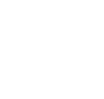

In [16]:
image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model)